# Project n°1 - Cats or dogs?

Authors : Selim Ben Abdallah, Paola De Truchis, Eduardo De Jesus Zancanaro Garcia and Edda Iveland

* The goal of this project is to study, classify and segment the images in the `Oxford-IIIT Pet` dataset.
* This dataset contains images and lables of cats and dogs of 37 different races. 


We will start by loading the data and performing an exploratory analysis before implementing deep learning methods that will classify images into dogs or cats and the different breeds. Lastly, we will apply a U-net network to segment the images: specifying where in the image the cat or dog is situated. 

---------

### Plan : 

* 0 - Libraries, util functions, global variables, ...
* 1 - Exploratory Data Analysis
* 2 - Binary Classification
* 3 - Multiclass Classification
* 4 - Segmentation
* 5 - Comparision, Conclusion


----

## 0 - Libraries, data, util functions, variables, ...

In [1]:
PATH_TO_TRAINVAL_TXT = "dataset/annotations/trainval.txt"
PATH_TO_TEST_TXT = "dataset/annotations/test.txt"
PATH_TO_LIST_TXT = "dataset/annotations/list.txt"

PATH_TO_IMG = "dataset/images/" # .jpg
PATH_TO_TRIMAPS = "dataset/annotations/trimaps/" #.png
PATH_TO_XML = "dataset/annotations/xmls/" #.xml

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from pathlib import Path
import xml.etree.ElementTree as ET

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import InterpolationMode

from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import resnet18, ResNet18_Weights

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report, roc_curve, auc, average_precision_score, precision_recall_curve

## 1 - Exploratory Data Analysis

### DataFrame construction

- The `dataset` contains two subfolders, `dataset/annotations/` and `dataset/images/`
- Let's first create a DataFrame with all the information we can collet from these subfolders.

In [3]:
data = []

with open(PATH_TO_LIST_TXT, 'r') as f:
    # we skip the first 6 lines (header)
    for _ in range(6):
        next(f)

    for line in f:
        line = line.strip()
        # we skip empty lines if any
        if not line:
            continue

        class_id, id_, species, breed_id = line.split()
        breed_name = "_".join(class_id.split("_")[:-1]) # breed name

        data.append({
            "class_id": class_id,
            "id": int(id_) - 1, # 0-indexed
            "species": int(species) - 1, # 0: cat, 1: dog
            "breed_id": int(breed_id) - 1, # 0-24:Cat 0:11:Dog
            "breed_name": breed_name,
        })

df = pd.DataFrame(data)
df["species_name"] = df["species"].map({0: "Cat", 1: "Dog"})
df["img_path"] = df["class_id"].apply(lambda x: f"{PATH_TO_IMG}{x}.jpg")
df["trimap_path"] = df["class_id"].apply(lambda x: f"{PATH_TO_TRIMAPS}{x}.png")
df = df.set_index("class_id", drop=False)
df.head()

class_id  id  species  breed_id  breed_name  \
class_id                                                            
Abyssinian_100  Abyssinian_100   0        0         0  Abyssinian   
Abyssinian_101  Abyssinian_101   0        0         0  Abyssinian   
Abyssinian_102  Abyssinian_102   0        0         0  Abyssinian   
Abyssinian_103  Abyssinian_103   0        0         0  Abyssinian   
Abyssinian_104  Abyssinian_104   0        0         0  Abyssinian   

               species_name                           img_path  \
class_id                                                         
Abyssinian_100          Cat  dataset/images/Abyssinian_100.jpg   
Abyssinian_101          Cat  dataset/images/Abyssinian_101.jpg   
Abyssinian_102          Cat  dataset/images/Abyssinian_102.jpg   
Abyssinian_103          Cat  dataset/images/Abyssinian_103.jpg   
Abyssinian_104          Cat  dataset/images/Abyssinian_104.jpg   

                                                   trimap_path  
class_id                                                        
Abyssinian_100  dataset/annotations/trimaps/Abyssinian_100.png  
Abyssinian_101  dataset/annotations/trimaps/Abyssinian_101.png  
Abyssinian_102  dataset/annotations/trimaps/Abyssinian_102.png  
Abyssinian_103  dataset/annotations/trimaps/Abyssinian_103.png  
Abyssinian_104  dataset/annotations/trimaps/Abyssinian_104.png

In [4]:
with open(PATH_TO_TRAINVAL_TXT, 'r') as f:
    trainval_ids = set()
    for line in f:
        line = line.strip()
        if not line:
            continue
        
        class_id, id_, species, breed_id = line.split()
        trainval_ids.add(class_id)

with open(PATH_TO_TEST_TXT, 'r') as f:
    test_ids = set()
    for line in f:
        line = line.strip()
        if not line:
            continue
        
        class_id, id_, species, breed_id = line.split()
        test_ids.add(class_id)

df["default_split"] = "unassigned"
df.loc[df["class_id"].isin(trainval_ids), "default_split"] = "trainval"
df.loc[df["class_id"].isin(test_ids), "default_split"] = "test"

- We have extracted information from `dataset/images`, `dataset/annotations/trimaps`, we can complete our DataFrame with the data from the `_.xml` files in `dataset/annotations/xmls`

In [5]:
def parse_xml(class_id):
    path = Path(PATH_TO_XML) / f"{class_id}.xml"
    if not path.exists():
        return {}

    root = ET.parse(path).getroot()

    size = root.find("size")
    obj = root.find("object")
    box = obj.find("bndbox")

    return {
        "width":     int(size.find("width").text),
        "height":    int(size.find("height").text),
        "depth":     int(size.find("depth").text),
        "segmented": int(root.find("segmented").text),
        #"xml_species": obj.find("name").text, we already have species info
        "pose":        obj.find("pose").text,
        "truncated":   int(obj.find("truncated").text),
        "occluded":    int(obj.find("occluded").text),
        "difficult":   int(obj.find("difficult").text),
        "bb_xmin": int(box.find("xmin").text),
        "bb_ymin": int(box.find("ymin").text),
        "bb_xmax": int(box.find("xmax").text),
        "bb_ymax": int(box.find("ymax").text),
        "xml_path": str(path),
    }


df = df.set_index("class_id", drop=False)

for col in [
    "width","height","depth","segmented","pose",
    "truncated","occluded","difficult","bb_xmin","bb_ymin","bb_xmax","bb_ymax"
]:
    df[col] = pd.NA

for cid in df.index:
    for k, v in parse_xml(cid).items():
        df.at[cid, k] = v

col_1 = df.pop("img_path")
col_2 = df.pop("trimap_path")
df.insert(len(df.columns), "img_path", col_1)
df.insert(len(df.columns), "trimap_path", col_2)

df.head(10)


class_id  id  species  breed_id  breed_name  \
class_id                                                            
Abyssinian_100  Abyssinian_100   0        0         0  Abyssinian   
Abyssinian_101  Abyssinian_101   0        0         0  Abyssinian   
Abyssinian_102  Abyssinian_102   0        0         0  Abyssinian   
Abyssinian_103  Abyssinian_103   0        0         0  Abyssinian   
Abyssinian_104  Abyssinian_104   0        0         0  Abyssinian   
Abyssinian_105  Abyssinian_105   0        0         0  Abyssinian   
Abyssinian_106  Abyssinian_106   0        0         0  Abyssinian   
Abyssinian_107  Abyssinian_107   0        0         0  Abyssinian   
Abyssinian_108  Abyssinian_108   0        0         0  Abyssinian   
Abyssinian_109  Abyssinian_109   0        0         0  Abyssinian   

               species_name default_split width height depth  ... truncated  \
class_id                                                      ...             
Abyssinian_100          Cat      trainval   394    500     3  ...         0   
Abyssinian_101          Cat      trainval   450    313     3  ...         0   
Abyssinian_102          Cat      trainval   500    465     3  ...         0   
Abyssinian_103          Cat      trainval   500    351     3  ...         0   
Abyssinian_104          Cat      trainval  <NA>   <NA>  <NA>  ...      <NA>   
Abyssinian_105          Cat      trainval   500    375     3  ...         0   
Abyssinian_106          Cat      trainval  1536   1024     3  ...         0   
Abyssinian_107          Cat      trainval   500    448     3  ...         0   
Abyssinian_108          Cat      trainval   500    404     3  ...         0   
Abyssinian_109          Cat      trainval   282    450     3  ...         0   

               occluded difficult bb_xmin bb_ymin bb_xmax bb_ymax  \
class_id                                                            
Abyssinian_100        0         0     151      71     335     267   
Abyssinian_101        0         0      54      36     319     235   
Abyssinian_102        0         0      23      27     325     320   
Abyssinian_103        0         0     241      68     362     196   
Abyssinian_104     <NA>      <NA>    <NA>    <NA>    <NA>    <NA>   
Abyssinian_105        0         0     237     101     373     227   
Abyssinian_106        0         0     861     156    1302     563   
Abyssinian_107        0         0      94      76     275     271   
Abyssinian_108        0         0      50      14     336     304   
Abyssinian_109        0         0      81       7     246     146   

                                                   xml_path  \
class_id                                                      
Abyssinian_100  dataset/annotations/xmls/Abyssinian_100.xml   
Abyssinian_101  dataset/annotations/xmls/Abyssinian_101.xml   
Abyssinian_102  dataset/annotations/xmls/Abyssinian_102.xml   
Abyssinian_103  dataset/annotations/xmls/Abyssinian_103.xml   
Abyssinian_104                                          NaN   
Abyssinian_105  dataset/annotations/xmls/Abyssinian_105.xml   
Abyssinian_106  dataset/annotations/xmls/Abyssinian_106.xml   
Abyssinian_107  dataset/annotations/xmls/Abyssinian_107.xml   
Abyssinian_108  dataset/annotations/xmls/Abyssinian_108.xml   
Abyssinian_109  dataset/annotations/xmls/Abyssinian_109.xml   

                                         img_path  \
class_id                                            
Abyssinian_100  dataset/images/Abyssinian_100.jpg   
Abyssinian_101  dataset/images/Abyssinian_101.jpg   
Abyssinian_102  dataset/images/Abyssinian_102.jpg   
Abyssinian_103  dataset/images/Abyssinian_103.jpg   
Abyssinian_104  dataset/images/Abyssinian_104.jpg   
Abyssinian_105  dataset/images/Abyssinian_105.jpg   
Abyssinian_106  dataset/images/Abyssinian_106.jpg   
Abyssinian_107  dataset/images/Abyssinian_107.jpg   
Abyssinian_108  dataset/images/Abyssinian_108.jpg   
Abyssinian_109  dataset/images/Abyssinian_109.jpg   

                     

In [6]:
print("Are all rows unique ?", not df.duplicated().any())

Are all rows unique ? True


- All rows are unique, no duplicates in the dataframe

In [7]:
def count_files(path_to_img, path_to_xml, path_to_trimaps):
    trimaps_count = len(list(Path(path_to_trimaps).glob("*.png")))
    img_count = len(list(Path(path_to_img).glob("*.jpg")))
    xml_count = len(list(Path(path_to_xml).glob("*.xml")))
    return img_count, xml_count, trimaps_count

img_count, xml_count, trimaps_count = count_files(PATH_TO_IMG, PATH_TO_XML, PATH_TO_TRIMAPS)
print("Number of PNG files (masks):", trimaps_count)
print("Number of JPG files (images):", img_count)
print("Number of XML files (additional info):", xml_count)

Number of PNG files (masks): 7390
Number of JPG files (images): 7390
Number of XML files (additional info): 3686


- There are 7390 images, associated to 7390 segmentation masks
- However the data from the .xml files (bounding box, pose, ...) is missing for 3704 images

In [8]:
df.isna().sum().sort_values(ascending=False)

pose             3678
difficult        3678
xml_path         3678
bb_ymax          3678
bb_xmax          3678
bb_ymin          3678
width            3678
height           3678
depth            3678
segmented        3678
bb_xmin          3678
truncated        3678
occluded         3678
img_path            0
class_id            0
id                  0
default_split       0
species_name        0
breed_name          0
breed_id            0
species             0
trimap_path         0
dtype: int64

### Train / Val / Test distribution

In [9]:
df["default_split"].value_counts()

default_split
trainval    3680
test        3669
Name: count, dtype: int64

- The default trainval / test split is balanced in terms of size, but not ideal for deep learning
- The default split has not a proper validation set, so as is, we can't monitor overfitting, learning curves, hyperparemeters tuning.
- Also, the defualt split is not identical per breed, is not stratified, and imbalanced for some breeds (-11 image imbalance for the stafford_bull_terrier breed between the default trainval and test splits, -8 image imbalance for the Bombay breed between the trainval and test splits)
- The default test set is to large

In [10]:
pd.crosstab(df["breed_name"], df["default_split"])

default_split               test  trainval
breed_name                                
Abyssinian                    98       100
Bengal                       100       100
Birman                       100       100
Bombay                        88        96
British_Shorthair            100       100
Egyptian_Mau                  97        93
Maine_Coon                   100       100
Persian                      100       100
Ragdoll                      100       100
Russian_Blue                 100       100
Siamese                      100        99
Sphynx                       100       100
american_bulldog             100       100
american_pit_bull_terrier    100       100
basset_hound                 100       100
beagle                       100       100
boxer                         99       100
chihuahua                    100       100
english_cocker_spaniel       100        96
english_setter               100       100
german_shorthaired           100       100
great_pyrenees               100       100
havanese                     100       100
japanese_chin                100       100
keeshond                      99       100
leonberger                   100       100
miniature_pinscher           100       100
newfoundland                 100        96
pomeranian                   100       100
pug                          100       100
saint_bernard                100       100
samoyed                      100       100
scottish_terrier              99       100
shiba_inu                    100       100
staffordshire_bull_terrier    89       100
wheaten_terrier              100       100
yorkshire_terrier            100       100

- We are going to re-split our dataset (80% : train, 10% val, 10% test), such that we can make it more efficient for our incoming deep learning tasks, and to be able to monitor the risk of overfitting, hyperparameter tunning and losses.
- We will make sure the new split is stratified, so that each breeds are well represented in each set

In [11]:
# we first split into train+val and test
train_ids, test_ids = train_test_split(
    df.index,
    test_size=0.1,
    stratify=df["id"],
    random_state=42
)

# we then split train into train and val
train_ids, val_ids = train_test_split(
    train_ids,
    test_size=0.1 / 0.9,  # ensures final 80/10/10
    stratify=df.loc[train_ids, "id"],
    random_state=42
)

df["new_split"] = "train"
df.loc[val_ids, "new_split"] = "val"
df.loc[test_ids, "new_split"] = "test"

breed_crosstab = pd.crosstab(df["breed_name"], df["new_split"])
breed_crosstab

new_split                   test  train  val
breed_name                                  
Abyssinian                    20    158   20
Bengal                        20    160   20
Birman                        20    160   20
Bombay                        18    148   18
British_Shorthair             20    160   20
Egyptian_Mau                  19    152   19
Maine_Coon                    20    160   20
Persian                       20    160   20
Ragdoll                       20    160   20
Russian_Blue                  20    160   20
Siamese                       20    159   20
Sphynx                        20    160   20
american_bulldog              20    160   20
american_pit_bull_terrier     20    160   20
basset_hound                  20    160   20
beagle                        20    160   20
boxer                         20    159   20
chihuahua                     20    160   20
english_cocker_spaniel        20    157   19
english_setter                20    160   20
german_shorthaired            20    160   20
great_pyrenees                20    160   20
havanese                      20    160   20
japanese_chin                 20    160   20
keeshond                      20    159   20
leonberger                    20    160   20
miniature_pinscher            20    160   20
newfoundland                  19    157   20
pomeranian                    20    160   20
pug                           20    160   20
saint_bernard                 20    160   20
samoyed                       20    160   20
scottish_terrier              20    159   20
shiba_inu                     20    160   20
staffordshire_bull_terrier    19    151   19
wheaten_terrier               20    160   20
yorkshire_terrier             20    160   20

In [12]:
proportion_per_breed = breed_crosstab.div(breed_crosstab.sum(axis=1), axis=0)
ideal_breed_proportions = pd.Series({"train": 0.80, "val": 0.10, "test": 0.10})
variance_relative_to_ideal_prop = ((proportion_per_breed - ideal_breed_proportions) ** 2).mean(axis=1)

summary_proportion_per_breed = pd.DataFrame({
    "train_prop": proportion_per_breed["train"],
    "val_prop": proportion_per_breed["val"],
    "test_prop": proportion_per_breed["test"],
    "variance_from_ideal": variance_relative_to_ideal_prop,
})

summary_proportion_per_breed.sort_values("variance_from_ideal")

train_prop  val_prop  test_prop  \
breed_name                                                    
yorkshire_terrier             0.800000  0.100000   0.100000   
leonberger                    0.800000  0.100000   0.100000   
pomeranian                    0.800000  0.100000   0.100000   
japanese_chin                 0.800000  0.100000   0.100000   
havanese                      0.800000  0.100000   0.100000   
great_pyrenees                0.800000  0.100000   0.100000   
german_shorthaired            0.800000  0.100000   0.100000   
english_setter                0.800000  0.100000   0.100000   
wheaten_terrier               0.800000  0.100000   0.100000   
chihuahua                     0.800000  0.100000   0.100000   
samoyed                       0.800000  0.100000   0.100000   
beagle                        0.800000  0.100000   0.100000   
basset_hound                  0.800000  0.100000   0.100000   
american_pit_bull_terrier     0.800000  0.100000   0.100000   
american_bulldog              0.800000  0.100000   0.100000   
Sphynx                        0.800000  0.100000   0.100000   
pug                           0.800000  0.100000   0.100000   
Russian_Blue                  0.800000  0.100000   0.100000   
Ragdoll                       0.800000  0.100000   0.100000   
Persian                       0.800000  0.100000   0.100000   
Maine_Coon                    0.800000  0.100000   0.100000   
Egyptian_Mau                  0.800000  0.100000   0.100000   
British_Shorthair             0.800000  0.100000   0.100000   
saint_bernard                 0.800000  0.100000   0.100000   
Birman                        0.800000  0.100000   0.100000   
Bengal                        0.800000  0.100000   0.100000   
miniature_pinscher            0.800000  0.100000   0.100000   
shiba_inu                     0.800000  0.100000   0.100000   
boxer                         0.798995  0.100503   0.100503   
Siamese                       0.798995  0.100503   0.100503   
keeshond                      0.798995  0.100503   0.100503   
scottish_terrier              0.798995  0.100503   0.100503   
staffordshire_bull_terrier    0.798942  0.100529   0.100529   
Abyssinian                    0.797980  0.101010   0.101010   
newfoundland                  0.801020  0.102041   0.096939   
english_cocker_spaniel        0.801020  0.096939   0.102041   
Bombay                        0.804348  0.097826   0.097826   

                            variance_from_ideal  
breed_name                                       
yorkshire_terrier                  0.000000e+00  
leonberger                         0.000000e+00  
pomeranian                         0.000000e+00  
japanese_chin                      0.000000e+00  
havanese                           0.000000e+00  
great_pyrenees                     0.000000e+00  
german_shorthaired                 0.000000e+00  
english_setter                     0.000000e+00  
wheaten_terrier                    0.000000e+00  
chihuahua                          0.000000e+00  
samoyed                            0.000000e+00  
beagle                             0.000000e+00  
basset_hound                       0.000000e+00  
american_pit_bull_terrier          0.000000e+00  
american_bulldog                   0.000000e+00  
Sphynx                             0.000000e+00  
pug                                0.000000e+00  
Russian_Blue                       0.000000e+00  
Ragdoll                            0.000000e+00  
Persian                            0.000000e+00  
Maine_Coon                         0.000000e+00  
Egyptian_Mau                       0.000000e+00  
British_Shorthair                  0.000000e+00  
saint_bernard                      0.000000e+00  
Birman                             0.000000e+00  
Bengal                             0.000000e+00  
miniature_pinscher                 0.000000e+00  
shiba_inu                          0.000000e+00  
boxer                              5.050378e-07  
Siamese             

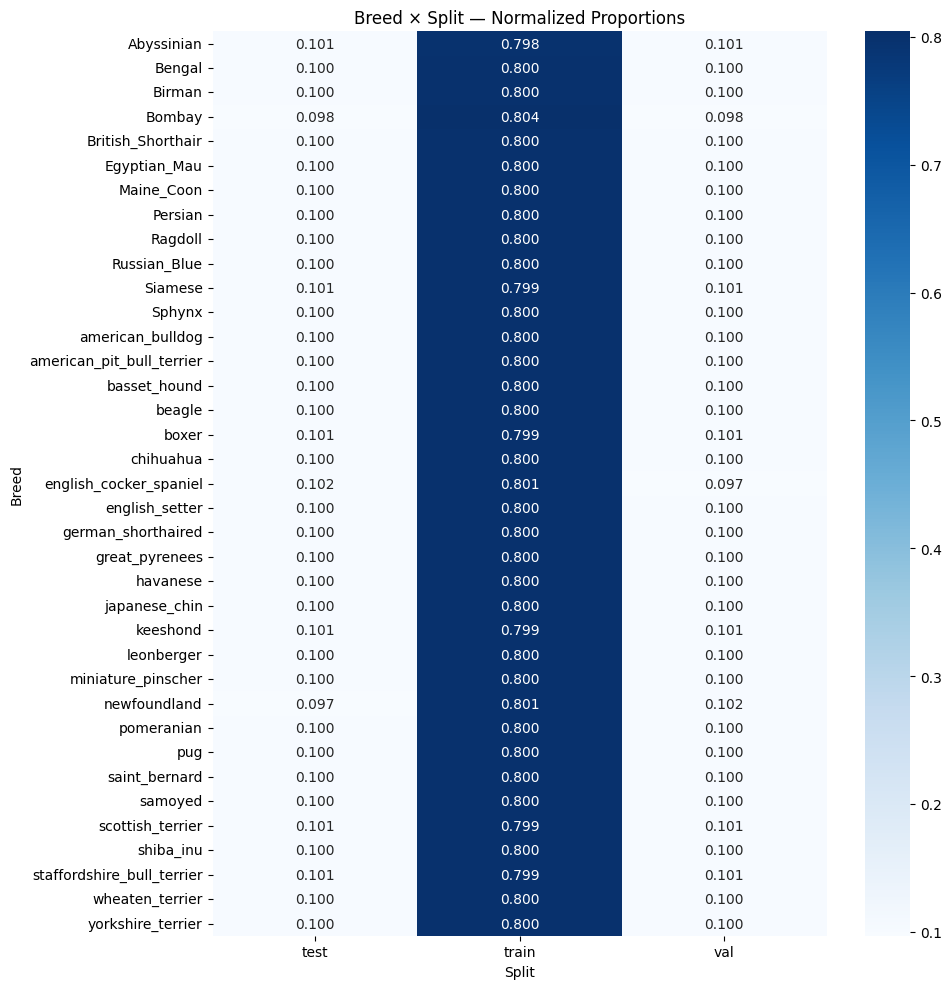

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(proportion_per_breed, annot=True, fmt=".3f", cmap="Blues")
plt.title("Breed × Split — Normalized Proportions")
plt.xlabel("Split")
plt.ylabel("Breed")
plt.tight_layout()
plt.show()


- With this new data split, we have roughly 80% of each breed in the train set, 10% in the val set, and 10% in the test set.

### Breed & Species distribution

#### Dog vs Cats

Total Number of Animals : 7349
Number of Dogs : 4978
Number of Cats : 2371


Text(0.5, 1.0, 'Species Distribution')

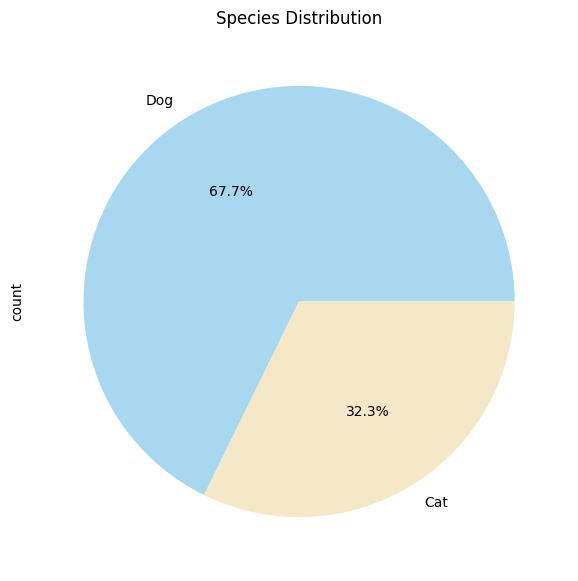

In [14]:
print("Total Number of Animals :", df.shape[0])
print("Number of Dogs :", df[df["species_name"] == "Dog"].shape[0])
print("Number of Cats :", df[df["species_name"] == "Cat"].shape[0])

df["species_name"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    figsize=(7,7),
    colors = ["#A7D8F0", "#F5E8C7"]
)
plt.title("Species Distribution")

- There are more dog images (67.7%, 4978) than cat images (32.3%, 2371), which highlights an important class imbalance.

- For the binary classification (cat vs dog) :  we will need to either use a weighted loss so the network penalizes mistakes on cats more fairly, oversample cats or undersample dogs, or maybe apply stronger augmentation to cats. We will also need to consider per-class metrics (precision per class, recall per class, f1-score, and not only the accuracy that may hide some bias)

- For the multiclass classification (37 breeds) : We have already constructed the train/val/test sets with a stratified splitting so that each breed appears with the correct (80/10/10) proportion. We can also consider using a weighted loss, data augmentation, and evaluate our model with macro metrics (macro F1, macro recall, balanced accuracy)

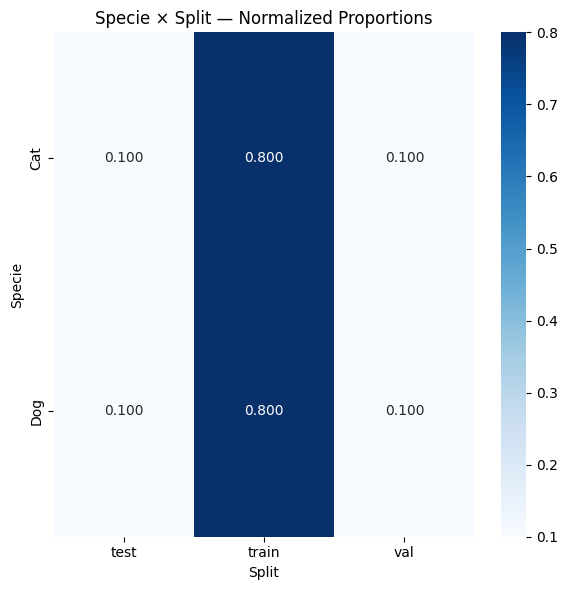

In [15]:
species_crosstab = pd.crosstab(df["species_name"], df["new_split"])
propertion_per_specie = species_crosstab.div(species_crosstab.sum(axis=1), axis=0)
species_crosstab

plt.figure(figsize=(6,6))
sns.heatmap(propertion_per_specie, annot=True, fmt=".3f", cmap="Blues")
plt.title("Specie × Split — Normalized Proportions")
plt.xlabel("Split")
plt.ylabel("Specie")
plt.tight_layout()
plt.show()

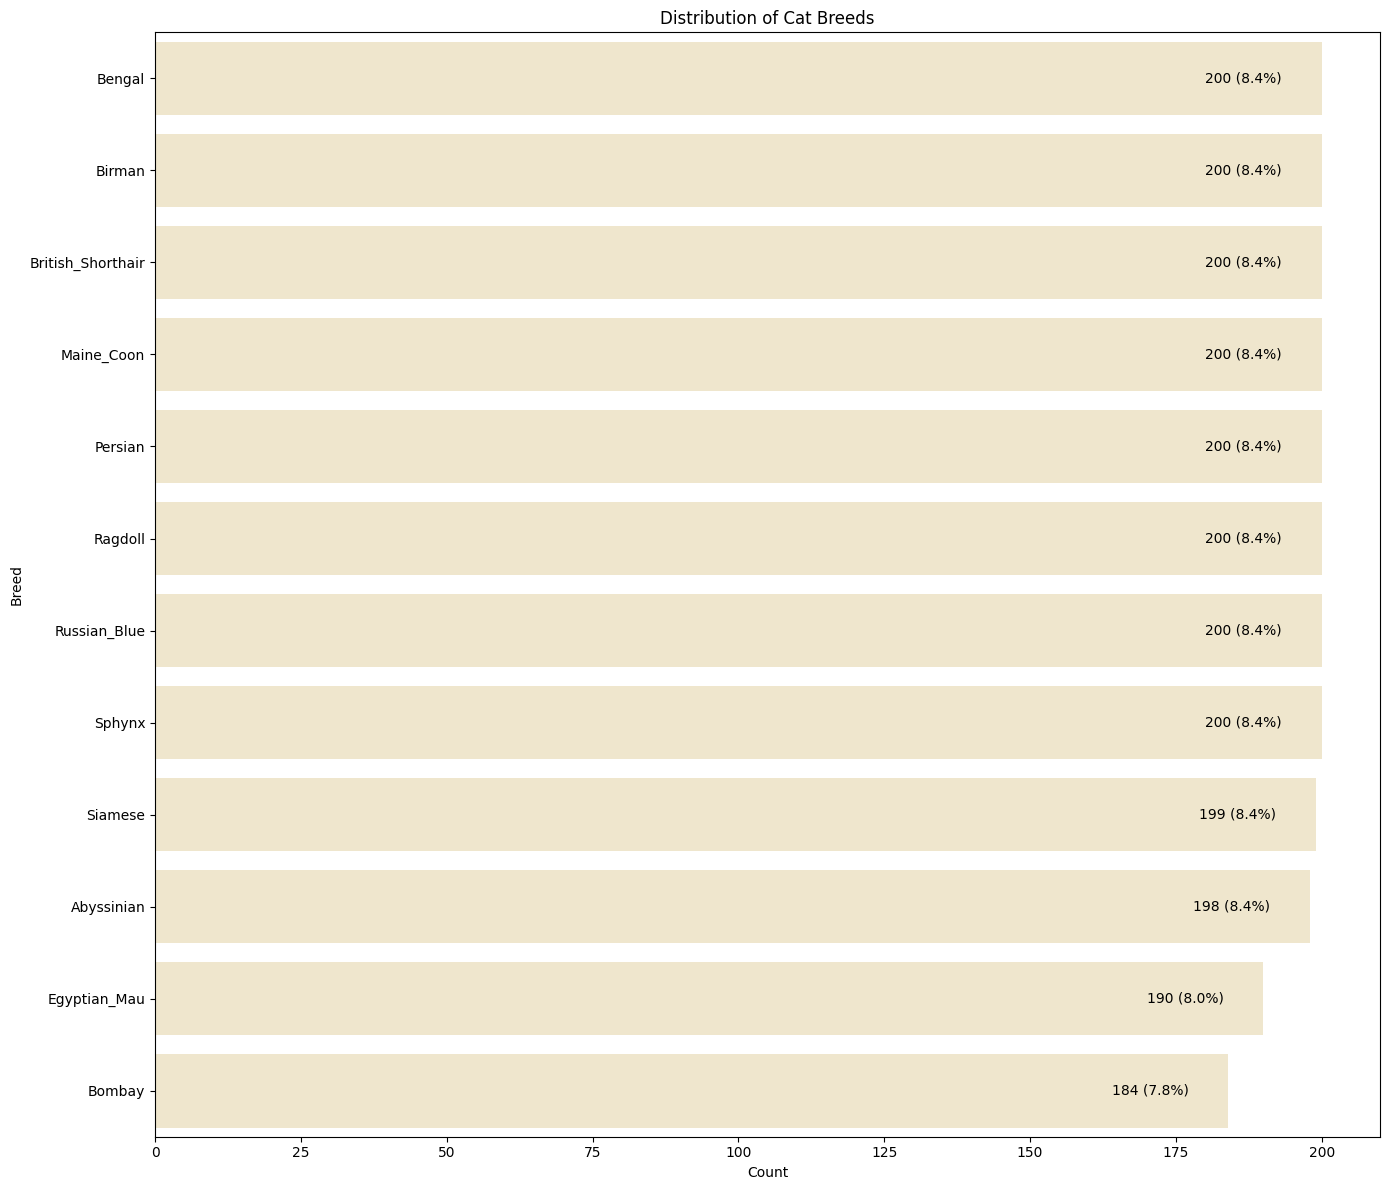

In [16]:
cats = df[df["species_name"] == "Cat"]

plt.figure(figsize=(14,12))
ax = sns.countplot(
    data=cats,
    y="breed_name",
    order=cats["breed_name"].value_counts().index,
    color="#F5E8C7"
)
plt.title("Distribution of Cat Breeds")
plt.xlabel("Count")
plt.ylabel("Breed")

#Bar Annotations
total = len(cats)

for p in ax.patches:
    count = int(p.get_width())
    percent = 100 * count / total
    text = f"{count} ({percent:.1f}%)"
    ax.text(
        p.get_width() - 20,     
        p.get_y() + p.get_height()/2, 
        text,
        va="center"
    )
plt.tight_layout()
plt.show()


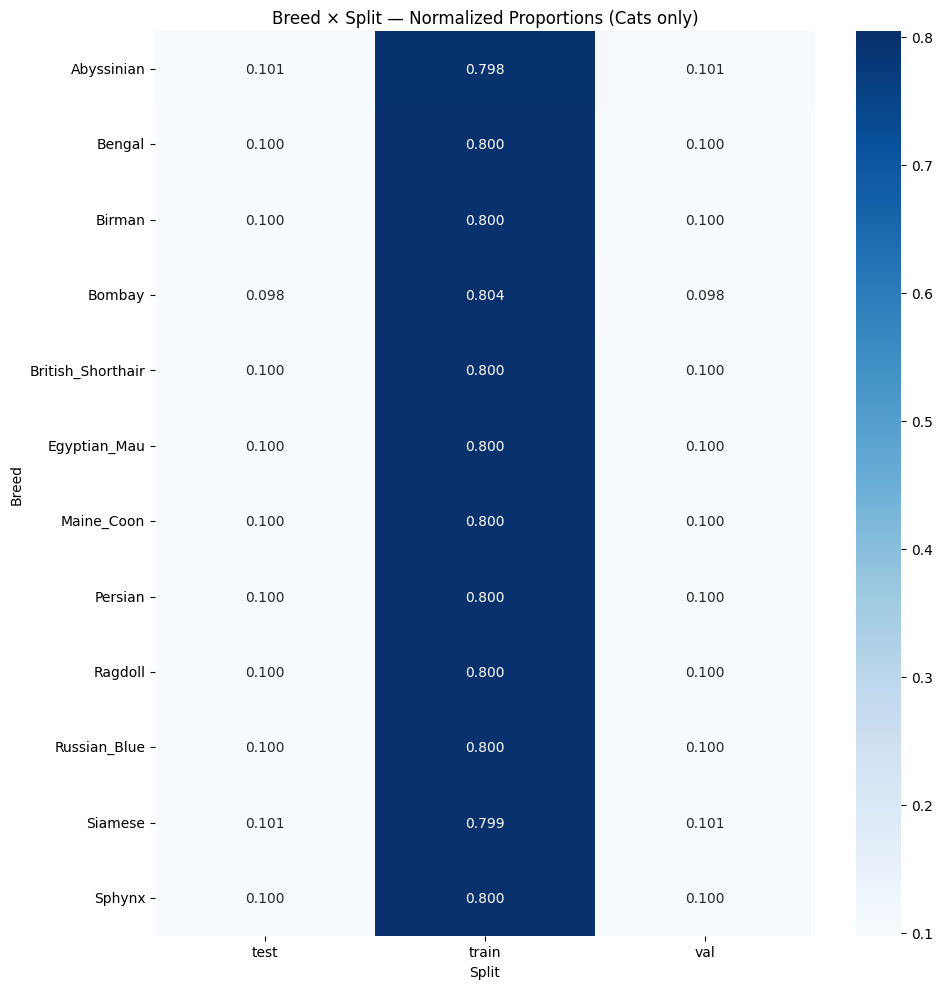

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(proportion_per_breed.iloc[:12], annot=True, fmt=".3f", cmap="Blues")
plt.title("Breed × Split — Normalized Proportions (Cats only)")
plt.xlabel("Split")
plt.ylabel("Breed")
plt.tight_layout()
plt.show()

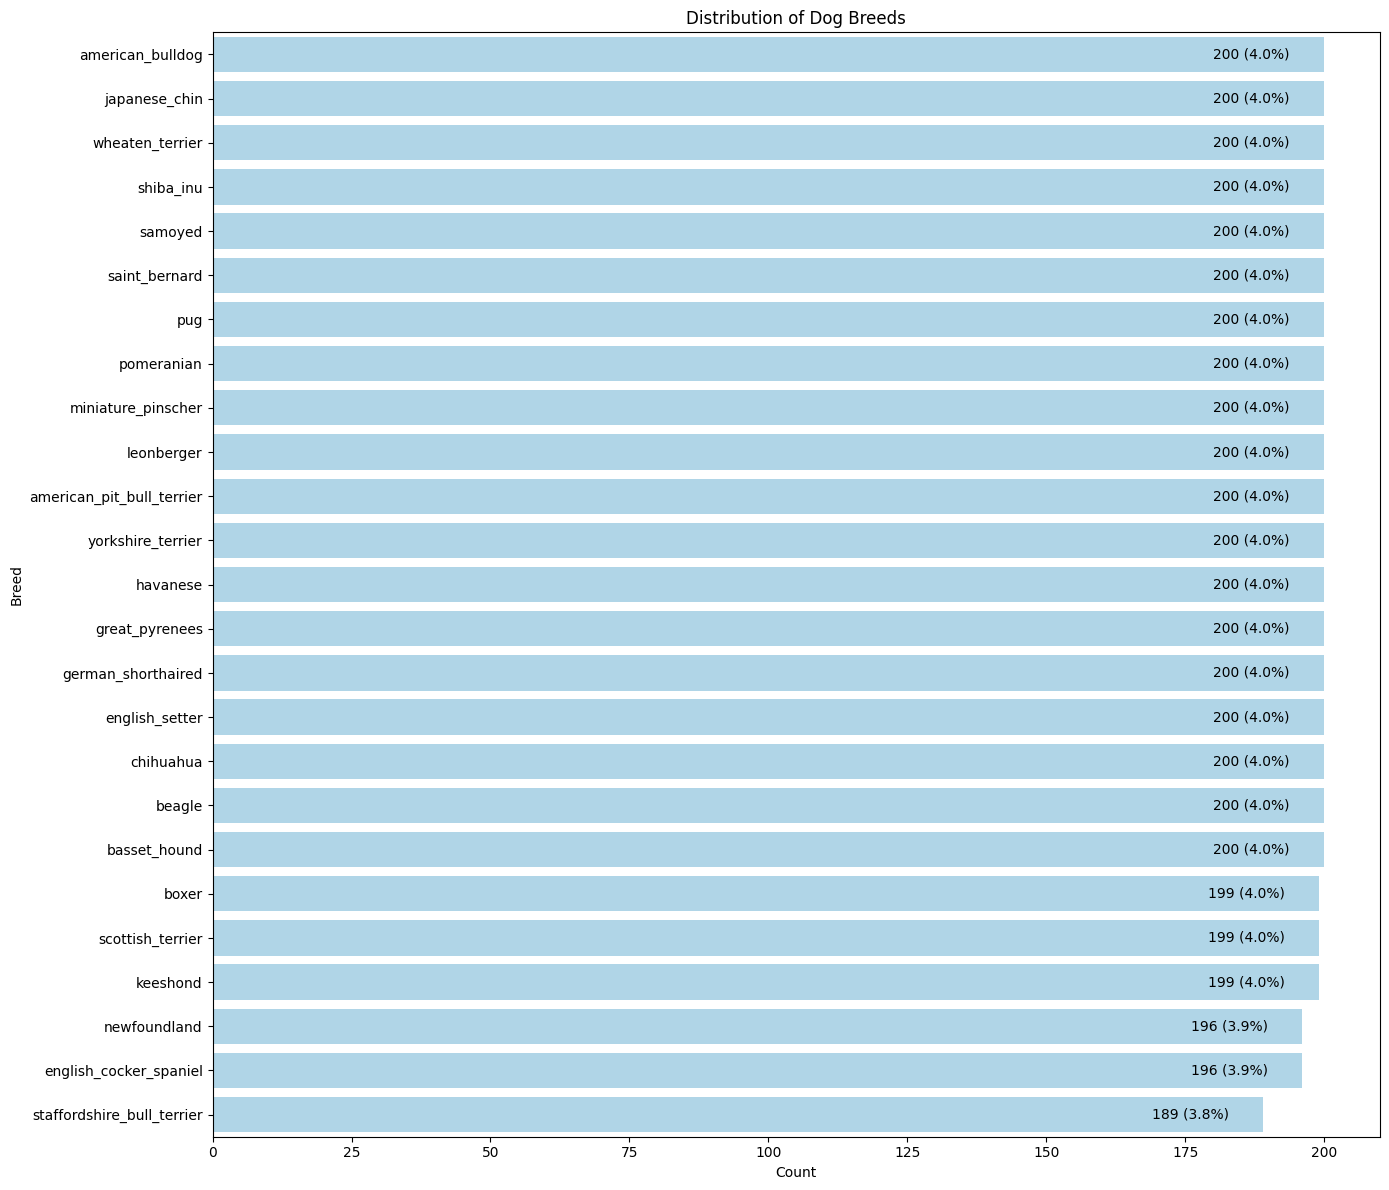

In [18]:
dogs = df[df["species_name"] == "Dog"]

plt.figure(figsize=(14,12))
ax = sns.countplot(
    data=dogs,
    y="breed_name",
    order=dogs["breed_name"].value_counts().index,
    color="#A7D8F0"
)
plt.title("Distribution of Dog Breeds")
plt.xlabel("Count")
plt.ylabel("Breed")

#Bar Annotations
total = len(dogs)

for p in ax.patches:
    count = int(p.get_width())
    percent = 100 * count / total
    text = f"{count} ({percent:.1f}%)"
    ax.text(
        p.get_width() - 20,     
        p.get_y() + p.get_height()/2, 
        text,
        va="center"
    )
plt.tight_layout()
plt.show()


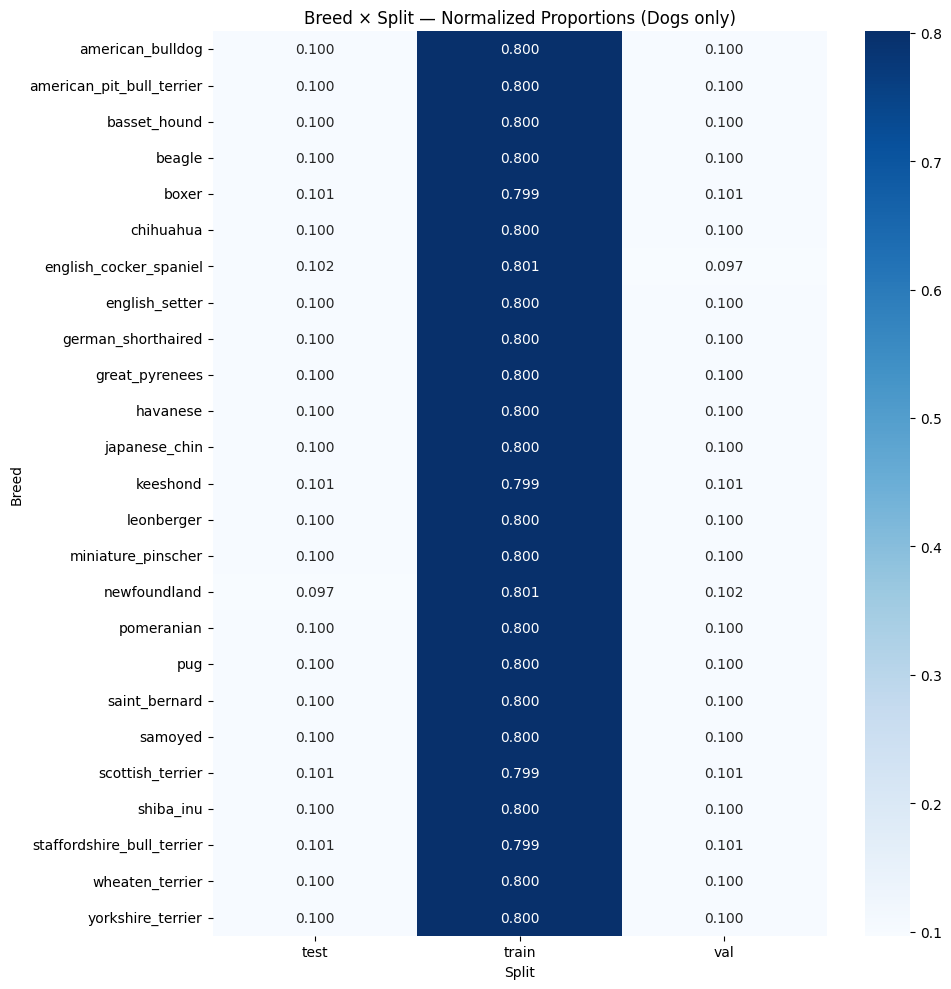

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(proportion_per_breed.iloc[12:], annot=True, fmt=".3f", cmap="Blues")
plt.title("Breed × Split — Normalized Proportions (Dogs only)")
plt.xlabel("Split")
plt.ylabel("Breed")
plt.tight_layout()
plt.show()

There are 12 breeds of cats and 25 breeds of dogs.

All races have 200 images each, except for :

Cats : 
 - Siameses with 199 images
 - Abyssinians with 198 images
 - Egyptian_Maus with 190 images
 - Bombays with 184 images
 
Dogs : 
 - boxers with 199 images
 - keeshonds with 199 images
 - scottish_terriers with 199 images
 - english_cocker_spaniels with 196 images
 - newfoundlands with 196 images
- staffordshire_bull_terriers with 189 images

### Visualisation of Image, Masks, and Bounding Boxes

#### Image and masks and mask visualisation

The mask and image have the same size


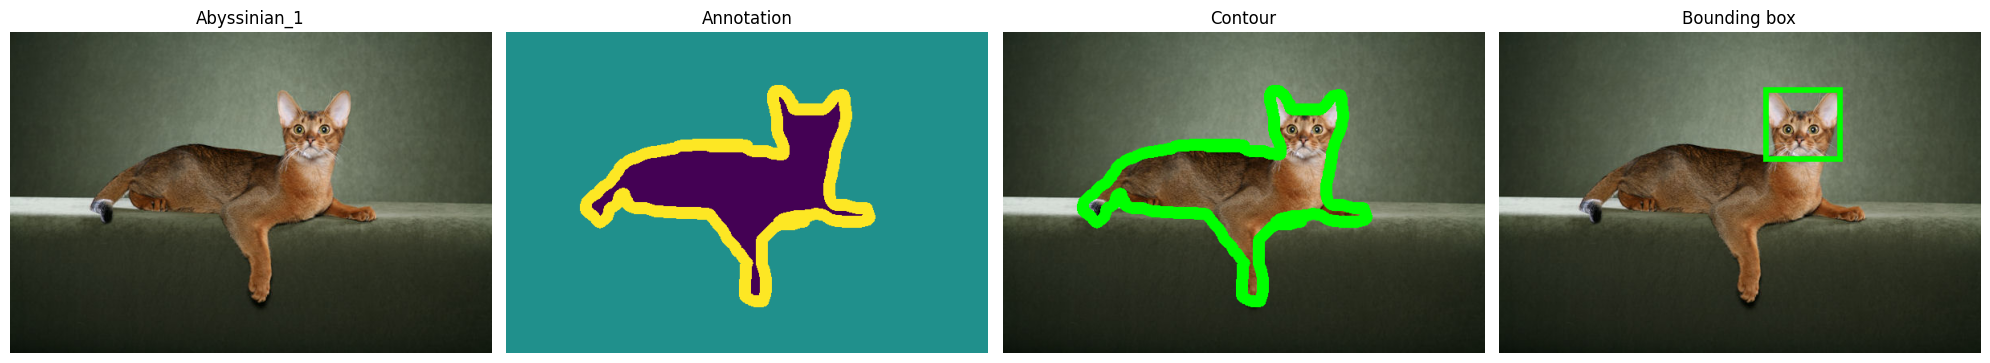

The mask and image have the same size


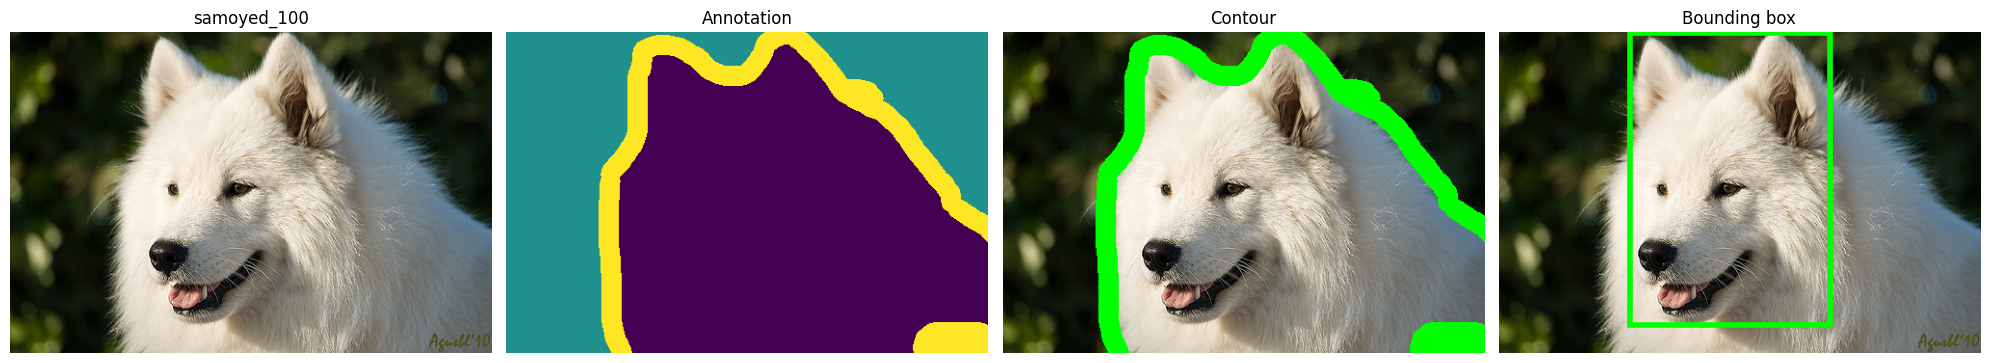

In [20]:
def show_image_mask_bbox(class_id):
    row = df.loc[class_id] if class_id in df.index else df[df["class_id"] == class_id].iloc[0]

    img = Image.open(row["img_path"]).convert("RGB")
    ann = Image.open(row["trimap_path"])

    img_arr = np.array(img)
    ann_arr = np.array(ann)

    if img_arr.shape[:2] == ann_arr.shape[:2]:
        print("The mask and image have the same size")
    else:
        print("Warning: image and mask sizes differ:",
              img_arr.shape[:2], ann_arr.shape[:2])

    #Contour 
    contour = img_arr.copy()
    contour[ann_arr == 3] = [0, 255, 0] # we highlight the contour
    has_xml = not pd.isna(row["xml_path"])
    n_panels = 4 if has_xml else 3

    fig, ax = plt.subplots(1, n_panels, figsize=(5 * n_panels, 5))

    # Original image
    ax[0].imshow(img)
    ax[0].set_title(row["class_id"])
    ax[0].axis("off")

    # Annotation from trimap
    ax[1].imshow(ann_arr, cmap="viridis")
    ax[1].set_title("Annotation")
    ax[1].axis("off")

    # Contour
    ax[2].imshow(contour)
    ax[2].set_title("Contour")
    ax[2].axis("off")

    # Bounding box (if the .xml file exists)
    if has_xml:
        x_min = int(row["bb_xmin"])
        y_min = int(row["bb_ymin"])
        x_max = int(row["bb_xmax"])
        y_max = int(row["bb_ymax"])
        box_w = x_max - x_min
        box_h = y_max - y_min

        ax[3].imshow(img_arr)
        rect = patches.Rectangle(
            (x_min, y_min),
            box_w,
            box_h,
            linewidth=4,
            edgecolor="lime",
            facecolor="none"
        )
        ax[3].add_patch(rect)
        ax[3].set_title("Bounding box")
        ax[3].axis("off")

    plt.tight_layout()
    plt.show()

# Abyssinian_1 has an .xml file
show_image_mask_bbox("Abyssinian_1")

# Abyssinian_1 has an .xml file
show_image_mask_bbox("samoyed_100")


The mask and image have the same size


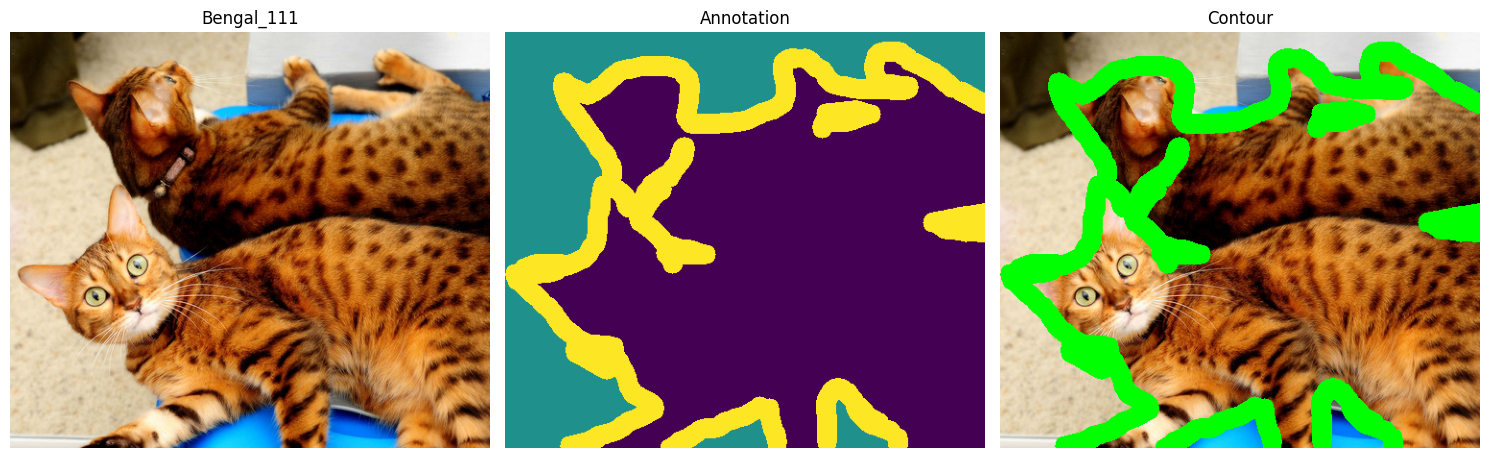

The mask and image have the same size


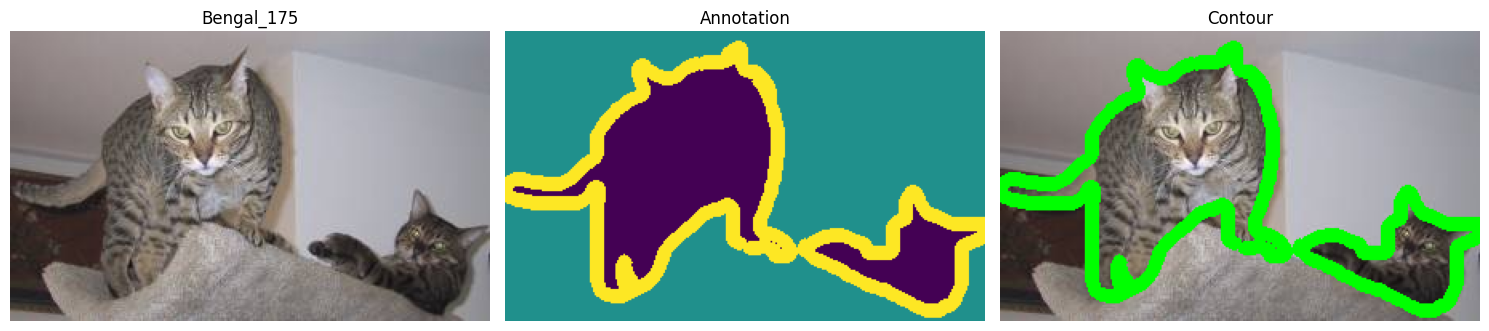

In [21]:
show_image_mask_bbox("Bengal_111")
show_image_mask_bbox("Bengal_175")

- When a trimap is available, it provides information about both the animal and the background.
- The contour may be fully visible in the image (as in Abyssinian_1) or only partially visible (as in samoyed_100).
- Some images contain two animals, and in those cases the trimap may include either a single merged contour (e.g., Bengal_111) or two separate contours (e.g., Bengal_175).
- We also observed that when a bounding box is provided, it typically encloses only the animal's head.

#### Missing bounding boxes

Number of images with missing XML/bounding boxes: 3678
Showing: miniature_pinscher_45
The mask and image have the same size


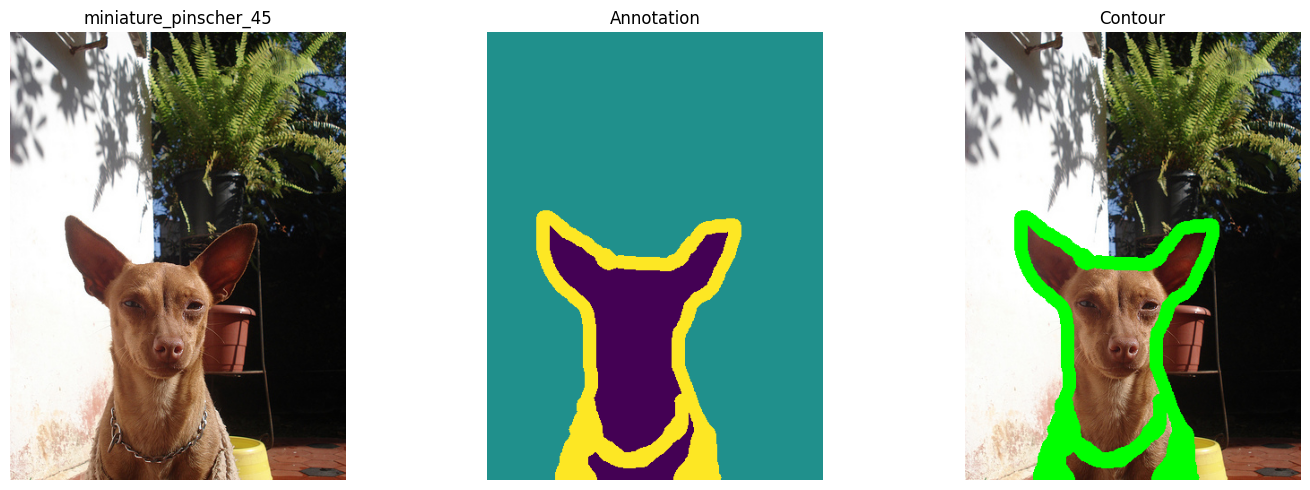

Showing: japanese_chin_58
The mask and image have the same size


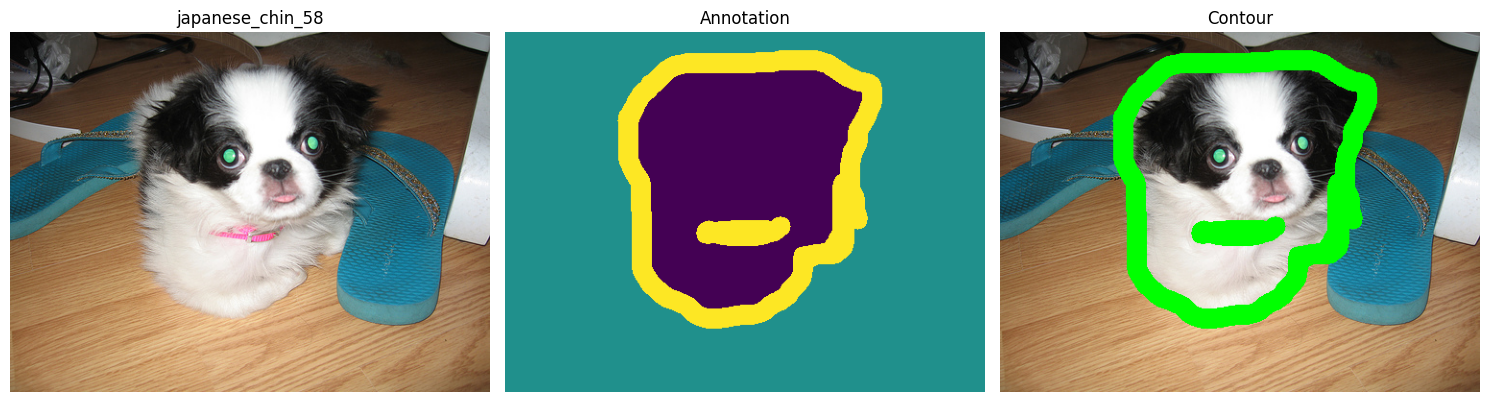

Showing: shiba_inu_85
The mask and image have the same size


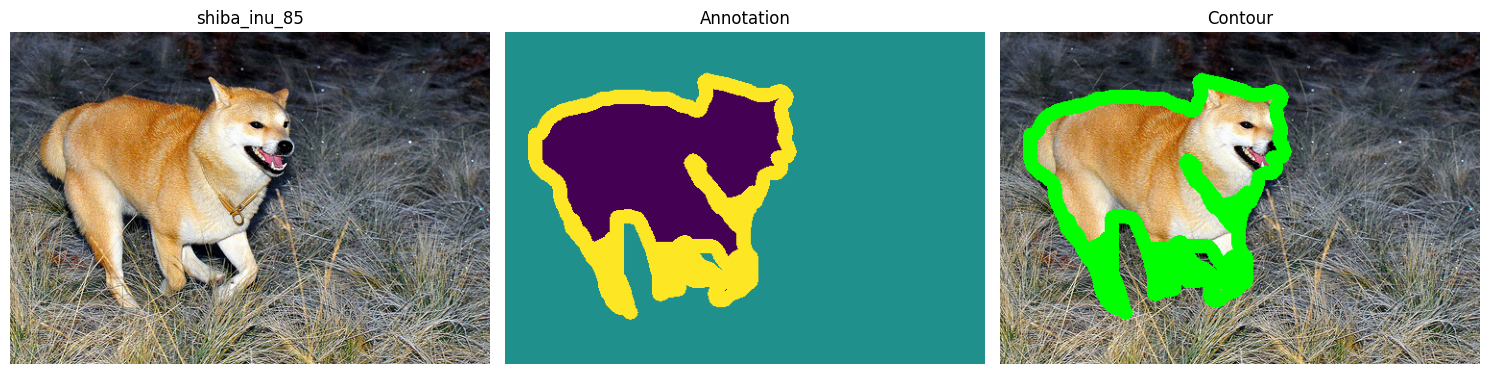

In [22]:
# Missing bounding boxes
missing_xml = df[df["xml_path"].isna()]
num_missing = len(missing_xml)
print(f"Number of images with missing XML/bounding boxes: {num_missing}")

sample_missing = missing_xml.sample(3, random_state=42)
for class_id in sample_missing["class_id"]:
    print(f"Showing: {class_id}")
    show_image_mask_bbox(class_id)


##### Missing trimaps

- We found that 14 images have trimaps containing only a single color.
- This is not an issue for the classification tasks, but these images will be removed before segmentation to avoid introducing bias into the models.

In [23]:
# Missing trimaps 
bad_trimaps = []
for class_id, row in df.iterrows():
    trimap_path = row["trimap_path"]
    ann = Image.open(trimap_path)
    ann_arr = np.array(ann)
    uniq = np.unique(ann_arr)

    if len(uniq) != 3 or not set(uniq).issubset({1, 2, 3}):
        bad_trimaps.append((class_id, uniq))

print("Trimaps with unexpected number of colors:")
for cid, uniq in bad_trimaps:
    print(f"{cid}: unique values = {uniq}")


Trimaps with unexpected number of colors:
saint_bernard_108: unique values = [2]
Egyptian_Mau_162: unique values = [2]
Egyptian_Mau_165: unique values = [2]
Egyptian_Mau_196: unique values = [2]
leonberger_18: unique values = [2]
miniature_pinscher_14: unique values = [2]
saint_bernard_15: unique values = [2]
Egyptian_Mau_20: unique values = [2]
japanese_chin_199: unique values = [2]
keeshond_7: unique values = [2]
Persian_259: unique values = [2]
saint_bernard_60: unique values = [2]
saint_bernard_78: unique values = [2]
wheaten_terrier_195: unique values = [2]


The mask and image have the same size


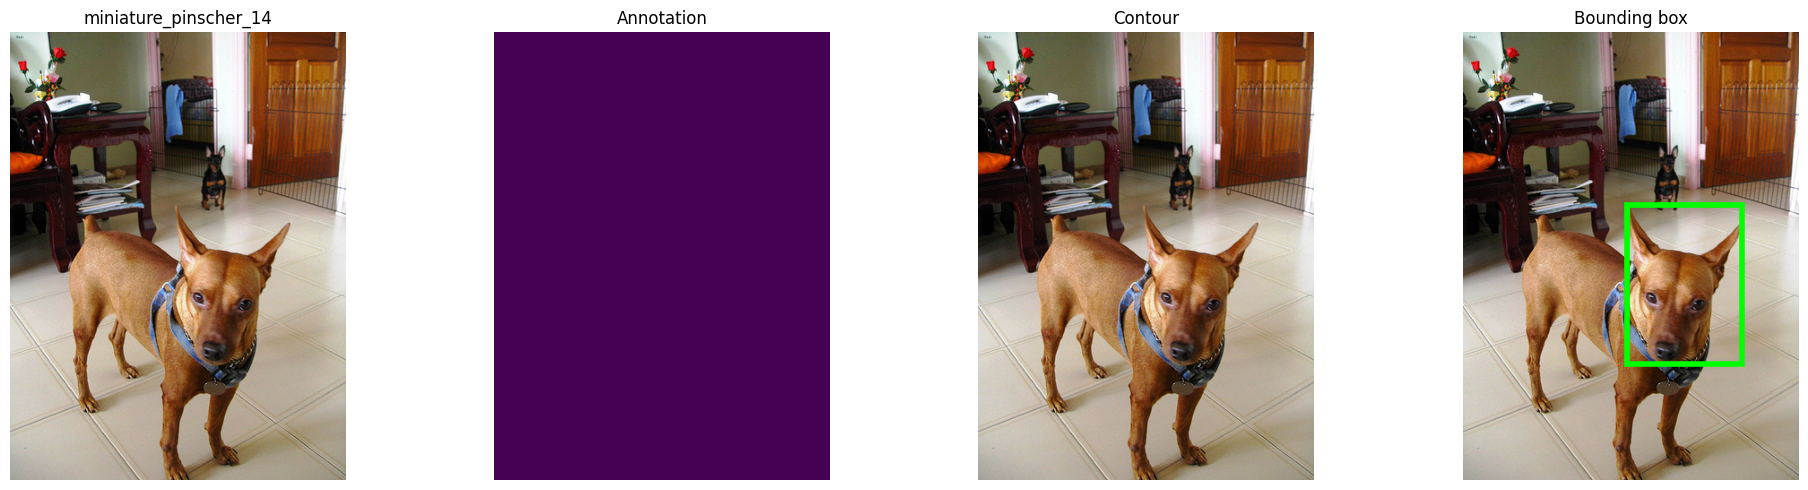

The mask and image have the same size


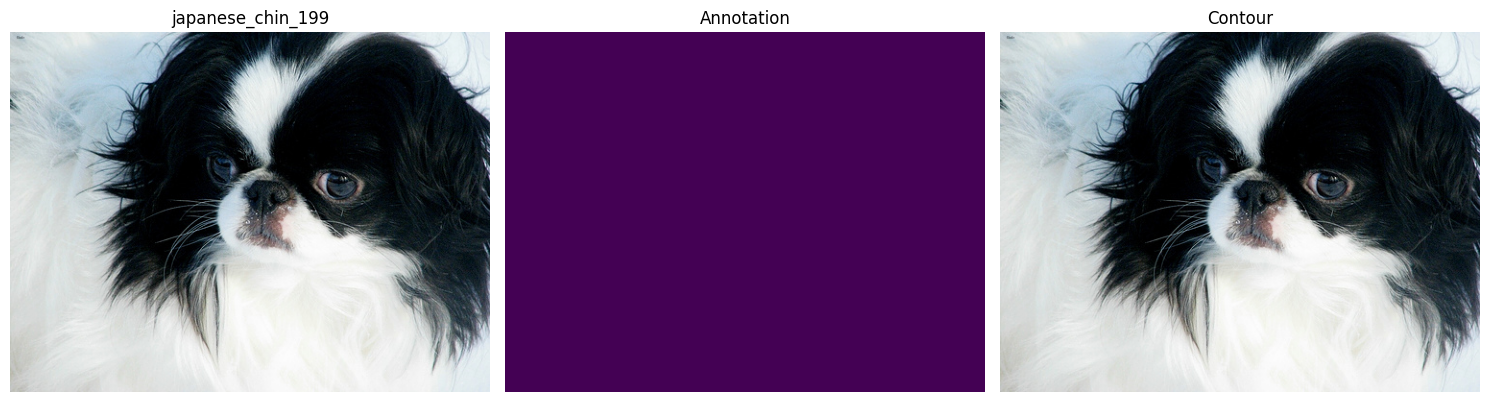

The mask and image have the same size


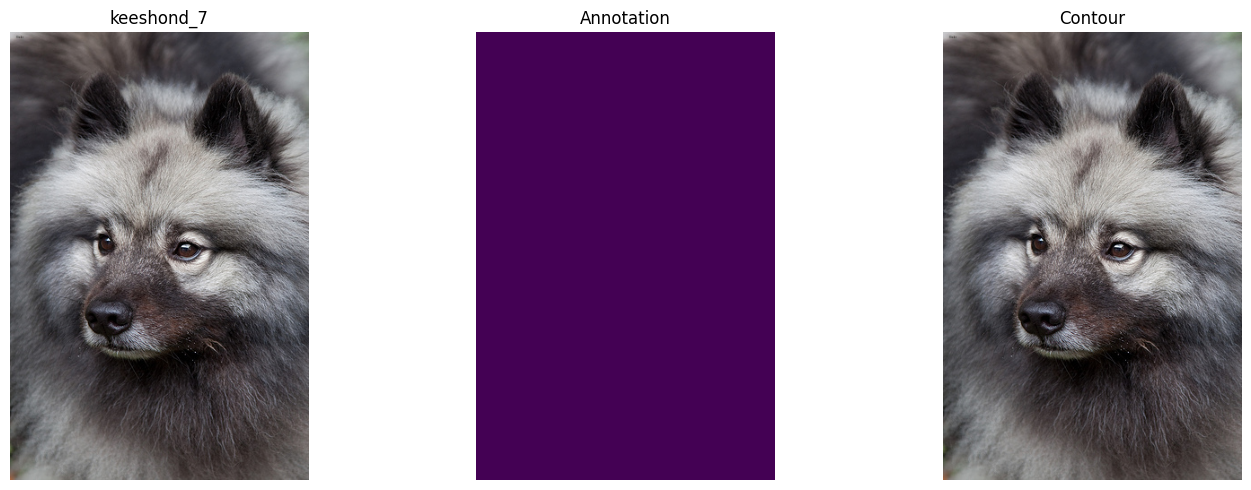

In [24]:
# 3 images with unexpected trimaps
show_image_mask_bbox("miniature_pinscher_14")
show_image_mask_bbox("japanese_chin_199")
show_image_mask_bbox("keeshond_7")


#### Random batches of overlayed images

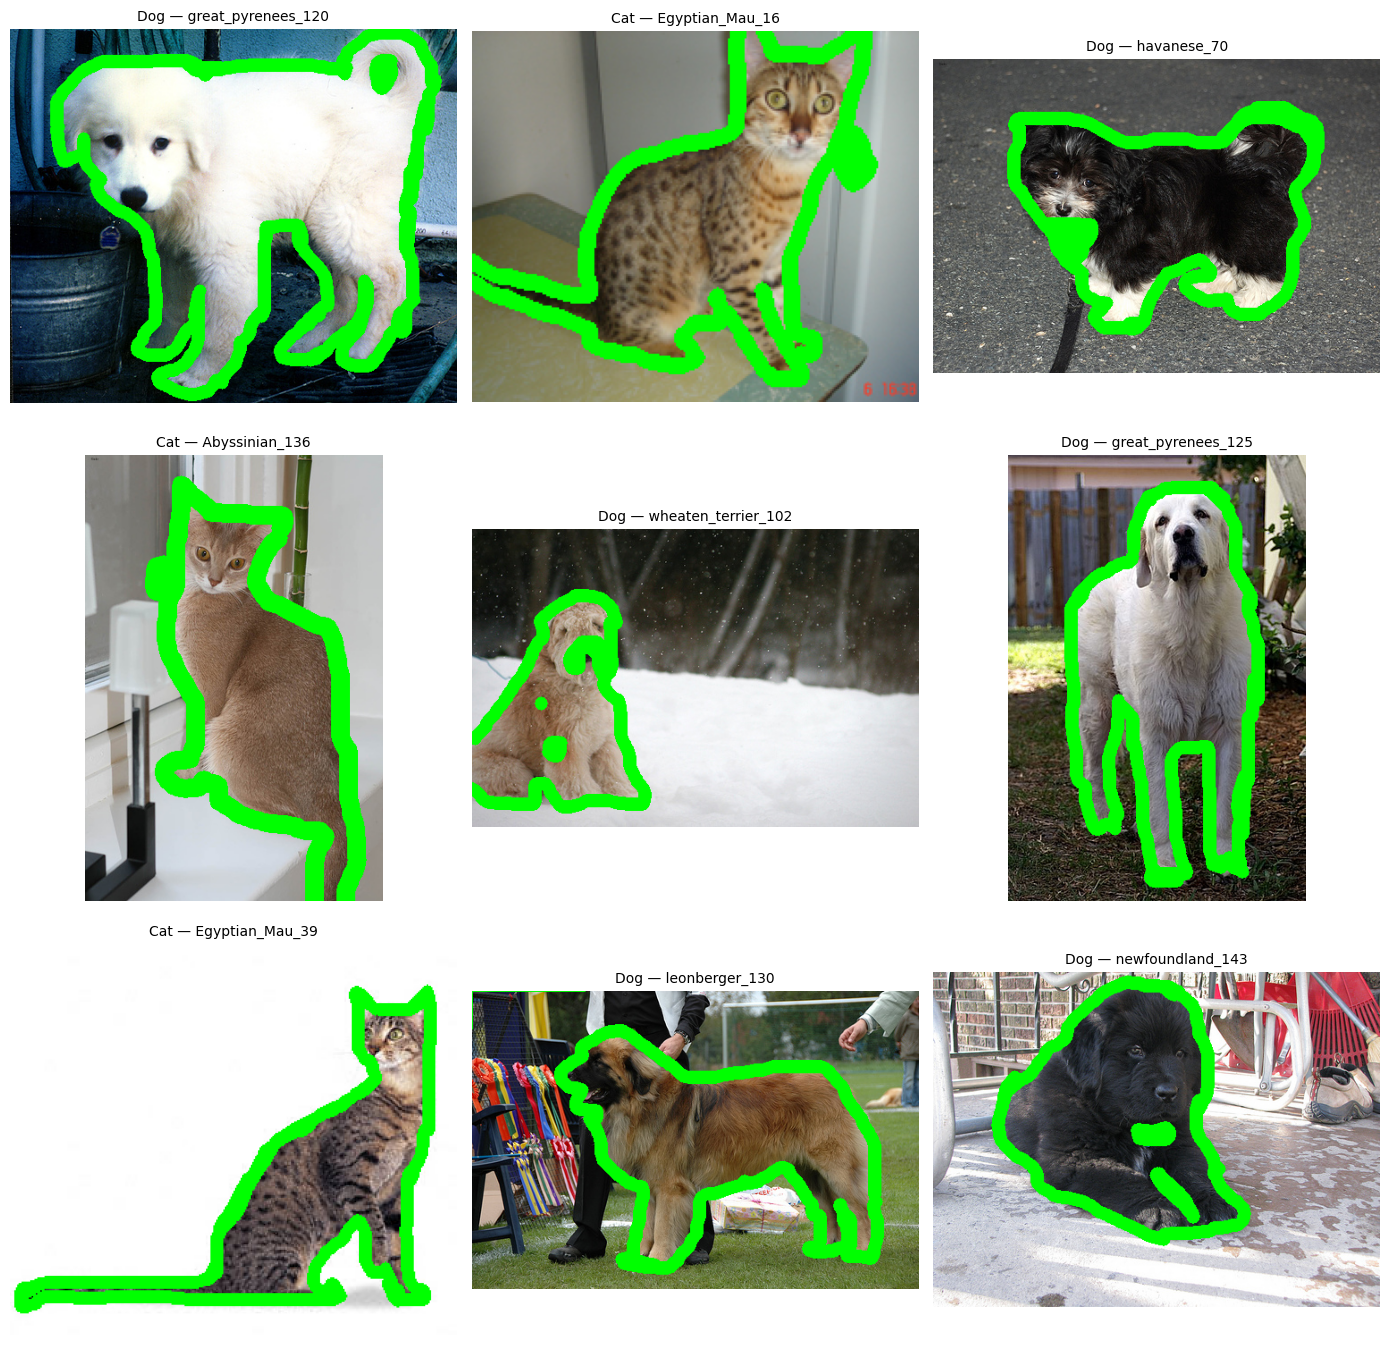

In [25]:
sample_nine = df.sample(9,random_state=-0)
plt.figure(figsize=(14, 14))
for i, (class_id, row) in enumerate(sample_nine.iterrows(), start=1):

    img = Image.open(row["img_path"]).convert("RGB")
    mask = Image.open(row["trimap_path"])

    img_arr = np.array(img)
    mask_arr = np.array(mask)

    overlay = img_arr.copy()
    overlay[mask_arr == 3] = [0, 255, 0] 

    species = row["species_name"].capitalize()    
    breed = row["breed_name"].replace("_", " ").title()   
    title = f"{species} — {class_id}"

    plt.subplot(3, 3, i)
    plt.imshow(overlay)
    plt.title(title, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


- We note that some images are taken indoors (e.g., Abyssinian_136), some outdoors (e.g., leonberger_130), and some against a uniform background (e.g., Egyptian_Mau_39).
- From studying the image masks, we have observed that the masking is done very well. No masks are missing and there is no mask and image mismatch. When drawing random images from the database, we see that the masking includes details such as collars, toys and objects that interfere with the animal. 

### Width and Height analysis

- The .xml files provide the width and height, but as they are missing more nearly half of the images, we need to calculate again the width and height for each image, and update the dataframe.

In [26]:
df.drop(columns=["width", "height"])

widths = []
heights = []

for path in df["img_path"]:
    img = Image.open(path)
    w, h = img.size
    widths.append(w)
    heights.append(h)

df["width"] = widths
df["height"] = heights

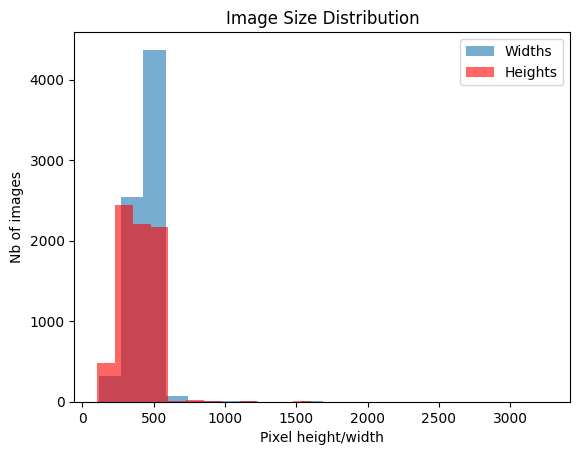

In [27]:
plt.hist(df["width"], bins=20, label= "Widths", alpha= 0.6)
plt.hist(df["height"], bins=20, color = "red", label = "Heights", alpha= 0.6)
plt.title("Image Size Distribution")
plt.xlabel("Pixel height/width")
plt.ylabel("Nb of images")
plt.legend()
plt.show()

In [28]:
# Area (width × height)
area_df = df.dropna(subset=["width", "height"]).copy()

area_df["width"] = area_df["width"].astype(int)
area_df["height"] = area_df["height"].astype(int)

area_df["area"] = area_df["width"] * area_df["height"]
min_area  = area_df["area"].min()
max_area  = area_df["area"].max()
mean_area = area_df["area"].mean()

print(f"Smallest area : {min_area} pixels")
print(f"Largest area  : {max_area} pixels")
print(f"Mean area     : {mean_area:.2f} pixels")


Smallest area : 14111 pixels
Largest area  : 7990272 pixels
Mean area     : 175208.23 pixels


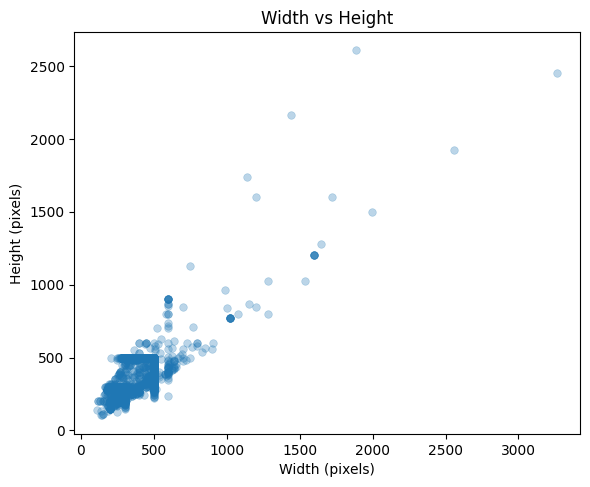

In [29]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    data=df,
    x="width",
    y="height",
    alpha=0.3,
    s=30,
    edgecolor=None
)
plt.title("Width vs Height")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

In [30]:
df.groupby(["width", "height"]).size().sort_values(ascending=False).head(20)

width  height
500    375       1424
       333       1069
375    500        511
333    500        509
300    225        261
500    334        250
       332        185
334    500        151
500    335         97
332    500         91
500    500         88
335    500         53
225    300         49
500    400         39
       281         29
       330         28
       376         27
400    500         27
500    374         27
357    500         26
dtype: int64

- We observe that the size of the images vary significantly. We will have to normalise the image size before training our models in the next sections. 

We will now study bias of the images. Perhaps some breeds are more often photographed outside rather than inside. There could possibly be more background compared to foreground from some breeds as well. The lightning of the images could also differ from breed to breed or between dogs and cats. For this reason, we will study: 

- The average brightness of the images per species and breed. This is quantified by the mean pixel intensity. Source: https://www.thecolorcode.net/post/20/
- The average green intensity per species and breed
- The foreground ratio per species and breed

### Brightness

In [31]:
df["avg_brightness"] = df["class_id"].apply(
    lambda name: np.array(Image.open(f"{PATH_TO_IMG}{name}.jpg").convert("L")).mean()
)

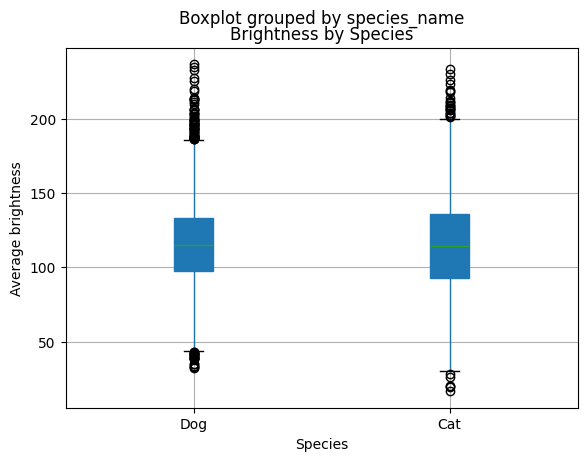

In [32]:
order_label_specie = (
    df.groupby("species_name")["avg_brightness"]
      .median()
      .sort_values(ascending=False)
      .index
)

df["species_name"] = pd.Categorical(df["species_name"],categories=order_label_specie,ordered=True)

df.boxplot(column="avg_brightness",by="species_name",patch_artist=True)

plt.title("Brightness by Species")
plt.xlabel("Species")
plt.ylabel("Average brightness")
plt.show()


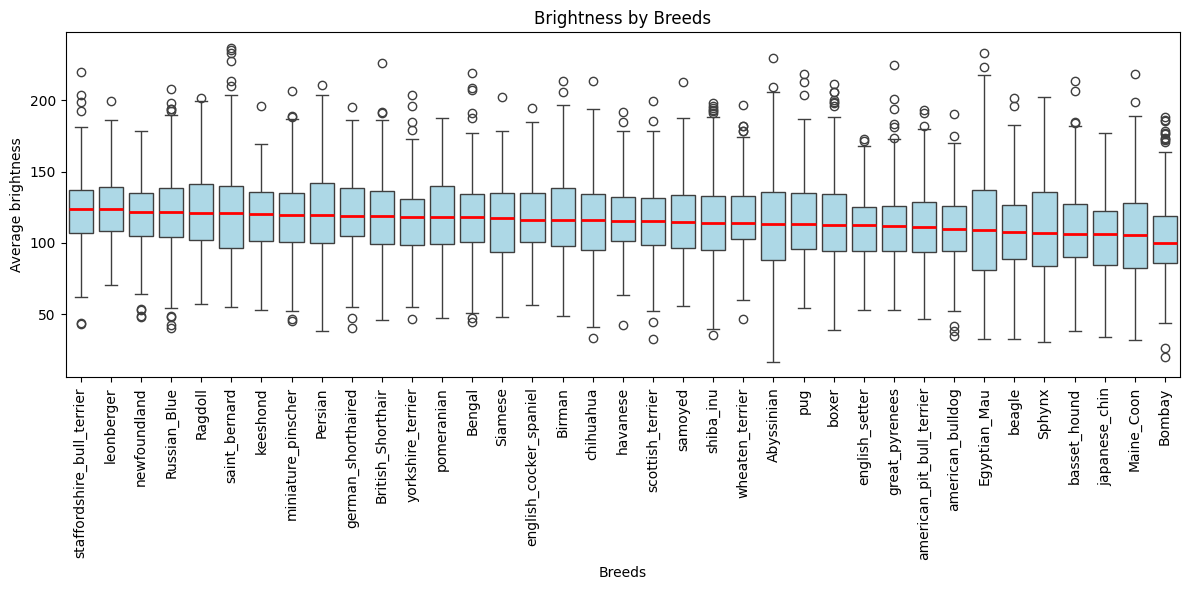

In [33]:
order_label_breed = (
    df.groupby("breed_name")["avg_brightness"]
      .median()
      .sort_values(ascending=False)
      .index
)

plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df,
    x="breed_name",
    y="avg_brightness",
    order=order_label_breed,
    showcaps=True,
    boxprops={"facecolor":"lightblue"},
    medianprops={"color":"red", "linewidth":2},
)

plt.title("Brightness by Breeds")
plt.xlabel("Breeds")
plt.ylabel("Average brightness")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


When observing the average brightness of each species, we see that the average brightness is the highest for staffordshire bull terrier dogs and the lowest for Bombay cats. There is also a sightly higher brightness for images of dogs. This could be because some images of breeds are taken outside or in the sun rather than inside or during the night. 
This could affect our results in several ways: 
- when some breeds are systematically brighter than others, it could be used as a shortcut feature rather than the actual caracteristict of the species/breed. 
- Very bright or very dark images can be harder to perform segmentation on, as it's harder to recognise contrasts and boundaries on them. 

### Green level

In [34]:
def average_green_level(image_name):
    img_path = f"{PATH_TO_IMG}/{image_name}.jpg"
    img = np.array(Image.open(img_path))
    return img[:, :, 1].mean()     # channel 1 = green

df["avg_green"] = df["class_id"].apply(average_green_level)

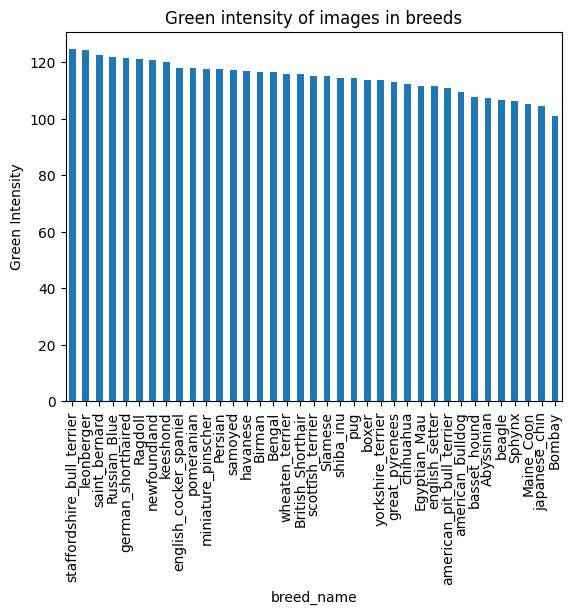

In [35]:
df.groupby("breed_name")["avg_green"].mean().nlargest(37).plot(kind="bar")
plt.title("Green intensity of images in breeds")
plt.ylabel("Green Intensity")
plt.show()

/var/folders/s3/2zd0r2816f51q8xhcynm5c2h0000gn/T/ipykernel_99427/979340843.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("species_name")["avg_green"].mean().plot(kind="bar")


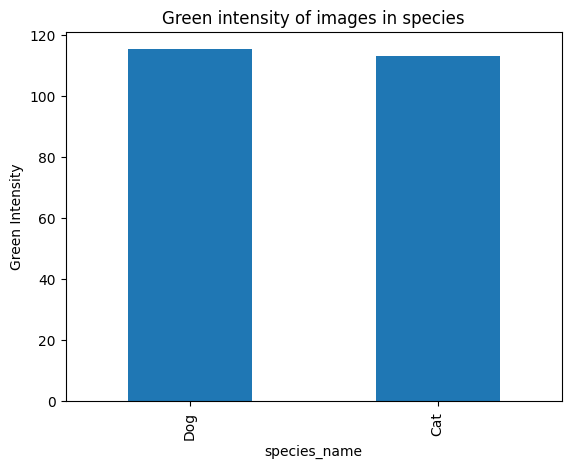

In [36]:
df.groupby("species_name")["avg_green"].mean().plot(kind="bar")
plt.title("Green intensity of images in species")
plt.ylabel("Green Intensity")
plt.show()

We observe that the images of dogs have a higher green intensity than that of cats. Dogs seem to be more likely to be captured next to grass or trees. In the same way as with the brightness, we see that the green intensity is the highest for staffordshire bull terrier dogs and the lowest for Bombay cats.

### Foreground ratio

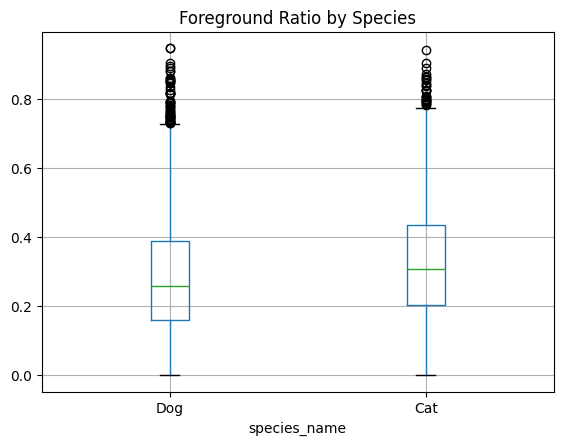

In [37]:
foreground_ratios = []

for _, row in df.iterrows():
    mask_file = f"{row['class_id']}.png"
    mask = np.array(Image.open(f"{PATH_TO_TRIMAPS}/{mask_file}"))
    fg_ratio = (mask == 1).mean()
    foreground_ratios.append(fg_ratio)

df["fg_ratio"] = foreground_ratios

df.boxplot(column="fg_ratio", by="species_name")
plt.title("Foreground Ratio by Species")
plt.suptitle("")
plt.show()

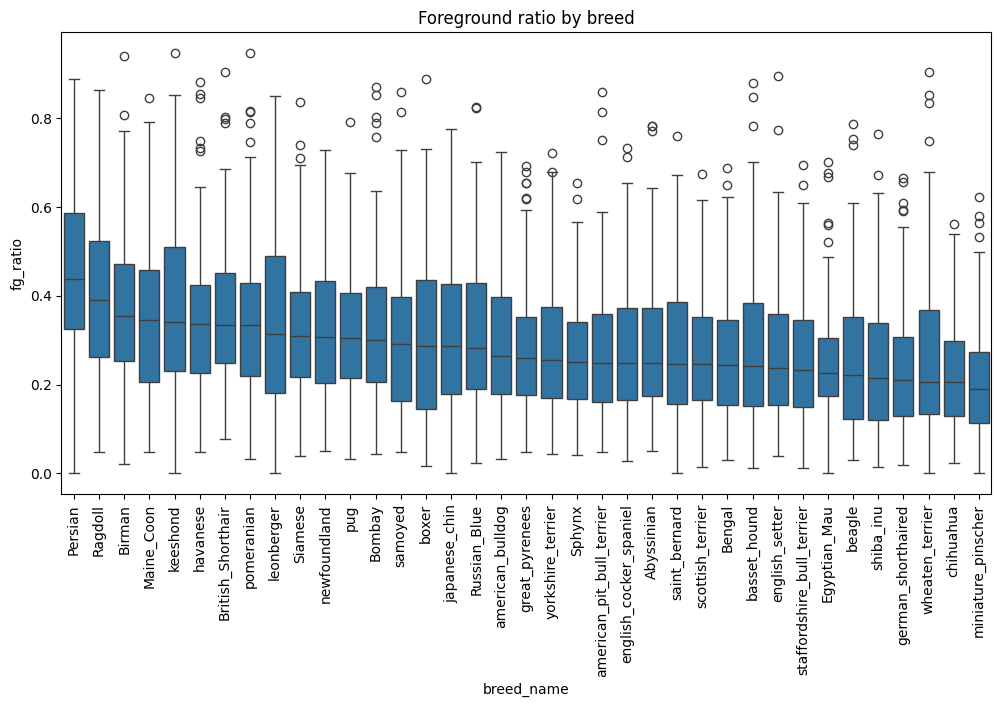

In [38]:
order_label_breed_fg = (
    df.groupby("breed_name")["fg_ratio"].median().sort_values(ascending=False).index
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="breed_name",
    y="fg_ratio",
    order=order_label_breed_fg
)

plt.title("Foreground ratio by breed")
plt.xticks(rotation=90)
plt.show()

We observe that the images of cats have a higher proportion of the actual animal in the images. This could lead to better learning of features for cats, as less of the background can be used as shortcut features. The model can focus on object features. However, it could also be a feature shortcut in itself that images of cats are more "zoomed in", then it could be harder to classify pictures of cats taken from far apart. The fact that be observe clear differences in breeds and species could make our models implicitly learn size-based bias. 

### Conclusion on the Exploratory Data Analysis

From the exploratory analysis of the Oxford-IIIT pet dataset, we have observed that there are several imbalances to take into account. Firstly, there are more images, as well as breeds, of dogs than cats. The proportion of images per breed is almost equally distributed. Secondly, the masks of the dataset are well placed. The bounding boxed typically contain the heads of the animals. Thirdly, we have observed bias in the dataset when it comes to the brightness, the amount of green and how much of the images contain the animal vs. background. Lastly, we have seen that the widt and heights of the images are not equal.  
Because of this, we will normalise the images by size and colour. We will keep the observed biases in mind when analysing the final results. 

-----

### Dataset construction

In [39]:
# Resizing images to 224*224 pixels. This seems to be common for similar projects. 
IMG_SIZE = 224
# We use the mean colours from image net to normalise the colours of the images. 
IMAGE_NET_MEAN = [0.485, 0.456, 0.406]
IMAGE_NET_STD = [0.229, 0.224, 0.225]

In [40]:
train_df = df[df["new_split"] == "train"].reset_index(drop=True)
val_df   = df[df["new_split"] == "val"].reset_index(drop=True)
test_df  = df[df["new_split"] == "test"].reset_index(drop=True)
print(len(train_df), len(val_df), len(test_df))

5879 735 735


In [41]:
train_df.columns

Index(['class_id', 'id', 'species', 'breed_id', 'breed_name', 'species_name',
       'default_split', 'width', 'height', 'depth', 'segmented', 'pose',
       'truncated', 'occluded', 'difficult', 'bb_xmin', 'bb_ymin', 'bb_xmax',
       'bb_ymax', 'xml_path', 'img_path', 'trimap_path', 'new_split',
       'avg_brightness', 'avg_green', 'fg_ratio'],
      dtype='object')

In [42]:
train_classes = set(train_df["breed_id"].unique())
val_classes   = set(val_df["breed_id"].unique())

print("Nombre de classes dans train :", len(train_classes))
print("Nombre de classes dans val   :", len(val_classes))

missing_in_val = sorted(train_classes - val_classes)
missing_in_train = sorted(val_classes - train_classes)

print("Classes ABSENTES du validation :", missing_in_val)
print("Classes ABSENTES de l'entraînement :", missing_in_train)


Nombre de classes dans train : 25
Nombre de classes dans val   : 25
Classes ABSENTES du validation : []
Classes ABSENTES de l'entraînement : []


In [43]:
train_classes = set(train_df["id"].unique())
val_classes   = set(val_df["id"].unique())

print("Nombre de classes dans train :", len(train_classes))
print("Nombre de classes dans val   :", len(val_classes))

Nombre de classes dans train : 37
Nombre de classes dans val   : 37


In [44]:
class PetDataset(Dataset):
    def __init__(self, df, task="binary", transform=None):
        """
        task = "binary" (0=cat, 1=dog) (binary classification)
        task = "multiclass"   (0..36) (multiclass classification)
        task = "segmentation" (returns mask + image)
        """
        self.df = df
        self.task = task
        self.transform = transform
        
        # To remove the 14 images without trimaps when doing segmentation
        if task == "segmentation":
            self.df = self.df[self.df["trimap_path"].notna()].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image = Image.open(row["img_path"]).convert("RGB")
        filename = os.path.basename(row["img_path"])

        if self.task == "binary":
            label = row["species"]    # 0=cat, 1=dog

        elif self.task == "multiclass":
            label = row["id"]   # 0..36

        elif self.task == "segmentation":
            mask = Image.open(row["trimap_path"])

            if self.transform is not None :
                image, mask = self.transform(image, mask)
                return image, mask # (C,H,W) float, (H,W) long
            
            #if no transform
            image = TF.to_tensor(image)
            image = TF.normalize(image, mean=IMAGE_NET_MEAN, std = IMAGE_NET_STD)
            mask = torch.from_numpy(np.array(mask)).long() - 1
            return image, mask
    
        # Transformation (for classification only)
        if self.transform:
            image = self.transform(image)

        return image, label, filename
    


### Default classification tranform

In [45]:
train_transform = T.Compose([
    T.Resize((IMG_SIZE,IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean = IMAGE_NET_MEAN,
                std = IMAGE_NET_STD),
])

val_transform = T.Compose([
    T.Resize((IMG_SIZE,IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean = IMAGE_NET_MEAN,
                std = IMAGE_NET_STD),
])

train_transform_aug = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2,
                  saturation=0.2, hue=0.02),
    T.RandomRotation(degrees=10),
    T.ToTensor(),
    T.Normalize(mean=IMAGE_NET_MEAN, std=IMAGE_NET_STD),
])


### Binary classification instantiation

In [46]:
train_binary_clf = PetDataset(train_df, task="binary", transform=train_transform) #without augmentation
train_binary_clf_aug = PetDataset(train_df, task="binary", transform=train_transform_aug) #with augmentation

val_binary_clf  = PetDataset(val_df, task="binary", transform=val_transform)
test_binary_clf  = PetDataset(test_df, task="binary", transform=val_transform)

In [47]:
train_loader_binary_clf = DataLoader(train_binary_clf, batch_size=32, shuffle=True,  num_workers=0) #without aug
train_loader_binary_clf_aug =  DataLoader(train_binary_clf_aug, batch_size=32, shuffle=True,  num_workers=0) #with aug

val_loader_binary_clf   = DataLoader(val_binary_clf,   batch_size=32, shuffle=False, num_workers=0)

### Multiclass classification instantiation

In [48]:
train_multi_clf = PetDataset(train_df, task="multiclass", transform=train_transform) #without augmentation
train_multi_clf_aug = PetDataset(train_df, task="multiclass", transform=train_transform_aug) #with augmentation

val_multi_clf   = PetDataset(val_df, task="multiclass", transform=val_transform)
test_multi_clf  = PetDataset(test_df, task="multiclass", transform=val_transform)

In [49]:
train_loader_multi_clf= DataLoader(train_multi_clf, batch_size=32, shuffle=True,  num_workers=0)
train_loader_multi_clf_aug = DataLoader(train_multi_clf_aug, batch_size=32, shuffle=True,  num_workers=0)

val_loader_multi_clf   = DataLoader(val_multi_clf,   batch_size=32, shuffle=False, num_workers=0)

### Segmentation instantiation

In [50]:
def seg_train_transform(image, mask):
    # 1) Resize image and mask to same size
    image = TF.resize(image, (IMG_SIZE, IMG_SIZE))
    mask  = TF.resize(
        mask,
        (IMG_SIZE, IMG_SIZE),
        interpolation=InterpolationMode.NEAREST  # important for labels
    )

    # 2) Geometric augmentations (same for image & mask)

    # Horizontal flip with p=0.5
    if random.random() < 0.5:
        image = TF.hflip(image)
        mask  = TF.hflip(mask)

    # Small random rotation with p=0.3
    if random.random() < 0.3:
        angle = random.uniform(-10, 10)
        image = TF.rotate(image, angle)
        mask  = TF.rotate(mask, angle, interpolation=InterpolationMode.NEAREST)

    # 3) Convert image to tensor + normalize
    image = TF.to_tensor(image)
    image = TF.normalize(image, mean=IMAGE_NET_MEAN, std=IMAGE_NET_STD)

    # 4) Convert mask to tensor of class indices
    mask_np = np.array(mask).astype(np.int64)

    # Oxford Pets trimaps are usually {1, 2, 3} → convert to {0, 1, 2}
    mask_np = mask_np - 1
    mask = torch.from_numpy(mask_np).long()

    return image, mask

def seg_val_transform(image, mask):
    # 1) Resize
    image = TF.resize(image, (IMG_SIZE, IMG_SIZE))
    mask  = TF.resize(
        mask,
        (IMG_SIZE, IMG_SIZE),
        interpolation=InterpolationMode.NEAREST
    )

    # 2) To tensor + normalize (image only)
    image = TF.to_tensor(image)
    image = TF.normalize(image, mean=IMAGE_NET_MEAN, std=IMAGE_NET_STD)

    # 3) Mask to class indices
    mask_np = np.array(mask).astype(np.int64)
    mask_np = mask_np - 1
    mask = torch.from_numpy(mask_np).long()

    return image, mask



In [51]:
train_seg = PetDataset(train_df, task="segmentation", transform=seg_train_transform)
val_seg   = PetDataset(val_df,   task="segmentation", transform=seg_val_transform)
test_seg  = PetDataset(test_df,  task="segmentation", transform=seg_val_transform)

In [52]:
BATCH_SIZE_SEG = 8
train_loader_seg = DataLoader(train_seg, batch_size=BATCH_SIZE_SEG, shuffle=True,  num_workers=0)
val_loader_seg   = DataLoader(val_seg,   batch_size=BATCH_SIZE_SEG, shuffle=False, num_workers=0)
test_loader_seg  = DataLoader(test_seg,  batch_size=BATCH_SIZE_SEG, shuffle=False, num_workers=0)


### Functions

In [53]:
def plot_train_val_loss(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(6, 6))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_accuracy(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(6, 6))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()


def classification_metrics(y_true, y_prob, class_names=None, threshold=0.5):
    """
    Works for both binary and multiclass classification.

    Assumptions:
    - y_true are integer class labels in {0, 1, ..., n_classes-1}
    - y_prob can be:
        * shape (N,)  -> probability of the positive class in binary case
        * shape (N,1) -> same as above
        * shape (N,C) -> class probabilities for C classes
    """

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # ---------- Standardize y_prob to 2D ----------
    if y_prob.ndim == 1:
        # Assume binary, y_prob is P(class 1)
        y_prob_pos = y_prob
        y_prob = np.column_stack([1 - y_prob_pos, y_prob_pos])  # (N, 2)
    elif y_prob.ndim == 2 and y_prob.shape[1] == 1:
        # (N,1) -> (N,2)
        y_prob_pos = y_prob[:, 0]
        y_prob = np.column_stack([1 - y_prob_pos, y_prob_pos])  # (N, 2)
    # else: assume already (N, n_classes)

    n_samples, n_classes = y_prob.shape

    # ---------- Class names ----------
    if class_names is None:
        # assume labels are 0..n_classes-1
        class_names = [str(i) for i in range(n_classes)]

    # ---------- Predictions & ROC AUC ----------
    if n_classes == 2:
        # Binary: use probability of class 1 (positive class)
        y_scores_pos = y_prob[:, 1]
        y_pred = (y_scores_pos >= threshold).astype(int)
        roc_auc = roc_auc_score(y_true, y_scores_pos)
    else:
        # Multiclass: argmax
        y_pred = np.argmax(y_prob, axis=1)
        roc_auc = roc_auc_score(y_true, y_prob, multi_class="ovr")

    # ---------- Confusion matrix & classification report ----------
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=3,
    )

    # ---------- Per-class PR curves & AP ----------
    precision = {}
    recall = {}
    pr_thresholds = {}
    ap = {}

    # y_true must be in 0..n_classes-1 for this to work
    y_true_bin = np.eye(n_classes)[y_true]  # shape (N, n_classes)

    for i, cname in enumerate(class_names):
        precision[cname], recall[cname], pr_thresholds[cname] = precision_recall_curve(
            y_true_bin[:, i], y_prob[:, i]
        )
        ap[cname] = average_precision_score(y_true_bin[:, i], y_prob[:, i])

    return {
        "confusion_matrix": cm,
        "classification_report": report,
        "roc_auc": roc_auc,
        "precision": precision,           # dict: class_name -> array
        "recall": recall,                 # dict: class_name -> array
        "pr_thresholds": pr_thresholds,   # dict: class_name -> array
        "average_precision": ap,          # dict: class_name -> scalar
    }



def classification_metrics_multiclass(y_true, y_prob, class_names=None):
    """
    Metrics for multiclass classification.

    Assumptions:
    - y_true are integer class labels in {0, 1, ..., n_classes-1}
    - y_prob has shape (N, C) with C = number of model classes,
      and columns correspond to class indices 0..C-1 in that order.
    """

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    if y_prob.ndim != 2:
        raise ValueError(
            f"Expected y_prob to have shape (N, C) for multiclass, got shape {y_prob.shape}"
        )

    n_samples, n_classes = y_prob.shape

    # ---------- Class names ----------
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]
    else:
        assert len(class_names) == n_classes, \
            f"len(class_names)={len(class_names)} does not match n_classes={n_classes}"

    # ---------- Predictions ----------
    y_pred = np.argmax(y_prob, axis=1)

    # ---------- Confusion matrix & classification report ----------
    cm = confusion_matrix(y_true, y_pred)

    report = classification_report(
        y_true,
        y_pred,
        labels=np.arange(n_classes),   # force all classes 0..C-1
        target_names=class_names,
        digits=3,
        zero_division=0,
    )

    # ---------- Multiclass ROC AUC (macro, One-vs-Rest) ----------
    try:
        roc_auc_macro_ovr = roc_auc_score(
            y_true,
            y_prob,
            multi_class="ovr",
            average="macro",
            labels=np.arange(n_classes),
        )
    except ValueError:
        roc_auc_macro_ovr = None

    # ---------- Per-class PR curves & AP ----------
    precision = {}
    recall = {}
    pr_thresholds = {}
    ap_per_class = {}

    # y_true one-hot
    y_true_bin = np.eye(n_classes)[y_true]  # shape (N, n_classes)

    for i, cname in enumerate(class_names):
        precision[cname], recall[cname], pr_thresholds[cname] = precision_recall_curve(
            y_true_bin[:, i], y_prob[:, i]
        )
        ap_per_class[cname] = average_precision_score(
            y_true_bin[:, i], y_prob[:, i]
        )

    # Macro-average AP
    average_precision_macro = float(np.mean(list(ap_per_class.values())))

    # For compatibility with save_model_and_results:
    # - "roc_auc" will be the macro OVR ROC AUC
    # - "average_precision" will be the per-class AP dict
    return {
        "confusion_matrix": cm,
        "classification_report": report,
        "roc_auc_macro_ovr": roc_auc_macro_ovr,
        "precision": precision,
        "recall": recall,
        "pr_thresholds": pr_thresholds,
        "average_precision_per_class": ap_per_class,
        "average_precision_macro": average_precision_macro,
        # keys expected by save_model_and_results
        "roc_auc": roc_auc_macro_ovr,
        "average_precision": ap_per_class,
    }



def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(12,12))
    sns.heatmap(
        cm,
        annot=False,
        #fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label="ROC")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_pr_curve(y_true, y_prob, title="Precision–Recall Curve"):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    plt.figure(figsize=(6,6))
    plt.plot(recall, precision, label=f"PR (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [54]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels, _ in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels, _ in tqdm(loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)

            probs = F.softmax(outputs, dim=1)[:, 1]  # probability of class "1" (dog)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    avg_loss = total_loss / total
    acc = correct / total

    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    return avg_loss, acc, all_labels, all_probs

def evaluate_multiclass(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels, _ in tqdm(loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)

            # MULTICLASS: keep ALL class probabilities
            probs = F.softmax(outputs, dim=1)   # shape [B, num_classes]
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    avg_loss = total_loss / total
    acc = correct / total

    all_labels = np.concatenate(all_labels)     # shape [N]
    all_probs = np.concatenate(all_probs)       # shape [N, num_classes]

    return avg_loss, acc, all_labels, all_probs



In [55]:
def denormalize_image(tensor):
    """Undo normalization so we can display the image."""
    img = tensor.cpu().numpy().transpose(1,2,0)
    img = img * IMAGE_NET_STD + IMAGE_NET_MEAN
    img = np.clip(img, 0, 1)
    return img

def show_random_classif_predictions(model, dataset, device, class_names, num_images=9):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)

    # Adapt grid size for visualization (e.g., square root)
    grid_size = int(num_images ** 0.5)
    plt.figure(figsize=(grid_size * 4, grid_size * 4))

    for i, idx in enumerate(indices):
        img, label, filename = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(img_tensor)
            probs = F.softmax(logits, dim=1)[0]  # shape: [num_classes]
            pred = torch.argmax(probs).item()

        img_vis = denormalize_image(img)

        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img_vis)
        plt.axis("off")

        # Compose prediction probabilities string for all classes
        prob_str = ", ".join([f"P_{name}={probs[j]:.2f}" for j, name in enumerate(class_names)])

        pred_name = class_names[pred]
        true_name = class_names[label]

        title = (
            f"{filename}\n"
            f"Pred: {pred_name}\n"
            f"{prob_str}\n"
            f"True: {true_name}"
        )

        plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

def show_random_classif_predictions_topk(
    model,
    dataset,
    device,
    class_names,
    num_images=9,
    k=3,
):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)

    # compute grid size more robustly
    grid_size = int(np.ceil(num_images ** 0.5))
    plt.figure(figsize=(grid_size * 4, grid_size * 4))

    for i, idx in enumerate(indices):
        img, label, filename = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(img_tensor)
            probs = F.softmax(logits, dim=1)[0]  # shape: [num_classes]
            pred = torch.argmax(probs).item()

        img_vis = denormalize_image(img)

        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img_vis)
        plt.axis("off")

        # top-k predictions
        topk_vals, topk_idx = torch.topk(probs, k)
        topk_vals = topk_vals.cpu().numpy()
        topk_idx = topk_idx.cpu().numpy()

        topk_str_lines = []
        for rank, (cidx, p) in enumerate(zip(topk_idx, topk_vals), start=1):
            cname = class_names[cidx]
            topk_str_lines.append(f"{rank}) {cname}: {p:.2f}")

        pred_name = class_names[pred]
        true_name = class_names[label]

        title = (
            f"{filename}\n"
            f"Pred: {pred_name} | True: {true_name}\n"
            + "\n".join(topk_str_lines)
        )

        plt.title(title, fontsize=9)

    plt.tight_layout()
    plt.show()


In [56]:
def decode_segmentation_mask(mask):
    """
    mask: (H, W) tensor or numpy, values in {0,1,2}
    returns: (H, W, 3) uint8 color image
    """
    if torch.is_tensor(mask):
        mask = mask.cpu().numpy()

    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    palette = {
        0: (0,   0,   0),    # background 
        1: (255, 182,  193),    # pet       
        2: (0,   255, 0),    # border     
    }

    for cls_id, color in palette.items():
        color_mask[mask == cls_id] = color

    return color_mask


def visualize_segmentation_predictions(model, loader, device, num_images=5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs  = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)               # (B, C, H, W)
            preds   = outputs.argmax(dim=1)     # (B, H, W)

            batch_size = imgs.size(0)

            for i in range(batch_size):
                if images_shown >= num_images:
                    return

                img  = imgs[i]
                gt   = masks[i]
                pred = preds[i]

                img_np  = denormalize_image(img)
                gt_np   = decode_segmentation_mask(gt)
                pred_np = decode_segmentation_mask(pred)

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.imshow(img_np)
                plt.axis("off")
                plt.title("Input image")

                plt.subplot(1, 3, 2)
                plt.imshow(gt_np)
                plt.axis("off")
                plt.title("Ground truth")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_np)
                plt.axis("off")
                plt.title("Prediction")

                plt.tight_layout()
                plt.show()

                images_shown += 1

### Function to load models

In [57]:
os.makedirs("models", exist_ok=True)

In [58]:
def save_model_and_results(
    save_dir: str,
    model: torch.nn.Module,
    history: dict,
    y_true: np.ndarray,
    y_prob: np.ndarray,
    metrics: dict,
    model_filename: str = "model_weights.pth",
):
    # Create the full directory path you passed
    os.makedirs(save_dir, exist_ok=True)

    # --- Save model weights ---
    model_path = os.path.join(save_dir, model_filename)
    torch.save(model.state_dict(), model_path)

    # --- Save training history ---
    pd.DataFrame(history).to_csv(
        os.path.join(save_dir, "training_history.csv"),
        index=False
    )

    # --- Save prediction arrays ---
    np.save(os.path.join(save_dir, "y_true.npy"), y_true)
    np.save(os.path.join(save_dir, "y_prob.npy"), y_prob)

    # --- Save confusion matrix ---
    np.save(
        os.path.join(save_dir, "confusion_matrix.npy"),
        metrics["confusion_matrix"]
    )

    # --- Save metrics.json ---
    avg_prec = metrics["average_precision"]
    if isinstance(avg_prec, dict):
        # multiclass: already per-class, JSON-serializable
        avg_prec_json = avg_prec
    else:
        # binary: single float
        avg_prec_json = float(avg_prec)

    metrics_for_json = {
        "roc_auc": float(metrics["roc_auc"]),
        "classification_report": metrics["classification_report"],
        "average_precision": avg_prec_json,
    }

    with open(os.path.join(save_dir, "metrics.json"), "w") as f:
        json.dump(metrics_for_json, f, indent=4)

    print(f"\nArtifacts saved to: {save_dir}")



In [59]:
def load_model_and_results(
    save_dir: str,
    model: torch.nn.Module,
    device: str,
    model_filename: str = "model_weights.pth",
):
    # --- Load model ---
    model_path = os.path.join(save_dir, model_filename)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    # --- Load history ---
    history_df = pd.read_csv(os.path.join(save_dir, "training_history.csv"))

    # --- Load predictions ---
    y_true = np.load(os.path.join(save_dir, "y_true.npy"))
    y_prob = np.load(os.path.join(save_dir, "y_prob.npy"))

    # --- Load confusion matrix ---
    cm = np.load(os.path.join(save_dir, "confusion_matrix.npy"))

    # --- Load metrics.json ---
    with open(os.path.join(save_dir, "metrics.json"), "r") as f:
        metrics_json = json.load(f)

    return model, history_df, y_true, y_prob, cm, metrics_json

## 2 - Binary (Species) Classification

### Plan

- [En cours] Simple CNN sans augmentation, sans ré-équilibrage des classes dans la loss
- [To do] Simple CNN sans augmentation, avec ré-équilibrage des classes dans la loss
- [To do] Simple CNN avec augmentation (avec ré-équilibrage directement ?) (--> à voir en fonction des résultats précedents)
- [To do] Modèle pré-entraîné sans augmentation (avec ré-équilibrage directement ?) (--> à voir en fonction des résultats précedents)
- [To do] Modèle pré-entraîné avec augmentation (avec ré-équilibrage directement ?) (--> à voir en fonction des résultats précedents)

- Justifier choix optimizer, loss, hyperparameteres
- Présenter les metrique à utiliser
- Confusion matrix
- Visualiser les loss (fixer 30 epochs ?)
- Visualiser les bonnes prédictions, les erreurs
- (si le temps) : Grad-CAM sur quelques images ?

### 2.1 - Binary Classification : CNN, Without augmentation

In [ ]:
binary_target_names = ["Cat","Dog"]
binary_class_names = ("Cat", "Dog")

In [ ]:
class CNN_V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512, 512)
        self.gap = nn.AdaptiveAvgPool2d((1, 1)) #global average pooling
        self.fc2 = nn.Linear(512, 2)  # binary classif

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 224 -> 112
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 112 -> 56
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 56 -> 28
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # 28 --> 14

        x = self.gap(x) # [B, 512, 1, 1]                       
        x = x.view(x.size(0), -1) # [B, 512]            
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

#### 2.1.1 - Binary Classification : CNN, Without augmentation, No Class Weight

##### Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}") # mps is for macs with Apple Silicon

model_cnn_noaug_noclassweight = CNN_V1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn_noaug_noclassweight.parameters(), lr=1e-4, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) #every 10 epoch, the lr is divided by 10

In [ ]:
history_cnn_noaug_noclassweight = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(3):
    train_loss, train_acc = train_one_epoch(
        model_cnn_noaug_noclassweight,
        train_loader_binary_clf,
        optimizer, criterion, device
    )
    
    val_loss, val_acc, y_true, y_prob = evaluate(
        model_cnn_noaug_noclassweight,
        val_loader_binary_clf,
        criterion, device
    )

    #scheduler.step()

    history_cnn_noaug_noclassweight["train_loss"].append(train_loss)
    history_cnn_noaug_noclassweight["train_acc"].append(train_acc)
    history_cnn_noaug_noclassweight["val_loss"].append(val_loss)
    history_cnn_noaug_noclassweight["val_acc"].append(val_acc)


    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")

# Final eval, after training
val_loss, val_acc, last_y_true, last_y_prob = evaluate(
        model_cnn_noaug_noclassweight,
        val_loader_binary_clf,
        criterion, device
    )

y_true, y_prob = last_y_true, last_y_prob
metrics_cnn_noaug_noclassweight = classification_metrics(y_true,y_prob)

##### Save model weights, training info

In [ ]:
save_model_and_results(
    save_dir="models/cnn_binary_noaug_nocw_noscheduler_test3epoch",
    model=model_cnn_noaug_noclassweight,
    history=history_cnn_noaug_noclassweight,
    y_true=y_true,
    y_prob=y_prob,
    metrics=metrics_cnn_noaug_noclassweight,
    model_filename="cnn_binary_noaug_nocw_noscheduler_test3epoch.pth"
)

##### Results (Losses & Metrics)

In [ ]:
model_cnn_noaug_noclassweight, history_cnn_noaug_noclassweight_df, y_true, y_prob, cm, metrics_cnn_noaug_noclassweight_json = load_model_and_results(
    save_dir="models/cnn_binary_noaug_nocw_noscheduler_test3epoch",
    model=model_cnn_noaug_noclassweight,
    device=device,
    model_filename="cnn_binary_noaug_nocw_noscheduler_test3epoch.pth",
)

In [ ]:
print("\n -- Classification report --")
print(metrics_cnn_noaug_noclassweight_json["classification_report"])
print("ROC AUC:", metrics_cnn_noaug_noclassweight_json["roc_auc"])
print("AP (PR AUC):", metrics_cnn_noaug_noclassweight_json["average_precision"])

plot_train_val_loss(history_cnn_noaug_noclassweight_df)
plot_accuracy(history_cnn_noaug_noclassweight_df)
plot_confusion_matrix(cm, ("Cat","Dog"))
plot_roc_curve(y_true, y_prob, title="ROC Curve – CNN no aug, no class weights")
plot_pr_curve(y_true, y_prob, title="PR Curve – CNN no aug, no class weights")


##### Results (Predictions)

In [ ]:
# Predictions on the validation set
show_random_classif_predictions(model_cnn_noaug_noclassweight, val_binary_clf, device, class_names=binary_target_names)

In [ ]:
# Predictions on the test set
show_random_classif_predictions(model_cnn_noaug_noclassweight, test_binary_clf, device, class_names=binary_target_names)


| Task | Criterion | Optimizer | LR Scheduler | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | ROC AUC | PR AUC (AP) | Precision Cat | Recall Cat | Precision Dog | Recall Dog | F1-Score Cat | F1-Score Dog |Macro Precision | Macro Recall | Macro F1 |
|------|-----------|-----------|--------|-----------|-----------|--------------|--------|------------|----------|-----------|----------|----------|--------------|----------------|-------------|----------------|-------------|---------------|----------------| ----------------| ----------------|
| Binary Clf | CrossEntropyLoss | Adam (lr=1e-4, wd=1e-4) | No | CNN_V1 | None | 30 | 0.1661 | 0.3793 | 0.933 | 0.848 | 0.924 | 0.963 | 0.709 | 0.843 | 0.926 | 0.850 | 0.770 | 0.886 | 0.817 | 0.846 | 0.828 |
| Binary Clf | CrossEntropyLoss | Adam (lr=1e-4, wd=1e-4) | step_size=10, gamma = 0.1 | CNN_V1 | None | 30 | 0.3440 | 0.4041 | 0.856 | 0.822 | 0.871 | 0.939 | 0.728 | 0.659 | 0.857 | 0.893 | 0.692 | 0.875 | NA | NA | NA |



Dogs misclassified as Cats (non exhaustive list) :
- shiba_inu_53 (test set)
- boxer_61 (test set)

Cats misclassified as Dogs (non exhaustive list) : 
- Russian_blue_118 (validation set)

Comments on the metrics :
* Val. accuracy : 84.8%, strong baseline
* Macro F1 : 0.828 -> balanced performance across both classes
* ROC AUC : 0.924 -> the model distinguishes well both classes
* PR AUC (AP) : 0.964 -> the model makes highly confident predictions for the positive class
* Cat/Dog Precision : 0.709 vs 0.926 -> the model makes more mistakes when predicting "Cat", very few false positives when predicting "Dog"
* Cat/Dog Recall : 0.843 vs 0.850 -> the model catches most cats/dogs but with moderate false positives

* Cats are the minority class, the model is biased toward predicting Dog. As Dogs dominate the training set, the model fits this class easily.
* High precision shows better discrimination feature for dogs

Comments on the losses : 
* Training loss decreases smoothly (down to 0.166), showing stable convergence.
* Validation loss is noisy but remains reasonable
* Growing train/val gap indicates a bit of overfitting but good overall generalization.
* With the StepLR scheduler, the training loss decreases much more slowly and ends significantly higher (0.344), and the validation loss does not improve.
* StepLR worsened performance because reducing LR too early prevents Adam from exploring the loss landscape.


#### 2.1.2 - Binary Classification : CNN, Without augmentation, With Class Weight

In [ ]:
print("Train (%)")
print(train_df["species_name"].value_counts(normalize=True) * 100, "\n")

print("Val (%)")
print(val_df["species_name"].value_counts(normalize=True) * 100, "\n")

print("Test (%)")
print(test_df["species_name"].value_counts(normalize=True) * 100, "\n")


##### Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}") # mps is for macs with Apple Silicon

model_cnn_noaug_classweight = CNN_V1().to(device)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=train_df["species"].values
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model_cnn_noaug_classweight.parameters(), lr=1e-4, weight_decay=1e-4)
# we don't use a lr schedulre here

In [ ]:
history_cnn_noaug_classweight = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(3):
    train_loss, train_acc = train_one_epoch(
        model_cnn_noaug_classweight,
        train_loader_binary_clf,
        optimizer, criterion, device
    )
    
    val_loss, val_acc, y_true, y_prob = evaluate(
        model_cnn_noaug_classweight,
        val_loader_binary_clf,
        criterion, device
    )

    #scheduler.step() #we don't use a lr scheduler here

    history_cnn_noaug_classweight["train_loss"].append(train_loss)
    history_cnn_noaug_classweight["train_acc"].append(train_acc)
    history_cnn_noaug_classweight["val_loss"].append(val_loss)
    history_cnn_noaug_classweight["val_acc"].append(val_acc)


    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")

# Final eval, after training
val_loss, val_acc, last_y_true, last_y_prob = evaluate(
        model_cnn_noaug_classweight,
        val_loader_binary_clf,
        criterion, device
    )

y_true, y_prob = last_y_true, last_y_prob
metrics_cnn_noaug_classweight = classification_metrics(y_true,y_prob)

##### Save model weights, training info

In [ ]:
save_model_and_results(
    save_dir="models/cnn_binary_noaug_cw_test3epoch",
    model=model_cnn_noaug_classweight,
    history=history_cnn_noaug_classweight,
    y_true=y_true,
    y_prob=y_prob,
    metrics=metrics_cnn_noaug_classweight,
    model_filename="cnn_binary_noaug_cw_test3epoch.pth"
)

##### Results (Losses & Metrics)

In [ ]:
model_cnn_noaug_classweight, history_cnn_noaug_classweight_df, y_true, y_prob, cm, metrics_cnn_noaug_classweight_json = load_model_and_results(
    save_dir="models/cnn_binary_noaug_cw_test3epoch",
    model=model_cnn_noaug_classweight,
    device=device,
    model_filename="cnn_binary_noaug_cw_test3epoch.pth",
)

In [ ]:
print("\n -- Classification report --")
print(metrics_cnn_noaug_classweight_json["classification_report"])
print("ROC AUC:", metrics_cnn_noaug_classweight_json["roc_auc"])
print("AP (PR AUC):", metrics_cnn_noaug_classweight_json["average_precision"])

plot_train_val_loss(history_cnn_noaug_classweight_df)
plot_accuracy(history_cnn_noaug_classweight_df)
plot_confusion_matrix(cm,("Cat","Dog"))
plot_roc_curve(y_true, y_prob, title="ROC Curve – CNN no aug, CEloss with class_weights")
plot_pr_curve(y_true, y_prob, title="PR Curve – CNN no aug, CEloss with class_weights")


##### Results (Predictions)

In [ ]:
# Predictions on the val set
show_random_classif_predictions(model_cnn_noaug_classweight, val_binary_clf, device, class_names=binary_target_names)

In [ ]:
# Predictions on the test set
show_random_classif_predictions(model_cnn_noaug_classweight, test_binary_clf, device, class_names=binary_target_names)

| Task | Criterion | Optimizer | LR Scheduler | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | ROC AUC | PR AUC (AP) | Precision Cat | Recall Cat | Precision Dog | Recall Dog | F1-Score Cat | F1-Score Dog |Macro Precision | Macro Recall | Macro F1 |
|------|-----------|-----------|--------|-----------|-----------|--------------|--------|------------|----------|-----------|----------|----------|--------------|----------------|-------------|----------------|-------------|---------------|----------------| ----------------| ----------------|
| Binary Clf | CrossEntropyLoss (with balanced weights) | Adam (lr=1e-4, wd=1e-4) | No | CNN_V1 | None | 30 | 0.2015 | 1.5069 | 0.922 | 0.755 | 0.899 | 0.952 | 0.939 | 0.206 | 0.742 | 0.994 | 0.338 | 0.850 |  0.840 | 0.600 | 0.594 |

Cats misclassified as Dogs (non exhaustive list) :
* Maine_Coon_157 (test set)
* Siamese_56 (val set)
* Siamese_232 (test set)
* British_Shorthair_173 (val set)
* British_Shorthair_166 (test set)
* Bengal_79 (val set)
* Egyptian_Mau_80 (test set)

Dogs misclassified as Cats (non exhaustive list) :
* NaN

Comments on the metrics
- Val. accuracy : 75.5% → significantly lower than the unweighted baseline (84.8%).
- Macro F1 : 0.594 → much lower than the baseline 0.828 → the model performs unevenly across classes.
- ROC AUC : 0.899 → decent but below the unweighted baseline (0.924), indicating weaker class separability.
- PR AUC (AP) : 0.952 → still high, but slightly worse than the unweighted result (0.964).

- Cat/Dog Precision : 0.939 vs 0.742 : Cat predictions are very accurate, but the model rarely predicts Cat at all.Dog precision decreases (0.926 → 0.742), meaning more false positives for Dogs.
- Cat/Dog Recall : 0.206 vs 0.994 : Cat recall collapses (only 20% of Cats are detected). Dog recall becomes almost perfect, showing extreme prediction bias toward Dog.
- Macro Precision / Recall / F1 : 0.840 / 0.600 / 0.594 : High macro precision but low macro recall → the classifier is extremely conservative on the Cat class.

- Confusion matrix insight : Despite using balanced class weights, the model becomes more biased toward predicting Dog, not less.


Comments on the Losses

- Training loss decreases smoothly (down to 0.2015), optimization is stable.
- Validation loss increases and is highly unstable (ends at 1.5069) : much worse than in the unweighted run (0.3793).
- A strong train/val loss gap emerges, it indicates miscalibration and overfitting to the weighted objective.
- Compared to the baseline, all major metrics degrade: accuracy, ROC AUC, Cat recall, macro F1, calibration, and stability.


----

**Given the moderate imbalance (≈65% Dog / 35% Cat), weighted CrossEntropyLoss did not improve classification metrics and even degraded Cat recall. Since imbalance is not the main bottleneck, our next step is to introduce data augmentation to improve generalization.**.

----



### 2.2 - Binary Classification : CNN, With augmentation

##### Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}") # mps is for macs with Apple Silicon

model_cnn_augmented = CNN_V1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn_augmented.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
history_cnn_augmented = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(30):
    train_loss, train_acc = train_one_epoch(
        model_cnn_augmented,
        train_loader_binary_clf_aug,
        optimizer, criterion, device
    )
    
    val_loss, val_acc, y_true, y_prob = evaluate(
        model_cnn_augmented,
        val_loader_binary_clf,
        criterion, device
    )

    #scheduler.step()

    history_cnn_augmented["train_loss"].append(train_loss)
    history_cnn_augmented["train_acc"].append(train_acc)
    history_cnn_augmented["val_loss"].append(val_loss)
    history_cnn_augmented["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")

# Final eval, after training
val_loss, val_acc, last_y_true, last_y_prob = evaluate(
        model_cnn_augmented,
        val_loader_binary_clf,
        criterion, device
    )

y_true, y_prob = last_y_true, last_y_prob
metrics_cnn_augmented = classification_metrics(y_true,y_prob)

##### Save model weights, training info

In [ ]:
save_model_and_results(
    save_dir="models/cnn_binary_aug_30epoch",
    model=model_cnn_augmented,
    history=history_cnn_augmented,
    y_true=y_true,
    y_prob=y_prob,
    metrics=metrics_cnn_augmented,
    model_filename="cnn_binary_aug_30epoch.pth"
)

##### Results (Losses & Metrics)

In [ ]:
model_cnn_augmented, history_cnn_augmented_df, y_true, y_prob, cm, metrics_cnn_augmented_json = load_model_and_results(
    save_dir="models/cnn_binary_aug_30epoch",
    model=model_cnn_augmented,
    device=device,
    model_filename="cnn_binary_aug_30epoch.pth",
)


In [ ]:
print("\n -- Classification report --")
print(metrics_cnn_augmented_json["classification_report"])
print("ROC AUC:", metrics_cnn_augmented_json["roc_auc"])
print("AP (PR AUC):", metrics_cnn_augmented_json["average_precision"])

plot_train_val_loss(history_cnn_augmented_df)
plot_accuracy(history_cnn_augmented_df)
plot_confusion_matrix(cm, ("Cat", "Dog"))
plot_roc_curve(y_true, y_prob)
plot_pr_curve(y_true, y_prob)

##### Results (Predictions)

In [ ]:
# Predictions on the val set
show_random_classif_predictions(model_cnn_augmented,val_binary_clf, device, class_names=binary_target_names)

In [ ]:
# Predictions on the test set
show_random_classif_predictions(model_cnn_noaug_classweight, test_binary_clf, device, class_names=binary_target_names)

| Task | Criterion | Optimizer | LR Scheduler | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | ROC AUC | PR AUC (AP) | Precision Cat | Recall Cat | Precision Dog | Recall Dog | F1-Score Cat | F1-Score Dog |Macro Precision | Macro Recall | Macro F1 |
|------|-----------|-----------|--------|-----------|-----------|--------------|--------|------------|----------|-----------|----------|----------|--------------|----------------|-------------|----------------|-------------|---------------|----------------| ----------------| ----------------|
| Binary Clf | CrossEntropyLoss | Adam (lr=1e-4, wd=1e-4) | No | CNN_V1 | Yes | 30 | 0.2865 | 0.3123 | 0.880 | 0.860 | 0.930 | 0.969 | 0.853 | 0.650 | 0.862 | 0.951 | 0.738 | 0.904 |  0.857 | 0.801 | 0.821 |

### 2.3 - Binary Classification with a Pre-Trained ResNet18

In [ ]:
class ResNet18_Binary(nn.Module):
    def __init__(self,pretrained=True):
        super().__init__()

        if pretrained:
            weights = ResNet18_Weights.IMAGENET1K_V1
            self.backbone = resnet18(weights=weights)
        else :
            self.backbone = resnet18(weights=None)

        # we replace ResNet's final fully connected layer by a binary classif. head
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features,256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256,2)
        )

    def forward(self,x):
        return self.backbone(x)
    
    def freeze_backbone(self):
        """
            to freeze all backbone layers except the classification head
        """
        for name, p in self.backbone.named_parameters():
            if not name.startswith("fc."): #to keep head trainable
                p.requires_grad = False

    def unfreeze_backbone(self):
        """
            to unfreeze the backbone
        """
        for p in self.backbone.parameters():
            p.requires_grad = True
    
    def trainable_parameters(self):
        """
            returns the parameters that require gradients
        """
        return filter(lambda p: p.requires_grad, self.parameters())

#### 2.3.1 - Binary Classification : Pre-Trained CNN, Without augmentation

- ResNet18 + Classification

##### Training

In [ ]:
# Stage 1 : Train head only (frozen backbone))

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}") # mps is for macs with Apple Silicon

model_resnet18_noaug = ResNet18_Binary(pretrained=True).to(device)
model_resnet18_noaug.freeze_backbone()

criterion = nn.CrossEntropyLoss()

# we only optimize parameters that require grad (i.e. the head)
optimizer_stage1 = torch.optim.AdamW(
    model_resnet18_noaug.trainable_parameters(),
    lr=1e-4,          
    weight_decay=1e-4,
)

history_resnet18_noaug= {
    "stage": [],
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

epochs_stage1 = 5  # (note : we need to keep it small : 3–5)

for epoch in range(epochs_stage1):
    train_loss, train_acc = train_one_epoch(
        model_resnet18_noaug,
        train_loader_binary_clf,
        optimizer_stage1, criterion, device
    )

    val_loss, val_acc, y_true, y_prob = evaluate(
        model_resnet18_noaug,
        val_loader_binary_clf,
        criterion, device
    )

    history_resnet18_noaug["stage"].append(1)
    history_resnet18_noaug["epoch"].append(epoch + 1)
    history_resnet18_noaug["train_loss"].append(train_loss)
    history_resnet18_noaug["train_acc"].append(train_acc)
    history_resnet18_noaug["val_loss"].append(val_loss)
    history_resnet18_noaug["val_acc"].append(val_acc)

    print(f"[Stage 1][Epoch {epoch+1}] | Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")

## Note : after this step, the head has learned a cat/dog boundary, the backbone is still pure ImageNet
## Next we unfreeze the backbone, and use smaller LR

# Stage 2 : Fine-Tuning
model_resnet18_noaug.unfreeze_backbone()

backbone_params = []
head_params = []

for name, p in model_resnet18_noaug.backbone.named_parameters():
    if not p.requires_grad:
        continue
    if name.startswith("fc."):
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer_stage2 = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": 1e-5}, #small LR for pre-trained layers
        {"params": head_params,     "lr": 1e-4}, #larger for the head
    ],
    weight_decay=1e-4,
)

epochs_stage2 = 30

for epoch in range(epochs_stage2):
    train_loss, train_acc = train_one_epoch(
        model_resnet18_noaug,
        train_loader_binary_clf,
        optimizer_stage2, criterion, device
    )

    val_loss, val_acc, y_true, y_prob = evaluate(
        model_resnet18_noaug,
        val_loader_binary_clf,
        criterion, device
    )

    history_resnet18_noaug["stage"].append(2)
    history_resnet18_noaug["epoch"].append(epochs_stage1 + epoch + 1)
    history_resnet18_noaug["train_loss"].append(train_loss)
    history_resnet18_noaug["train_acc"].append(train_acc)
    history_resnet18_noaug["val_loss"].append(val_loss)
    history_resnet18_noaug["val_acc"].append(val_acc)

    print(f"[Stage 2][Epoch {epochs_stage1 + epoch + 1}] | Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")

# Final eval on validation (or test_loader_binary_clf if you want)
val_loss, val_acc, last_y_true, last_y_prob = evaluate(
    model_resnet18_noaug,
    val_loader_binary_clf,
    criterion, device
)

y_true, y_prob = last_y_true, last_y_prob
metrics_resnet18_noaug = classification_metrics(y_true, y_prob)

##### Save model weights, training info

In [ ]:
save_model_and_results(
    save_dir="models/resnet18_binary_noaug",
    model=model_resnet18_noaug,
    history=history_resnet18_noaug,
    y_true=y_true,
    y_prob=y_prob,
    metrics=metrics_resnet18_noaug,
    model_filename="resnet18_binary_noaug.pth"
)

##### Results (Losses & Metrics)

In [ ]:
model_resnet18_noaug, history_resnet18_noaug_df, y_true, y_prob, cm, metrics_resnet18_noaug_json = load_model_and_results(
    save_dir="models/resnet18_binary_noaug",
    model=model_resnet18_noaug, 
    device=device,
    model_filename="resnet18_binary_noaug.pth",
)

print("\n -- Classification report --")
print(metrics_resnet18_noaug_json["classification_report"])
print("ROC AUC:", metrics_resnet18_noaug_json["roc_auc"])
print("AP (PR AUC):", metrics_resnet18_noaug_json["average_precision"])

plot_train_val_loss(history_resnet18_noaug_df)
plot_accuracy(history_resnet18_noaug_df)
plot_confusion_matrix(cm, ("Cat", "Dog"))
plot_roc_curve(y_true, y_prob, title="ROC Curve – ResNet18 (pretrained + finetuned)")
plot_pr_curve(y_true, y_prob, title="PR Curve – ResNet18 (pretrained + finetuned)")


##### Results (Predictions)

In [ ]:
# Predictions on the val set
show_random_classif_predictions(model_resnet18_noaug, val_binary_clf, device, class_names=binary_target_names)

In [ ]:
# Predictions on the test set
show_random_classif_predictions(model_resnet18_noaug, test_binary_clf, device, class_names=binary_target_names)

| Task | Criterion | Optimizer | LR Scheduler | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | ROC AUC | PR AUC (AP) | Precision Cat | Recall Cat | Precision Dog | Recall Dog | F1-Score Cat | F1-Score Dog |Macro Precision | Macro Recall | Macro F1 |
|------|-----------|-----------|--------|-----------|-----------|--------------|--------|------------|----------|-----------|----------|----------|--------------|----------------|-------------|----------------|-------------|---------------|----------------| ----------------| ----------------|
| ResNet18 | CrossEntropyLoss | AdamW (Stage 1: head lr=1e-4; Stage 2: backbone=1e-5, head=1e-4) | No | ResNet18_Binary | No | 5 + 30 | 0.0001 | 0.0503 | 1.0 | 0.990 | 0.999 | 0.999 | 1.0 | 0.969 | 0.985 | 1.0 | 0.984  | 0.993 |  0.993 | 0.934 | 0.989 |

#### 2.3.2 - Binary Classification : Pre-Trained CNN, With augmentation

##### Training

In [ ]:
# Stage 1 : Train head only (frozen backbone))

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}") # mps is for macs with Apple Silicon

model_resnet18_aug = ResNet18_Binary(pretrained=True).to(device)
model_resnet18_aug.freeze_backbone()

criterion = nn.CrossEntropyLoss()

# we only optimize parameters that require grad (i.e. the head)
optimizer_stage1 = torch.optim.AdamW(
    model_resnet18_aug.trainable_parameters(),
    lr=1e-4,          
    weight_decay=1e-4,
)

history_resnet18_aug= {
    "stage": [],
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

epochs_stage1 = 5  # (note : we need to keep it small : 3–5)

for epoch in range(epochs_stage1):
    train_loss, train_acc = train_one_epoch(
        model_resnet18_aug,
        train_loader_binary_clf_aug,
        optimizer_stage1, criterion, device
    )

    val_loss, val_acc, y_true, y_prob = evaluate(
        model_resnet18_aug,
        val_loader_binary_clf,
        criterion, device
    )

    history_resnet18_aug["stage"].append(1)
    history_resnet18_aug["epoch"].append(epoch + 1)
    history_resnet18_aug["train_loss"].append(train_loss)
    history_resnet18_aug["train_acc"].append(train_acc)
    history_resnet18_aug["val_loss"].append(val_loss)
    history_resnet18_aug["val_acc"].append(val_acc)

    print(f"[Stage 1][Epoch {epoch+1}] | Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")

## Note : after this step, the head has learned a cat/dog boundary, the backbone is still pure ImageNet
## Next we unfreeze the backbone, and use smaller LR

# Stage 2 : Fine-Tuning
model_resnet18_aug.unfreeze_backbone()

backbone_params = []
head_params = []

for name, p in model_resnet18_aug.backbone.named_parameters():
    if not p.requires_grad:
        continue
    if name.startswith("fc."):
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer_stage2 = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": 1e-5}, #small LR for pre-trained layers
        {"params": head_params,     "lr": 1e-4}, #larger for the head
    ],
    weight_decay=1e-4,
)

epochs_stage2 = 30

for epoch in range(epochs_stage2):
    train_loss, train_acc = train_one_epoch(
        model_resnet18_aug,
        train_loader_binary_clf_aug,
        optimizer_stage2, criterion, device
    )

    val_loss, val_acc, y_true, y_prob = evaluate(
        model_resnet18_aug,
        val_loader_binary_clf,
        criterion, device
    )

    history_resnet18_aug["stage"].append(2)
    history_resnet18_aug["epoch"].append(epochs_stage1 + epoch + 1)
    history_resnet18_aug["train_loss"].append(train_loss)
    history_resnet18_aug["train_acc"].append(train_acc)
    history_resnet18_aug["val_loss"].append(val_loss)
    history_resnet18_aug["val_acc"].append(val_acc)

    print(f"[Stage 2][Epoch {epochs_stage1 + epoch + 1}] | Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")

# Final eval on validation (or test_loader_binary_clf if you want)
val_loss, val_acc, last_y_true, last_y_prob = evaluate(
    model_resnet18_aug,
    val_loader_binary_clf,
    criterion, device
)

y_true, y_prob = last_y_true, last_y_prob
metrics_resnet18_aug = classification_metrics(y_true, y_prob)

##### Save model weights, training info

In [ ]:
save_model_and_results(
    save_dir="models/resnet18_binary_aug_5p30epochs",
    model=model_resnet18_aug,
    history=history_resnet18_aug,
    y_true=y_true,
    y_prob=y_prob,
    metrics=metrics_resnet18_aug,
    model_filename="resnet18_binary_aug_5p30epochs.pth"
)

##### Results (Losses & Metrics)

In [ ]:
model_resnet18_aug, history_resnet18_aug_df, y_true, y_prob, cm, metrics_resnet18_aug_json = load_model_and_results(
    save_dir="models/resnet18_binary_aug_5p30epochs",
    model=model_resnet18_aug, 
    device=device,
    model_filename="resnet18_binary_aug_5p30epochs.pth",
)

print("\n -- Classification report --")
print(metrics_resnet18_aug_json["classification_report"])
print("ROC AUC:", metrics_resnet18_aug_json["roc_auc"])
print("AP (PR AUC):", metrics_resnet18_aug_json["average_precision"])

plot_train_val_loss(history_resnet18_aug_df)
plot_accuracy(history_resnet18_aug_df)
plot_confusion_matrix(cm, ("Cat", "Dog"))
plot_roc_curve(y_true, y_prob, title="ROC Curve – ResNet18 (pretrained + finetuned) + augmentation")
plot_pr_curve(y_true, y_prob, title="PR Curve – ResNet18 (pretrained + finetuned) + augmentation")


##### Results (Predictions)

In [ ]:
# Predictions on the val set
show_random_classif_predictions(model_resnet18_aug, val_binary_clf, device, class_names=binary_target_names)

In [ ]:
# Predictions on the test set
show_random_classif_predictions(model_resnet18_aug, test_binary_clf, device, class_names=binary_target_names)

| Task | Criterion | Optimizer | LR Scheduler | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | ROC AUC | PR AUC (AP) | Precision Cat | Recall Cat | Precision Dog | Recall Dog | F1-Score Cat | F1-Score Dog |Macro Precision | Macro Recall | Macro F1 |
|------|-----------|-----------|--------|-----------|-----------|--------------|--------|------------|----------|-----------|----------|----------|--------------|----------------|-------------|----------------|-------------|---------------|----------------| ----------------| ----------------|
| ResNet18 | CrossEntropyLoss | AdamW (Stage 1: head lr=1e-4; Stage 2: backbone=1e-5, head=1e-4) | No | ResNet18_Binary | Yes | 5 + 30 | 0.0021 | 0.0352 | 0.999 | 0.990 | 0.999 | 1.0 | 0.995 | 0.973 | 0.988 | 0.998 | 0.984 | 0.993 | 0.992  | 0.986 |  0.980 |

### 2.4 - Conclusion on Binary Classification

| Task | Criterion | Optimizer | LR Scheduler | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | ROC AUC | PR AUC (AP) | Precision Cat | Recall Cat | Precision Dog | Recall Dog | F1-Score Cat | F1-Score Dog |Macro Precision | Macro Recall | Macro F1 |
|------|-----------|-----------|--------|-----------|-----------|--------------|--------|------------|----------|-----------|----------|----------|--------------|----------------|-------------|----------------|-------------|---------------|----------------| ----------------| ----------------|
| Binary Clf | CrossEntropyLoss | Adam (lr=1e-4, wd=1e-4) | No | CNN_V1 | None | 30 | 0.1661 | 0.3793 | 0.933 | 0.848 | 0.924 | 0.963 | 0.709 | 0.843 | 0.926 | 0.850 | 0.770 | 0.886 | 0.817 | 0.846 | 0.828 |
| Binary Clf | CrossEntropyLoss | Adam (lr=1e-4, wd=1e-4) | step_size=10, gamma = 0.1 | CNN_V1 | None | 30 | 0.3440 | 0.4041 | 0.856 | 0.822 | 0.871 | 0.939 | 0.728 | 0.659 | 0.857 | 0.893 | 0.692 | 0.875 | NA | NA | NA |
| Binary Clf | CrossEntropyLoss (with balanced weights) | Adam (lr=1e-4, wd=1e-4) | No | CNN_V1 | None | 30 | 0.2015 | 1.5069 | 0.922 | 0.755 | 0.899 | 0.952 | 0.939 | 0.206 | 0.742 | 0.994 | 0.338 | 0.850 |  0.840 | 0.600 | 0.594 |
| Binary Clf | CrossEntropyLoss | Adam (lr=1e-4, wd=1e-4) | No | CNN_V1 | Yes | 30 | 0.2865 | 0.3123 | 0.880 | 0.860 | 0.930 | 0.969 | 0.853 | 0.650 | 0.862 | 0.951 | 0.738 | 0.904 |  0.857 | 0.801 | 0.821 |
| ResNet18 | CrossEntropyLoss | AdamW (Stage 1: head lr=1e-4; Stage 2: backbone=1e-5, head=1e-4) | No | ResNet18_Binary | No | 5 + 30 | 0.0001 | 0.0503 | 1.0 | 0.990 | 0.999 | 0.999 | 1.0 | 0.969 | 0.985 | 1.0 | 0.984  | 0.993 |  0.993 | 0.934 | 0.989 |
| ResNet18 | CrossEntropyLoss | AdamW (Stage 1: head lr=1e-4; Stage 2: backbone=1e-5, head=1e-4) | No | ResNet18_Binary | Yes | 5 + 30 | 0.0021 | 0.0352 | 0.999 | 0.990 | 0.999 | 1.0 | 0.995 | 0.973 | 0.988 | 0.998 | 0.984 | 0.993 | 0.992  | 0.986 |  0.980 |


## 3 - Multiclass (Breed) Classification

### 3.0 Functions for multiclass classification

In [ ]:
def predict_image(model, img_path, transform, device="cpu"):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        pred = logits.argmax(dim=1).item()

    return pred, img

In [ ]:
def study_most_confused_breeds(cm, label_map, top_k=10):

    # Normalize rows 
    cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    pairs = []
    num_classes = len(cm_normalized)

    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                true_label = label_map[i] if not isinstance(label_map, dict) else label_map[i]
                pred_label = label_map[j] if not isinstance(label_map, dict) else label_map[j]
                pairs.append((true_label, pred_label, cm_normalized[i, j]))

    # Sorts confusion
    confusion_pairs = sorted(pairs, key=lambda x: x[2], reverse=True)

    # Print of most confused pairs
    print(f"\nTop {top_k} most confused class pairs:")
    for true_label, pred_label, rate in confusion_pairs[:top_k]:
        print(f"{true_label} → {pred_label}: {rate:.2f}")

    return confusion_pairs

In [ ]:
def plot_misclassified_pair(
    model,
    samples,
    true_label_idx,
    pred_label_idx,
    label_map,
    transform,
    device,
    n_samples=5,
    label_col="breed_idx",   # <-- default: your multiclass label column
    path_col="img_path",     # <-- in case this differs too
):
    model.eval()
    misclassified = []

    for _, row in samples.iterrows():
        img_path = row[path_col]
        pred_idx, img = predict_image(model, img_path, transform, device)
        true_idx = row[label_col]

        if true_idx == true_label_idx and pred_idx == pred_label_idx:
            misclassified.append((img, true_idx, pred_idx))

    if len(misclassified) == 0:
        print("No misclassified samples found for this pair.")
        return

    examples = random.sample(misclassified, min(n_samples, len(misclassified)))

    n_cols = len(examples)
    plt.figure(figsize=(4 * n_cols, 4))
    for i, (img, true_idx, pred_idx) in enumerate(examples):
        plt.subplot(1, n_cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {label_map[true_idx]}\nPred: {label_map[pred_idx]}")
    plt.show()


In [ ]:
multiclass_class_names = (
    "Abyssinian", "american_bulldog", "american_pit_bull_terrier", "basset_hound",
    "beagle", "Bengal", "Birman", "bombay", "boxer", "British_Shorthair",
    "chihuahua", "Egyptian_Mau", "english_cocker_spaniel", "english_setter",
    "german_shorthaired", "great_pyrenees", "havanese", "japanese_chin",
    "keeshond", "leonberger", "Maine_Coon", "miniature_pinscher", "newfoundland",
    "Persian", "pomeranian", "pug", "Ragdoll", "Russian_Blue", "samoyed","saint_bernard",
    "scottish_terrier", "shiba_inu", "Siamese", "Sphynx", "staffordshire_bull_terrier",
    "wheaten_terrier", "yorkshire_terrier"
)

multiclass_target_names = list(multiclass_class_names)
print(len(multiclass_class_names))

label_map_breed = {i: name for i, name in enumerate(multiclass_class_names)}

### 3.1 Multiclass classification: CNN, without augmentation

In [ ]:
class CNN_multiclass(nn.Module):
    def __init__(self, num_classes=37):
        super(CNN_multiclass, self).__init__()
        
        # Conv blocks matching Keras architecture
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input: 224x224x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Output: 224x224x64
        self.pool1 = nn.MaxPool2d(2, 2)                          # Output: 112x112x64
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Output: 112x112x128
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # Output: 112x112x256
        self.pool2 = nn.MaxPool2d(2, 2)                          # Output: 56x56x256
        self.dropout2 = nn.Dropout(0.5)
        
        # Calculate flatten size: 56x56x256 = 802816
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(56 * 56 * 256, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # Conv block 1 (matching Keras Conv2D(32) + Conv2D(64) + MaxPool)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Conv block 2 (enhanced for color images)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # FC layers (matching Keras Dense(128) + Dense(num_classes))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Raw logits (softmax in loss)
        
        return x

##### Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model_CNN_multiclass = CNN_multiclass().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN_multiclass.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
history_multiclass = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(30):
    train_loss, train_acc = train_one_epoch(
        model_CNN_multiclass,
        train_loader_multi_clf,
        optimizer, criterion, device
    )
    
    val_loss, val_acc, y_true, y_prob = evaluate_multiclass(
        model_CNN_multiclass,
        val_loader_multi_clf,
        criterion, device
    )
    history_multiclass["train_loss"].append(train_loss)
    history_multiclass["train_acc"].append(train_acc)
    history_multiclass["val_loss"].append(val_loss)
    history_multiclass["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")

# Final eval, after training
val_loss, val_acc, last_y_true, last_y_prob = evaluate_multiclass(
        model_CNN_multiclass,
        val_loader_multi_clf,
        criterion, device
    )

y_true, y_prob = last_y_true, last_y_prob
metrics_multiclass = classification_metrics_multiclass(y_true,y_prob,class_names=multiclass_target_names)

##### Save model weights, training info

In [ ]:
save_model_and_results(
    save_dir="models/cnn_multiclass_noaug",
    model=model_CNN_multiclass,
    history=history_multiclass,
    y_true=y_true,
    y_prob=y_prob,
    metrics=metrics_multiclass,
    model_filename="cnn_multiclass_noaug.pth"
)

##### Results (Losses & Metrics)

In [ ]:
model_CNN_multiclass, history_multiclass, y_true_multiclass, y_prob_multiclass, cm_multiclass, metrics_multiclass = load_model_and_results(
    save_dir="models/cnn_multiclass_noaug",
    model=model_CNN_multiclass, 
    device=device,
    model_filename="cnn_multiclass_noaug.pth",
)

print("\n -- Classification report --")
print(metrics_multiclass["classification_report"])
print("ROC AUC:", metrics_multiclass["roc_auc"])
print("AP (PR AUC):", metrics_multiclass["average_precision"])

plot_train_val_loss(history_multiclass)
plot_accuracy(history_multiclass)
plot_confusion_matrix(cm_multiclass, multiclass_class_names)


roc_auc_macro_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
#roc_auc_micro_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr", average="micro")
roc_auc_macro_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo", average="macro")


##### Results (Predictions)

In [ ]:
confusion_pairs = study_most_confused_breeds(cm = cm_multiclass, label_map = label_map_breed, top_k=3)

In [ ]:
# most confused pair (names)
true_label_name, pred_label_name, _ = confusion_pairs[1]

# name -> idx
name_to_idx = {name: idx for idx, name in label_map_breed.items()}
true_idx = name_to_idx[true_label_name]
pred_idx = name_to_idx[pred_label_name]

# visualize misclassifications on the validation set
plot_misclassified_pair(
    model_CNN_multiclass,
    val_df,                 # DataFrame with img paths + labels
    true_idx,
    pred_idx,
    label_map_breed,
    val_transform,
    device=device,
    n_samples=5,
    label_col="id",  # <-- important: use your real column name
    path_col="img_path",    # adjust if your column is named differently
)


In [ ]:
# Predictions on the val set
show_random_classif_predictions_topk(
    model_CNN_multiclass,
    val_multi_clf,         
    device,
    class_names=multiclass_target_names,
    num_images=9,
    k=3,
)


In [ ]:
# Predictions on the test set
show_random_classif_predictions_topk(
    model_CNN_multiclass,
    test_multi_clf,         
    device,
    class_names=multiclass_target_names,
    num_images=9,
    k=3,
)

| Task | Criterion | Optimizer | LR Scheduler | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | ROC AUC | Weighted Precision | Weighted Recall | Weighted F1 |
|------|-----------|-----------|--------------|--------|--------------|--------|----------|-----------|----------|----------|--------------|--------------|----------------|-------------|
| Multiclass classification | CrossEntropyLoss | AdamW(lr=1e-4, weight_decay=1e-4) | No | CNN_multiclass | No | 30 | 0.0001 | 8.7 | 1.0 | 0.19 | 0.75 | 0.183 | 0.189 | 0.183 |


In [ ]:
### To do : Train on 30 epochs and Add table with results (note some metrics are not relevant for multi-class (ROC_AUC curve / PR_Curve, maybe some others))

### 3.2 Multiclass classification: CNN, with augmentation

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model_CNN_multiclass_aug = CNN_multiclass().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN_multiclass_aug.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
history_multiclass_aug = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(30):
    train_loss, train_acc = train_one_epoch(
        model_CNN_multiclass_aug,
        train_loader_multi_clf_aug,
        optimizer, criterion, device
    )
    
    val_loss, val_acc, y_true, y_prob = evaluate_multiclass(
        model_CNN_multiclass_aug,
        val_loader_multi_clf,
        criterion, device
    )
    history_multiclass_aug["train_loss"].append(train_loss)
    history_multiclass_aug["train_acc"].append(train_acc)
    history_multiclass_aug["val_loss"].append(val_loss)
    history_multiclass_aug["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")

# Final eval, after training
val_loss, val_acc, last_y_true, last_y_prob = evaluate_multiclass(
        model_CNN_multiclass_aug,
        val_loader_multi_clf,
        criterion, device
    )

y_true, y_prob = last_y_true, last_y_prob
metrics_multiclass_aug = classification_metrics_multiclass(y_true,y_prob,class_names=multiclass_target_names)

##### Save model weights, training info

In [ ]:
save_model_and_results(
    save_dir="models/cnn_multiclass_aug",
    model=model_CNN_multiclass_aug,
    history=history_multiclass_aug,
    y_true=y_true,
    y_prob=y_prob,
    metrics=metrics_multiclass_aug,
    model_filename="cnn_multiclass_aug.pth"
)

##### Results (Losses & Metrics)

In [ ]:
model_CNN_multiclass_aug, history_multiclass_aug, y_true_multiclass, y_prob_multiclass, cm_multiclass_aug, metrics_multiclass_aug = load_model_and_results(
    save_dir="models/cnn_multiclass_aug",
    model=model_CNN_multiclass_aug, 
    device=device,
    model_filename="cnn_multiclass_aug.pth",
)

print("\n -- Classification report --")
print(metrics_multiclass_aug["classification_report"])
print("ROC AUC:", metrics_multiclass_aug["roc_auc"])
print("AP (PR AUC):", metrics_multiclass_aug["average_precision"])

plot_train_val_loss(history_multiclass_aug)
plot_accuracy(history_multiclass_aug)
plot_confusion_matrix(cm_multiclass_aug, multiclass_class_names)


roc_auc_macro_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
#roc_auc_micro_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr", average="micro")
roc_auc_macro_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo", average="macro")


##### Results (Predictions)

In [ ]:
confusion_pairs_aug = study_most_confused_breeds(cm = cm_multiclass_aug, label_map = label_map_breed, top_k=3)

In [ ]:
# most confused pair (names)
true_label_name, pred_label_name, _ = confusion_pairs_aug[0]

# name -> idx
name_to_idx = {name: idx for idx, name in label_map_breed.items()}
true_idx = name_to_idx[true_label_name]
pred_idx = name_to_idx[pred_label_name]

# visualize misclassifications on the validation set
plot_misclassified_pair(
    model_CNN_multiclass_aug,
    val_df,                 # DataFrame with img paths + labels
    true_idx,
    pred_idx,
    label_map_breed,
    val_transform,
    device=device,
    n_samples=5,
    label_col="id",  
    path_col="img_path",  
)


In [ ]:
# Predictions on the val set
show_random_classif_predictions_topk(
    model_CNN_multiclass_aug,
    val_multi_clf,         
    device,
    class_names=multiclass_target_names,
    num_images=9,
    k=3,
)

In [ ]:
# Predictions on the test set
show_random_classif_predictions_topk(
    model_CNN_multiclass_aug,
    test_multi_clf,         
    device,
    class_names=multiclass_target_names,
    num_images=9,
    k=3,
)

| Task | Criterion | Optimizer | LR Scheduler | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | ROC AUC | Weighted Precision | Weighted Recall | Weighted F1 |
|------|-----------|-----------|--------------|--------|--------------|--------|------------|----------|-----------|----------|----------|--------------------|-----------------|--------------|
| Multiclass classification | CrossEntropyLoss | AdamW(lr=1e-4, weight_decay=1e-4) | No | CNN_multiclass | Yes | 30 | 0.5155 | 4.2479 | 0.841 | 0.287 | 0.850 | 0.305 | 0.287 | 0.281 |


In [ ]:
### To do : Train on 30 epochs and Add table with results (note some metrics are not relevant for multi-class (ROC_AUC curve / PR_Curve, maybe some others))

-----
-----
-----

### 3.3 Multiclass classification: Pre-Trained CNN

In [ ]:
class VGG16_Multiclass(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.backbone = vgg16(weights=VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
        # backbone.features are convolutional layers
        # backbone.classifier is the fully-connected head for ImageNet

        # Replace the last classifier layer to match num_classes
        in_features = self.backbone.classifier[-1].in_features
        self.backbone.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

    def freeze_backbone(self):
        # freeze all except the last classifier layer (the new head)
        for p in self.backbone.parameters():
            p.requires_grad = False
        for p in self.backbone.classifier[-1].parameters():
            p.requires_grad = True

    def unfreeze_backbone(self):
        # unfreeze everything for fine-tuning
        for p in self.backbone.parameters():
            p.requires_grad = True

    def trainable_parameters(self):
        # only the head params when backbone is frozen
        return [p for p in self.parameters() if p.requires_grad]


#### 3.3.1 Multiclass classification: Pre-Trained CNN, without augmentation

When implementing a CNN from scratch, we did not achieve the best results. The Oxford-IIIT dataset is a small one, so learning from scratch does not necessarily give the best results. 
We will apply the vgg-16 model as our pre-trained model. VGG-16 is pre-trained on ImageNet, which contains many images similar to our dataset. We will freeze the features and only train the classifier head. This reduced the number of trainable parameters. We change the last linear layer to include 37 classes for the 37 breeds we have.

In [ ]:
vgg16_mod = VGG16_Multiclass(num_classes=37, pretrained=True).to(device)
vgg16_mod.freeze_backbone()

CrossEntropyLoss combines log-softmax and negative log-likelihood loss. It penalizes confident wrong predictions and rewards confident correct ones. 

Adam: 
- Adaptive per-parameter learning rates with momentum work better than plain SGD for fine-tuning, especially with the non-convex loss landscape of the classifier layers. It converges faster and handles sparse gradients well.
- Freezing features to prevent catastrophic forgetting of ImageNet features and reducing overfitting on 7k images. 
- Low learning rate to avoid destroying pretrained representations. 

In [ ]:
criterion = nn.CrossEntropyLoss()        
optimizer = torch.optim.Adam(vgg16_mod.trainable_parameters(),lr=1e-4, weight_decay=1e-4)

In [ ]:
history_vgg16= {
    "stage": [],
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

epochs_stage1 = 5

optimizer_stage1 = optimizer

for epoch in range(epochs_stage1):
    train_loss, train_acc = train_one_epoch(
        vgg16_mod, train_loader_multi_clf, optimizer_stage1, criterion, device
    )
    val_loss, val_acc, y_true, y_prob = evaluate_multiclass(
        vgg16_mod, val_loader_multi_clf, criterion, device
    )
    history_vgg16["stage"].append(1)
    history_vgg16["epoch"].append(epoch + 1)
    history_vgg16["train_loss"].append(train_loss)
    history_vgg16["train_acc"].append(train_acc)
    history_vgg16["val_loss"].append(val_loss)
    history_vgg16["val_acc"].append(val_acc)

    print(f"[Stage 1][Epoch {epoch+1}] | "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")
vgg16_mod.unfreeze_backbone()

backbone_params = []
head_params = []

for name, p in vgg16_mod.backbone.named_parameters():
    if not p.requires_grad:
        continue
    # last classifier layer is the head
    if name.startswith("classifier.6"):   # index 6 is the last layer in default VGG16 classifier
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer_stage2 = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": 1e-5},  # small LR for pre-trained conv + early FC
        {"params": head_params, "lr": 1e-4},      # larger LR for new head
    ],
    weight_decay=1e-4,
)

epochs_stage2 = 30

for epoch in range(epochs_stage2):
    train_loss, train_acc = train_one_epoch(
        vgg16_mod, train_loader_multi_clf, optimizer_stage2, criterion, device
    )
    val_loss, val_acc, y_true, y_prob = evaluate_multiclass(
        vgg16_mod, val_loader_multi_clf, criterion, device
    )
    history_vgg16["stage"].append(2)
    history_vgg16["epoch"].append(epochs_stage1 + epoch + 1)
    history_vgg16["train_loss"].append(train_loss)
    history_vgg16["train_acc"].append(train_acc)
    history_vgg16["val_loss"].append(val_loss)
    history_vgg16["val_acc"].append(val_acc)
    print(f"[Stage 2][Epoch {epochs_stage1 + epoch + 1}] | "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")
    
# Final eval, after training
val_loss, val_acc, last_y_true, last_y_prob = evaluate_multiclass(
        vgg16_mod,
        val_loader_multi_clf,
        criterion, device
    )
y_true, y_prob = last_y_true, last_y_prob
metrics_vgg16 = classification_metrics_multiclass(y_true, y_prob, class_names=multiclass_target_names)

##### Save model weights, training info

In [ ]:
save_model_and_results(
    save_dir="models/vgg16_multiclass_noaug",
    model=vgg16_mod,
    history=history_vgg16,
    y_true=y_true,
    y_prob=y_prob,
    metrics=metrics_vgg16,
    model_filename="vgg16_multiclass_noaug.pth"
)

##### Results (Losses & Metrics)

In [ ]:
model_vgg16, history_vgg16, y_true_multiclass, y_prob_multiclass, cm_vgg16, metrics_vgg16 = load_model_and_results(
    save_dir="models/vgg16_multiclass_noaug",
    model=vgg16_mod, 
    device=device,
    model_filename="vgg16_multiclass_noaug.pth",
)

print("\n -- Classification report --")
print(metrics_vgg16["classification_report"])
print("ROC AUC:", metrics_vgg16["roc_auc"])
print("AP (PR AUC):", metrics_vgg16["average_precision"])

plot_train_val_loss(history_vgg16)
plot_accuracy(history_vgg16)
plot_confusion_matrix(cm_vgg16, multiclass_class_names)


roc_auc_macro_ovr = roc_auc_score(y_true_multiclass, y_prob_multiclass, multi_class="ovr", average="macro")
#roc_auc_micro_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr", average="micro")
roc_auc_macro_ovo = roc_auc_score(y_true_multiclass, y_prob_multiclass, multi_class="ovo", average="macro")

##### Results (Predictions)

In [ ]:
confusion_pairs = study_most_confused_breeds(cm = cm_vgg16, label_map = label_map_breed, top_k=3)

In [ ]:
# most confused pair (names)
true_label_name, pred_label_name, _ = confusion_pairs[0]

# name -> idx
name_to_idx = {name: idx for idx, name in label_map_breed.items()}
true_idx = name_to_idx[true_label_name]
pred_idx = name_to_idx[pred_label_name]

# visualize misclassifications on the validation set
plot_misclassified_pair(
    model_vgg16,
    val_df,                 # DataFrame with img paths + labels
    true_idx,
    pred_idx,
    label_map_breed,
    val_transform,
    device=device,
    n_samples=5,
    label_col="id",  
    path_col="img_path",  
)


In [ ]:
# Predictions on the val set
show_random_classif_predictions_topk(
    model_vgg16,
    val_multi_clf,         
    device,
    class_names=multiclass_target_names,
    num_images=9,
    k=3,
)

In [ ]:
# Predictions on the test set
show_random_classif_predictions_topk(
    model_vgg16,
    test_multi_clf,         
    device,
    class_names=multiclass_target_names,
    num_images=9,
    k=3,
)

| Task | Criterion | Optimizer | LR Scheduler | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | ROC AUC |Weighted Precision | Weighted Recall | Weighted F1 |
|------|-----------|-----------|--------------|--------|--------------|------------|----------|-----------|----------|----------|--------------|--------------|----------------|-------------|
| Multiclass classification | CrossEntropyLoss |  AdamW (Stage 1: head lr=1e-4; Stage 2: backbone=1e-5, head=1e-4)| No | Vgg16 | No | 5+ 30 | 0.0023 | 0.3954| 0.999 | 0.931 | 0.99 | 0.934 | 0.931 | 0.929 | 

-----
-----
-----

#### 3.3.2 Multiclass classification: Pre-Trained CNN, with augmentation

In [ ]:
vgg16_aug = VGG16_Multiclass(num_classes=37, pretrained=True).to(device)
vgg16_aug.freeze_backbone()

In [ ]:
criterion = nn.CrossEntropyLoss()        
optimizer = torch.optim.Adam(vgg16_aug.trainable_parameters(),lr=1e-4, weight_decay=1e-4)

In [ ]:
history_vgg16_aug= {
    "stage": [],
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

epochs_stage1 = 5

optimizer_stage1 = optimizer

for epoch in range(epochs_stage1):
    train_loss, train_acc = train_one_epoch(
        vgg16_aug, train_loader_multi_clf_aug, optimizer_stage1, criterion, device
    )
    val_loss, val_acc, y_true, y_prob = evaluate_multiclass(
        vgg16_aug, val_loader_multi_clf, criterion, device
    )
    history_vgg16_aug["stage"].append(1)
    history_vgg16_aug["epoch"].append(epoch + 1)
    history_vgg16_aug["train_loss"].append(train_loss)
    history_vgg16_aug["train_acc"].append(train_acc)
    history_vgg16_aug["val_loss"].append(val_loss)
    history_vgg16_aug["val_acc"].append(val_acc)

    print(f"[Stage 1][Epoch {epoch+1}] | "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")
vgg16_aug.unfreeze_backbone()

backbone_params = []
head_params = []

for name, p in vgg16_aug.backbone.named_parameters():
    if not p.requires_grad:
        continue
    # last classifier layer is the head
    if name.startswith("classifier.6"):   # index 6 is the last layer in default VGG16 classifier
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer_stage2 = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": 1e-5},  # small LR for pre-trained conv + early FC
        {"params": head_params, "lr": 1e-4},      # larger LR for new head
    ],
    weight_decay=1e-4,
)

epochs_stage2 = 30

for epoch in range(epochs_stage2):
    train_loss, train_acc = train_one_epoch(
        vgg16_aug, train_loader_multi_clf_aug, optimizer_stage2, criterion, device
    )
    val_loss, val_acc, y_true, y_prob = evaluate_multiclass(
        vgg16_aug, val_loader_multi_clf, criterion, device
    )
    history_vgg16_aug["stage"].append(2)
    history_vgg16_aug["epoch"].append(epochs_stage1 + epoch + 1)
    history_vgg16_aug["train_loss"].append(train_loss)
    history_vgg16_aug["train_acc"].append(train_acc)
    history_vgg16_aug["val_loss"].append(val_loss)
    history_vgg16_aug["val_acc"].append(val_acc)
    print(f"[Stage 2][Epoch {epochs_stage1 + epoch + 1}] | "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")
    
# Final eval, after training
val_loss, val_acc, last_y_true, last_y_prob = evaluate_multiclass(
        vgg16_aug,
        val_loader_multi_clf,
        criterion, device
    )
y_true, y_prob = last_y_true, last_y_prob
metrics_vgg16_aug = classification_metrics_multiclass(y_true, y_prob, class_names=multiclass_target_names)

##### Save model weights, training info

In [ ]:
save_model_and_results(
    save_dir="models/vgg16_multiclass_waug",
    model=vgg16_aug,
    history=history_vgg16_aug,
    y_true=y_true,
    y_prob=y_prob,
    metrics=metrics_vgg16_aug,
    model_filename="vgg16_multiclass_waug.pth"
)

##### Results (Losses & Metrics)

In [ ]:
model_vgg16_aug, history_vgg16_aug, y_true_vgg16_aug, y_prob_vgg16_aug, cm_vgg16_aug, metrics_vgg16_aug = load_model_and_results(
    save_dir="models/vgg16_multiclass_waug",
    model=vgg16_mod, 
    device=device,
    model_filename="vgg16_multiclass_waug.pth",
)

print("\n -- Classification report --")
print(metrics_vgg16_aug["classification_report"])
print("ROC AUC:", metrics_vgg16_aug["roc_auc"])
print("AP (PR AUC):", metrics_vgg16_aug["average_precision"])

plot_train_val_loss(history_vgg16_aug)
plot_accuracy(history_vgg16_aug)
plot_confusion_matrix(cm_vgg16_aug, multiclass_class_names)


roc_auc_macro_ovr = roc_auc_score(y_true_vgg16_aug, y_prob_vgg16_aug, multi_class="ovr", average="macro")
#roc_auc_micro_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr", average="micro")
roc_auc_macro_ovo = roc_auc_score(y_true_vgg16_aug, y_prob_vgg16_aug, multi_class="ovo", average="macro")

##### Results (Predictions)

In [ ]:
confusion_pairs_aug = study_most_confused_breeds(cm = cm_vgg16_aug, label_map = label_map_breed, top_k=3)

In [ ]:
# most confused pair (names)
true_label_name, pred_label_name, _ = confusion_pairs_aug[0]

# name -> idx
name_to_idx = {name: idx for idx, name in label_map_breed.items()}
true_idx = name_to_idx[true_label_name]
pred_idx = name_to_idx[pred_label_name]

# visualize misclassifications on the validation set
plot_misclassified_pair(
    model_vgg16_aug,
    val_df,                 # DataFrame with img paths + labels
    true_idx,
    pred_idx,
    label_map_breed,
    val_transform,
    device=device,
    n_samples=5,
    label_col="id",  
    path_col="img_path",  
)


In [ ]:
# Predictions on the val set
show_random_classif_predictions_topk(
    model_vgg16_aug,
    val_multi_clf,         
    device,
    class_names=multiclass_target_names,
    num_images=9,
    k=3,
)

In [ ]:
# Predictions on the test set
show_random_classif_predictions_topk(
    model_vgg16_aug,
    test_multi_clf,         
    device,
    class_names=multiclass_target_names,
    num_images=9,
    k=3,
)

| Task | Criterion | Optimizer | LR Scheduler | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | ROC AUC |Weighted Precision | Weighted Recall | Weighted F1 |
|------|-----------|-----------|--------------|--------|--------------|------------|----------|-----------|----------|----------|--------------|--------------|----------------|-------------|
| Multiclass classification | CrossEntropyLoss |  AdamW (Stage 1: head lr=1e-4; Stage 2: backbone=1e-5, head=1e-4)| No | Vgg16 | No | 5+ 30 | 0.0160 | 0.3413| 0.993 | 0.931 | 0.99 | 0.934| 0.931 | 0.930 | 

-----
-----
-----

### 3.4 Conclusion on multiclass classification

|Task | Criterion | Optimizer | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | ROC AUC | Weighted Precision | Weighted Recall | Weighted F1 |
|------|-----------|--------|--------------|--------------|--------|----------|-----------|----------|----------|--------------|--------------|----------------|-------------|
| Multiclass classification | CrossEntropyLoss | AdamW(lr=1e-4, weight_decay=1e-4) | CNN_multiclass | No | 30 | 0.0001 | 8.7 | 1.0 | 0.19 | 0.75 | 0.183 | 0.189 | 0.183 |
| Multiclass classification | CrossEntropyLoss | AdamW(lr=1e-4, weight_decay=1e-4) | CNN_multiclass | Yes | 30 | 0.5155 | 4.2479 | 0.841 | 0.287 | 0.850 | 0.305 | 0.287 | 0.281 |
| Multiclass classification | CrossEntropyLoss |  AdamW (Stage 1: head lr=1e-4; Stage 2: backbone=1e-5, head=1e-4)| Vgg16 | No | 5+ 30 | 0.0023 | 0.395 | 0.999| 0.931 | 0.99 | 0.934 | 0.931 | 0.929 | 
| Multiclass classification | CrossEntropyLoss |  AdamW (Stage 1: head lr=1e-4; Stage 2: backbone=1e-5, head=1e-4)| No | Vgg16 | No | 5+ 30 | 0.0160 | 0.3413| 0.993 | 0.931 | 0.99 | 0.934| 0.931 | 0.930 | 

- mismatch last row ?

## 4 - Segmentation 

Note : Attention : certaines images n'ont pas de masques de segmentation, les retirer avant l'entraînement

In [ ]:
# Images sans masques : 
#show_image_mask_bbox("Egyptian_Mau_20")
#show_image_mask_bbox("Egyptian_Mau_162")
#show_image_mask_bbox("Egyptian_Mau_165")
#show_image_mask_bbox("Egyptian_Mau_196")

#show_image_mask_bbox("leonberger_18")
#show_image_mask_bbox("miniature_pinscher_14")
#show_image_mask_bbox("japanese_chin_199")
#show_image_mask_bbox("keeshond_7")
#show_image_mask_bbox("Persian_259")
#show_image_mask_bbox("wheaten_terrier_195")

#show_image_mask_bbox("saint_bernard_15")
#show_image_mask_bbox("saint_bernard_60")
#show_image_mask_bbox("saint_bernard_78")
#show_image_mask_bbox("saint_bernard_108")


### 4.1 - Segmentation with U-Net

#### U-Net model

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class DownSampleUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = double_conv(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.double_conv(x)
        x_skip = x
        x = self.maxpool(x)
        return x_skip, x


class UpSampleUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.double_conv = double_conv(in_channels, out_channels)

    def forward(self, x, x_skip):
        x = self.upconv(x)
        x = torch.cat((x_skip, x), dim=1)
        x = self.double_conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.downsample1 = DownSampleUNet(in_channels, 64)
        self.downsample2 = DownSampleUNet(64, 128)
        self.downsample3 = DownSampleUNet(128, 256)
        self.downsample4 = DownSampleUNet(256, 512)

        self.bottleneck = double_conv(512, 1024)

        self.upsample1 = UpSampleUNet(1024, 512)
        self.upsample2 = UpSampleUNet(512, 256)
        self.upsample3 = UpSampleUNet(256, 128)
        self.upsample4 = UpSampleUNet(128, 64)

        self.last_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1_skip, x1 = self.downsample1(x)
        x2_skip, x2 = self.downsample2(x1)
        x3_skip, x3 = self.downsample3(x2)
        x4_skip, x4 = self.downsample4(x3)

        x_bottleneck = self.bottleneck(x4)

        x = self.upsample1(x_bottleneck, x4_skip)
        x = self.upsample2(x, x3_skip)
        x = self.upsample3(x, x2_skip)
        x = self.upsample4(x, x1_skip)

        output = self.last_conv(x)
        return output


#### Save/Load functions for segmentation

In [ ]:
def save_segmentation_experiment(
    save_dir: str,
    model: torch.nn.Module,
    history: dict,
    metrics: dict,
    model_filename: str = "unet_weights.pth",
):
    """
    save_dir: folder where everything goes
    model:    trained U-Net
    history:  training history dict (lists)
    metrics:  dict with test metrics (loss, pixel_acc, dice, iou)
    """
    os.makedirs(save_dir, exist_ok=True)

    # --- Save model weights ---
    model_path = os.path.join(save_dir, model_filename)
    torch.save(model.state_dict(), model_path)

    # --- Save training history ---
    pd.DataFrame(history).to_csv(
        os.path.join(save_dir, "training_history.csv"),
        index=False
    )

    # --- Save metrics.json ---
    # ensure floats are JSON-serializable
    metrics_for_json = {k: float(v) for k, v in metrics.items()}
    with open(os.path.join(save_dir, "metrics.json"), "w") as f:
        json.dump(metrics_for_json, f, indent=4)

    print(f"\nSegmentation artifacts saved to: {save_dir}")

def load_segmentation_experiment(
    save_dir: str,
    model: torch.nn.Module,
    device: str,
    model_filename: str = "unet_weights.pth",
):
    # --- Load model ---
    model_path = os.path.join(save_dir, model_filename)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    # --- Load history ---
    history_df = pd.read_csv(os.path.join(save_dir, "training_history.csv"))

    # --- Load metrics.json ---
    with open(os.path.join(save_dir, "metrics.json"), "r") as f:
        metrics_json = json.load(f)

    return model, history_df, metrics_json


#### Metrics for Segmentation

In [ ]:
def multiclass_dice_coefficient(preds, targets, num_classes=3, eps=1e-6):
    """
    preds:   (N, H, W) class predictions
    targets: (N, H, W) class indices
    Returns mean Dice over all classes.
    """
    preds_one_hot   = F.one_hot(preds, num_classes).permute(0, 3, 1, 2).float()
    targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

    dims = (0, 2, 3)
    intersection = (preds_one_hot * targets_one_hot).sum(dims)
    union        = preds_one_hot.sum(dims) + targets_one_hot.sum(dims)

    dice = (2 * intersection + eps) / (union + eps)
    return dice.mean().item()


def multiclass_iou(preds, targets, num_classes=3, eps=1e-6):
    """
    preds:   (N, H, W) predicted class indices
    targets: (N, H, W) ground truth class indices
    Returns mean IoU over all classes.
    """
    preds_one_hot   = F.one_hot(preds, num_classes).permute(0, 3, 1, 2).float()
    targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

    dims = (0, 2, 3)
    intersection = (preds_one_hot * targets_one_hot).sum(dims)
    union        = preds_one_hot.sum(dims) + targets_one_hot.sum(dims) - intersection

    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


In [ ]:
def plot_dice_iou(history):
    epochs = range(1, len(history["train_dice"]) + 1)

    # Dice
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, history["train_dice"], label="Train Dice")
    plt.plot(epochs, history["val_dice"],   label="Validation Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Dice")
    plt.title("Dice Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # IoU
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, history["train_iou"], label="Train IoU")
    plt.plot(epochs, history["val_iou"],   label="Validation IoU")
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.title("IoU")
    plt.legend()
    plt.tight_layout()
    plt.show()


#### Segmentation Loss

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # logits: (N, C, H, W)
        # targets: (N, H, W)
        num_classes = logits.shape[1]

        probs = torch.softmax(logits, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes)  # (N, H, W, C)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()

        dims = (0, 2, 3)
        intersection = (probs * targets_one_hot).sum(dims)
        cardinality = probs.sum(dims) + targets_one_hot.sum(dims)

        dice = (2.0 * intersection + self.smooth) / (cardinality + self.smooth)
        loss = 1.0 - dice
        return loss.mean()


ce_loss   = nn.CrossEntropyLoss()
dice_loss = DiceLoss()

def combined_loss(logits, targets):
    return 0.8 * ce_loss(logits, targets) + 0.2 * dice_loss(logits, targets)


#### Training functions

In [ ]:
def train_one_epoch_segmentation(model, loader, optimizer, criterion, device, num_classes=3):
    model.train()
    total_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    total_dice = 0.0
    total_iou  = 0.0

    for imgs, masks in tqdm(loader, desc="Training", leave=False):
        imgs = imgs.to(device)
        masks = masks.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(imgs)           # (N, C, H, W)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        total_loss += loss.item() * batch_size

        preds = outputs.argmax(dim=1)   # (N, H, W)

        correct_pixels += (preds == masks).sum().item()
        total_pixels   += masks.numel()

        batch_dice = multiclass_dice_coefficient(preds, masks, num_classes)
        batch_iou  = multiclass_iou(preds, masks, num_classes)

        total_dice += batch_dice * batch_size
        total_iou  += batch_iou  * batch_size

    avg_loss  = total_loss / len(loader.dataset)
    pixel_acc = correct_pixels / total_pixels
    avg_dice  = total_dice / len(loader.dataset)
    avg_iou   = total_iou  / len(loader.dataset)

    return avg_loss, pixel_acc, avg_dice, avg_iou


def evaluate_segmentation(model, loader, criterion, device, num_classes=3):
    model.eval()
    total_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    total_dice = 0.0
    total_iou  = 0.0

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validating", leave=False):
            imgs = imgs.to(device)
            masks = masks.to(device, dtype=torch.long)

            outputs = model(imgs)
            loss = criterion(outputs, masks)

            batch_size = imgs.size(0)
            total_loss += loss.item() * batch_size

            preds = outputs.argmax(dim=1)

            correct_pixels += (preds == masks).sum().item()
            total_pixels   += masks.numel()

            batch_dice = multiclass_dice_coefficient(preds, masks, num_classes)
            batch_iou  = multiclass_iou(preds, masks, num_classes)

            total_dice += batch_dice * batch_size
            total_iou  += batch_iou  * batch_size

    avg_loss  = total_loss / len(loader.dataset)
    pixel_acc = correct_pixels / total_pixels
    avg_dice  = total_dice / len(loader.dataset)
    avg_iou   = total_iou  / len(loader.dataset)

    return avg_loss, pixel_acc, avg_dice, avg_iou

#### 4.1.1 - U-Net with CE Loss

##### Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps"  if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

model_unet = UNet(in_channels=3, out_channels=3).to(device)

criterion = ce_loss
optimizer = torch.optim.Adam(model_unet.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
history_unet = {
    "train_loss": [],
    "train_acc":  [],
    "train_dice": [],
    "train_iou":  [],
    "val_loss":   [],
    "val_acc":    [],
    "val_dice":   [],
    "val_iou":    [],
}

num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc, train_dice, train_iou = train_one_epoch_segmentation(
        model_unet,
        train_loader_seg,
        optimizer,
        criterion,
        device
    )
    
    val_loss, val_acc, val_dice, val_iou = evaluate_segmentation(
        model_unet,
        val_loader_seg,
        criterion,
        device
    )

    history_unet["train_loss"].append(train_loss)
    history_unet["train_acc"].append(train_acc)
    history_unet["train_dice"].append(train_dice)
    history_unet["train_iou"].append(train_iou)

    history_unet["val_loss"].append(val_loss)
    history_unet["val_acc"].append(val_acc)
    history_unet["val_dice"].append(val_dice)
    history_unet["val_iou"].append(val_iou)

    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={train_loss:.4f}, Acc={train_acc:.3f}, "
        f"Dice={train_dice:.3f}, IoU={train_iou:.3f} | "
        f"Val Loss={val_loss:.4f}, Acc={val_acc:.3f}, "
        f"Dice={val_dice:.3f}, IoU={val_iou:.3f}"
    )

final_val_loss, final_val_acc, final_val_dice, final_val_iou = evaluate_segmentation(
    model_unet,
    val_loader_seg,
    criterion,
    device
)

metrics_unet = {
    "val_loss":      final_val_loss,
    "val_pixel_acc": final_val_acc,
    "val_dice":      final_val_dice,
    "val_iou":       final_val_iou,
}

##### Save model

In [ ]:
save_segmentation_experiment(
    save_dir="models/unet_seg_ce_20ep",   # choose your folder
    model=model_unet,
    history=history_unet,
    metrics=metrics_unet,
    model_filename="unet_seg_ce_20ep.pth",
)


##### Load model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps"  if torch.backends.mps.is_available() else "cpu"

model_unet_loaded = UNet(in_channels=3, out_channels=3)

model_unet_loaded, history_unet_df, metrics_unet_loaded = load_segmentation_experiment(
    "models/unet_seg_ce_20ep",
    model_unet_loaded,
    device,
    "unet_seg_ce_20ep.pth"
)

history_unet_loaded = {col: history_unet_df[col].tolist() for col in history_unet_df.columns}

plot_train_val_loss(history_unet_loaded)
plot_accuracy(history_unet_loaded)
plot_dice_iou(history_unet_loaded)
print(metrics_unet_loaded)


##### Results

In [ ]:
test_loss, test_acc, test_dice, test_iou = evaluate_segmentation(
    model_unet_loaded, test_loader_seg, ce_loss, device
)
print("Test loss:", test_loss)
print("Test acc :", test_acc)
print("Test Dice:", test_dice)
print("Test IoU :", test_iou)

In [ ]:
visualize_segmentation_predictions(
    model=model_unet_loaded,  
    loader=test_loader_seg,
    device=device,
    num_images=20
)

| Task | Criterion | Optimizer | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | Train Dice | Val Dice | Train IoU | Val IoU | 
|------|-----------|-----------|--------|-----------|--------------|--------|------------|----------|-----------|----------|----------|--------------|----------------|
| Segmentation | CrossEntropyLoss | Adam (lr=1e-4, wd=1e-4) |  U-Net | Yes | 10 | 0.2518 | 0.2735 | 0.891 | 0.900 | 0.837 | 0.829 | 0.736 | 0.728 |
| Segmentation | CrossEntropyLoss | Adam (lr=1e-3, wd=1e-4) |  U-Net | Yes | 20 | 0.1985 | 0.2331 | 0.911 | 0.915 | 0.863 | 0.855 | 0.774 | 0.763 | 

---

| Task | Criterion |  Model | Trained on X epochs | Train Loss | Test Accuracy | Test Dice | Test IoU |
|------|-----------|-----------|--------|--------|--------------|--------| --------|
| Segmentation | CrossEntropyLoss | U-Net | 20 |  0.233 | 0.913 | 0.855 | 0.763 | 



#### 4.1.2 - U-Net with Dice Loss

##### Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps"  if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

model_unet_dice = UNet(in_channels=3, out_channels=3).to(device)


criterion = dice_loss
optimizer = torch.optim.Adam(model_unet.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
history_unet_dice = {
    "train_loss": [],
    "train_acc":  [],
    "train_dice": [],
    "train_iou":  [],
    "val_loss":   [],
    "val_acc":    [],
    "val_dice":   [],
    "val_iou":    [],
}

num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc, train_dice, train_iou = train_one_epoch_segmentation(
        model_unet_dice,
        train_loader_seg,
        optimizer,
        criterion,
        device
    )
    
    val_loss, val_acc, val_dice, val_iou = evaluate_segmentation(
        model_unet_dice,
        val_loader_seg,
        criterion,
        device
    )

    history_unet_dice["train_loss"].append(train_loss)
    history_unet_dice["train_acc"].append(train_acc)
    history_unet_dice["train_dice"].append(train_dice)
    history_unet_dice["train_iou"].append(train_iou)

    history_unet_dice["val_loss"].append(val_loss)
    history_unet_dice["val_acc"].append(val_acc)
    history_unet_dice["val_dice"].append(val_dice)
    history_unet_dice["val_iou"].append(val_iou)

    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={train_loss:.4f}, Acc={train_acc:.3f}, "
        f"Dice={train_dice:.3f}, IoU={train_iou:.3f} | "
        f"Val Loss={val_loss:.4f}, Acc={val_acc:.3f}, "
        f"Dice={val_dice:.3f}, IoU={val_iou:.3f}"
    )

final_val_loss, final_val_acc, final_val_dice, final_val_iou = evaluate_segmentation(
    model_unet_dice,
    val_loader_seg,
    criterion,
    device
)

metrics_unet_dice = {
    "val_loss":      final_val_loss,
    "val_pixel_acc": final_val_acc,
    "val_dice":      final_val_dice,
    "val_iou":       final_val_iou,
}

##### Save model

In [ ]:
save_segmentation_experiment(
    save_dir="models/unet_seg_dice_10ep",  
    model=model_unet_dice,
    history=history_unet_dice,
    metrics=metrics_unet_dice,
    model_filename="unet_seg_dice_10ep.pth",
)


##### Load model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps"  if torch.backends.mps.is_available() else "cpu"

model_unet_dice_loaded = UNet(in_channels=3, out_channels=3)

model_unet_dice_loaded, history_unet_dice_df, metrics_unet_dice_loaded = load_segmentation_experiment(
    "models/unet_seg_dice_10ep",
    model_unet_dice_loaded,
    device,
    "unet_seg_dice_10ep.pth"
)

history_unet_dice_loaded = {col: history_unet_dice_df[col].tolist() for col in history_unet_dice_df.columns}

plot_train_val_loss(history_unet_dice_loaded)
plot_accuracy(history_unet_dice_loaded)
plot_dice_iou(history_unet_dice_loaded)
print(metrics_unet_dice_loaded)


##### Results

In [ ]:
visualize_segmentation_predictions(
    model=model_unet_dice_loaded,  
    loader=test_loader_seg,
    device=device,
    num_images=5
)

| Task | Criterion | Optimizer | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | Train Dice | Val Dice | Train IoU | Val IoU | 
|------|-----------|-----------|--------|-----------|--------------|--------|------------|----------|-----------|----------|----------|--------------|----------------|
| Segmentation | Dice Loss | Adam (lr=1e-4, wd=1e-4) |  U-Net | Yes | 10 | 0.7012 | 0.7007 | 0.305 | 0.316 | 0.285 | 0.288 | 0.170 | 0.173 | 


With only the Dice Loss, the model is not learning, let's see if combining Cross Entropy and Dice Loss changes something.

#### 4.1.3 - U-Net with Dice+CE Loss

##### Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps"  if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

model_unet_cedice = UNet(in_channels=3, out_channels=3).to(device)

criterion = combined_loss # 80% CE + 20% Dice
optimizer = torch.optim.Adam(model_unet.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
history_unet_cedice = {
    "train_loss": [],
    "train_acc":  [],
    "train_dice": [],
    "train_iou":  [],
    "val_loss":   [],
    "val_acc":    [],
    "val_dice":   [],
    "val_iou":    [],
}

num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc, train_dice, train_iou = train_one_epoch_segmentation(
        model_unet_cedice,
        train_loader_seg,
        optimizer,
        criterion,
        device
    )
    
    val_loss, val_acc, val_dice, val_iou = evaluate_segmentation(
        model_unet_cedice,
        val_loader_seg,
        criterion,
        device
    )

    history_unet_cedice["train_loss"].append(train_loss)
    history_unet_cedice["train_acc"].append(train_acc)
    history_unet_cedice["train_dice"].append(train_dice)
    history_unet_cedice["train_iou"].append(train_iou)

    history_unet_cedice["val_loss"].append(val_loss)
    history_unet_cedice["val_acc"].append(val_acc)
    history_unet_cedice["val_dice"].append(val_dice)
    history_unet_cedice["val_iou"].append(val_iou)

    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={train_loss:.4f}, Acc={train_acc:.3f}, "
        f"Dice={train_dice:.3f}, IoU={train_iou:.3f} | "
        f"Val Loss={val_loss:.4f}, Acc={val_acc:.3f}, "
        f"Dice={val_dice:.3f}, IoU={val_iou:.3f}"
    )

final_val_loss, final_val_acc, final_val_dice, final_val_iou = evaluate_segmentation(
    model_unet_cedice,
    val_loader_seg,
    criterion,
    device
)

metrics_unet_cedice = {
    "val_loss":      final_val_loss,
    "val_pixel_acc": final_val_acc,
    "val_dice":      final_val_dice,
    "val_iou":       final_val_iou,
}

##### Save model

In [ ]:
save_segmentation_experiment(
    save_dir="models/unet_seg_80ce_20dice_20ep",  
    model=model_unet_cedice,
    history=history_unet_cedice,
    metrics=metrics_unet_cedice,
    model_filename="unet_seg_80ce_20dice_20ep.pth",
)


##### Load model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps"  if torch.backends.mps.is_available() else "cpu"

model_unet_cedice_loaded = UNet(in_channels=3, out_channels=3)

model_unet_cedice_loaded, history_unet_cedice_df, metrics_unet_cedice_loaded = load_segmentation_experiment(
    "models/unet_seg_80ce_20dice_20ep",
    model_unet_cedice_loaded,
    device,
    "unet_seg_80ce_20dice_20ep.pth"
)

history_unet_cedice_loaded = {col: history_unet_cedice_df[col].tolist() for col in history_unet_cedice_df.columns}

plot_train_val_loss(history_unet_cedice_loaded)
plot_accuracy(history_unet_cedice_loaded)
plot_dice_iou(history_unet_cedice_loaded)
print(metrics_unet_cedice_loaded)


##### Results

In [ ]:
test_loss, test_acc, test_dice, test_iou = evaluate_segmentation(
    model_unet_cedice_loaded, test_loader_seg, ce_loss, device
)
print("Test loss:", test_loss)
print("Test acc :", test_acc)
print("Test Dice:", test_dice)
print("Test IoU :", test_iou)

In [ ]:
visualize_segmentation_predictions(
    model=model_unet_cedice_loaded,  
    loader=test_loader_seg,
    device=device,
    num_images=20
)

| Task | Criterion | Optimizer | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | Train Dice | Val Dice | Train IoU | Val IoU | 
|------|-----------|-----------|--------|-----------|--------------|--------|------------|----------|-----------|----------|----------|--------------|----------------|
| Segmentation | CE (80%) + Dice Loss (20%) | Adam (lr=1e-3, wd=1e-4) |  U-Net | Yes | 20 | 1.2203 | 1.2497 | 0.213 | 0.210 | 0.186 | 0.183 | 0.111 | 0.110 | 

---

| Task | Criterion |  Model | Trained on X epochs | Train Loss | Test Accuracy | Test Dice | Test IoU |
|------|-----------|-----------|--------|--------|--------------|--------| --------|
| Segmentation | CE (80%) + Dice Loss (20%) | U-Net | 20 |  1.354 | 0.219 | 0.187 | 0.113 | 


#### 4.1.4 - Conclusion on segmentation with U-Net

| Task | Criterion | Optimizer | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | Train Dice | Val Dice | Train IoU | Val IoU | 
|------|-----------|-----------|--------|-----------|--------------|--------|------------|----------|-----------|----------|----------|--------------|----------------|
| Segmentation | Dice Loss | Adam (lr=1e-4, wd=1e-4) |  U-Net | Yes | 10 | 0.7012 | 0.7007 | 0.305 | 0.316 | 0.285 | 0.288 | 0.170 | 0.173 | 
| Segmentation | CE (80%) + Dice Loss (20%) | Adam (lr=1e-3, wd=1e-4) |  U-Net | Yes | 20 | 1.2203 | 1.2497 | 0.213 | 0.210 | 0.186 | 0.183 | 0.111 | 0.110 |
| Segmentation | CrossEntropyLoss | Adam (lr=1e-4, wd=1e-4) |  U-Net | Yes | 10 | 0.2518 | 0.2735 | 0.891 | 0.900 | 0.837 | 0.829 | 0.736 | 0.728 |
| Segmentation | CrossEntropyLoss | Adam (lr=1e-3, wd=1e-4) |  U-Net | Yes | 20 | 0.1985 | 0.2331 | 0.911 | 0.915 | 0.863 | 0.855 | 0.774 | 0.763 | 

- Note : I'll try 40 epochs later.

### 4.2 - Segmentation with  U-Net++

Source : UNet++ : https://arxiv.org/pdf/1807.10165

UNet++ consists of an encoder and decoder that are connected through a series of nested dense convolutional blocks. The main idea is to bridge the semantic gap between the feature maps of the encoder and decoder prior to fusion.

In [ ]:
class ConvBlock(nn.Module):
    """"The double convolution block is the same as U-Net's one"""
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self,x):
        return self.convblock(x)
    
class UNetPP(nn.Module):
    """
        xi_j = H(xi-1_j) si j = 0
        xi_j = H([ x^{i,0}, ..., x^{i,j-1}, up(x^{i+1,j-1}) ]) si j > 0

        Note : without deep supervision
    """
    def __init__(self,in_channels=3,num_classes=3,filters=(32,64,128,256,512)):
        super().__init__()

        f0, f1, f2, f3, f4 = filters
        
        # Encoder : x0_0, x1_0, x2_0, x3_0, x4_0
        self.conv0_0 = ConvBlock(in_channels,f0) # x0_0 = H_0^0(input)
        self.conv1_0 = ConvBlock(f0,f1) # x1_0 = H_1^0(pool(x0_0))
        self.conv2_0 = ConvBlock(f1,f2) # x2_0 = H_2^0(pool(x1_0))
        self.conv3_0 = ConvBlock(f2,f3) # x3_0 = H_3^0(pool(x2_0))
        self.conv4_0 = ConvBlock(f3,f4) # x4_0 = H_4^0(pool(x3_0))
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        # Upsampling
        self.up1 = nn.ConvTranspose2d(f1,f0,2,stride=2)
        self.up2 = nn.ConvTranspose2d(f2,f1,2,stride=2)
        self.up3 = nn.ConvTranspose2d(f3,f2,2,stride=2)
        self.up4 = nn.ConvTranspose2d(f4,f3,2,stride=2)


        # Decoder : for each H_i^j : concatenation of x_i^0, ..., x_i^{j-1} and up(x_{i+1}^{j-1})
        # j = 1 : x0_1, x1_1, x2_1, x3_1
        self.conv0_1 = ConvBlock(f0 + f0, f0)   # [x0_0, up(x1_0)] -> 2*f0
        self.conv1_1 = ConvBlock(f1 + f1, f1)   # [x1_0, up(x2_0)] -> 2*f1
        self.conv2_1 = ConvBlock(f2 + f2, f2)   # [x2_0, up(x3_0)] -> 2*f2
        self.conv3_1 = ConvBlock(f3 + f3, f3)   # [x3_0, up(x4_0)] -> 2*f3

        # j = 2 : x0_2, x1_2, x2_2
        self.conv0_2 = ConvBlock(f0*3, f0)      # [x0_0, x0_1, up(x1_1)] -> 3*f0
        self.conv1_2 = ConvBlock(f1*3, f1)      # [x1_0, x1_1, up(x2_1)] -> 3*f1
        self.conv2_2 = ConvBlock(f2*3, f2)      # [x2_0, x2_1, up(x3_1)] -> 3*f2

        # j = 3 : x0_3, x1_3
        self.conv0_3 = ConvBlock(f0*4, f0)      # [x0_0, x0_1, x0_2, up(x1_2)] -> 4*f0
        self.conv1_3 = ConvBlock(f1*4, f1)      # [x1_0, x1_1, x1_2, up(x2_2)] -> 4*f1

        # j = 4 : x0_4
        self.conv0_4 = ConvBlock(f0*5, f0)      # [x0_0, x0_1, x0_2, x0_3, up(x1_3)] -> 5*f0

        # final classifier on x0_4 (no deep supervision)
        self.final = nn.Conv2d(f0,num_classes,kernel_size=1)

    def forward(self,x):

        # Encoder
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        # Skip + Decoder #  xi_j = H([ x^{i,0}, ..., x^{i,j-1}, up(x^{i+1,j-1}) ]) si j > 0
        # j = 1
        x0_1 = self.conv0_1( torch.cat([x0_0,self.up1(x1_0)], dim=1 ))
        x1_1 = self.conv1_1( torch.cat([x1_0,self.up2(x2_0)], dim=1 ))
        x2_1 = self.conv2_1( torch.cat([x2_0,self.up3(x3_0)], dim=1 ))
        x3_1 = self.conv3_1( torch.cat([x3_0,self.up4(x4_0)], dim=1 ))

        # j = 2
        x0_2 = self.conv0_2( torch.cat([x0_0, x0_1, self.up1(x1_1)], dim=1 ))
        x1_2 = self.conv1_2( torch.cat([x1_0, x1_1, self.up2(x2_1)], dim=1 ))
        x2_2 = self.conv2_2( torch.cat([x2_0, x2_1, self.up3(x3_1)], dim=1 ))

        # j = 3
        x0_3 = self.conv0_3( torch.cat([x0_0, x0_1, x0_2, self.up1(x1_2)], dim=1 ))
        x1_3 = self.conv1_3( torch.cat([x1_0, x1_1, x1_2, self.up2(x2_2)], dim=1 ))

        # j = 4
        x0_4 = self.conv0_4( torch.cat([x0_0, x0_1, x0_2, x0_3, self.up1(x1_3)], dim=1 ) )

        output = self.final(x0_4)
        return output



In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps"  if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

model_unetpp = UNetPP(in_channels=3,num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_unetpp.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
history_unetpp = {
    "train_loss": [],
    "train_acc":  [],
    "train_dice": [],
    "train_iou":  [],
    "val_loss":   [],
    "val_acc":    [],
    "val_dice":   [],
    "val_iou":    [],
}

num_epochs = 50

for epoch in range(num_epochs):
    train_loss, train_acc, train_dice, train_iou = train_one_epoch_segmentation(
        model_unetpp,
        train_loader_seg,
        optimizer,
        criterion,
        device
    )
    
    val_loss, val_acc, val_dice, val_iou = evaluate_segmentation(
        model_unetpp,
        val_loader_seg,
        criterion,
        device
    )

    history_unetpp["train_loss"].append(train_loss)
    history_unetpp["train_acc"].append(train_acc)
    history_unetpp["train_dice"].append(train_dice)
    history_unetpp["train_iou"].append(train_iou)

    history_unetpp["val_loss"].append(val_loss)
    history_unetpp["val_acc"].append(val_acc)
    history_unetpp["val_dice"].append(val_dice)
    history_unetpp["val_iou"].append(val_iou)

    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={train_loss:.4f}, Acc={train_acc:.3f}, "
        f"Dice={train_dice:.3f}, IoU={train_iou:.3f} | "
        f"Val Loss={val_loss:.4f}, Acc={val_acc:.3f}, "
        f"Dice={val_dice:.3f}, IoU={val_iou:.3f}"
    )

final_val_loss, final_val_acc, final_val_dice, final_val_iou = evaluate_segmentation(
    model_unetpp,
    val_loader_seg,
    criterion,
    device
)

metrics_unetpp = {
    "val_loss":      final_val_loss,
    "val_pixel_acc": final_val_acc,
    "val_dice":      final_val_dice,
    "val_iou":       final_val_iou,
}

##### Save model

In [ ]:
save_segmentation_experiment(
    save_dir="models/unetpp_seg_50ep",  
    model=model_unetpp,
    history=history_unetpp,
    metrics=metrics_unetpp,
    model_filename="unetpp_seg_50ep.pth",
)


##### Load model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps"  if torch.backends.mps.is_available() else "cpu"

model_unetpp = UNetPP(in_channels=3,num_classes=3).to(device)

model_unetpp_loaded, history_unetpp_df, metrics_unetpp_loaded = load_segmentation_experiment(
    "models/unetpp_seg_50ep",
    model_unetpp,
    device,
    "unetpp_seg_50ep.pth"
)

history_unetpp_loaded = {col: history_unetpp_df[col].tolist() for col in history_unetpp_df.columns}

plot_train_val_loss(history_unetpp_loaded)
plot_accuracy(history_unetpp_loaded)
plot_dice_iou(history_unetpp_loaded)
print(metrics_unetpp_loaded)


##### Results

In [ ]:
test_loss, test_acc, test_dice, test_iou = evaluate_segmentation(
    model_unetpp_loaded, test_loader_seg, ce_loss, device
)
print("Test loss:", test_loss)
print("Test acc :", test_acc)
print("Test Dice:", test_dice)
print("Test IoU :", test_iou)

In [ ]:
visualize_segmentation_predictions(
    model=model_unetpp_loaded,  
    loader=test_loader_seg,
    device=device,
    num_images=20
)

| Task | Criterion | Optimizer | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | Train Dice | Val Dice | Train IoU | Val IoU | 
|------|-----------|-----------|--------|-----------|--------------|--------|------------|----------|-----------|----------|----------|--------------|----------------|
| Segmentation | CE | Adam (lr=1e-3, wd=1e-4) |  UNet++ | Yes | 20 | 0.2575 | 0.2735 | 0.889 | 0.896 | 0.832 | 0.827 | 0.730 | 0.725 |
| Segmentation | CE | Adam (lr=1e-3, wd=1e-4) |  UNet++ | Yes | 50 | 0.2153 | 0.2788 | 0.905 | 0.899 | 0.853 | 0.825 | 0.760 | 0.724 | 

---

| Task | Criterion |  Model | Trained on X epochs |  Test Accuracy | Test Dice | Test IoU |
|------|-----------|-----------|--------|--------|--------------|--------|
| Segmentation | CE | UNet++ | 20 |  0.890 | 0.823 | 0.719 |
| Segmentation | CE | UNet++ | 20 |  0.895 | 0.822 | 0.721 | 



### 4.3 - Conclusion on Segmentation with U-Net & U-Net++

| Task | Criterion | Optimizer | Model | Augmentation | Epochs | Train Loss | Val Loss | Train Acc | Val Acc | Train Dice | Val Dice | Train IoU | Val IoU | 
|------|-----------|-----------|--------|-----------|--------------|--------|------------|----------|-----------|----------|----------|--------------|----------------|
| Segmentation | Dice Loss | Adam (lr=1e-4, wd=1e-4) |  U-Net | Yes | 10 | 0.7012 | 0.7007 | 0.305 | 0.316 | 0.285 | 0.288 | 0.170 | 0.173 | 
| Segmentation | CE (80%) + Dice Loss (20%) | Adam (lr=1e-3, wd=1e-4) |  U-Net | Yes | 20 | 1.2203 | 1.2497 | 0.213 | 0.210 | 0.186 | 0.183 | 0.111 | 0.110 |
| Segmentation | CE | Adam (lr=1e-4, wd=1e-4) |  U-Net | Yes | 10 | 0.2518 | 0.2735 | 0.891 | 0.900 | 0.837 | 0.829 | 0.736 | 0.728 |
| Segmentation | CE | Adam (lr=1e-3, wd=1e-4) |  U-Net | Yes | 20 | 0.1985 | 0.2331 | 0.911 | 0.915 | 0.863 | 0.855 | 0.774 | 0.763 |
| Segmentation | CE | Adam (lr=1e-3, wd=1e-4) |  UNet++ | Yes | 20 | 0.2575 | 0.2735 | 0.889 | 0.896 | 0.832 | 0.827 | 0.730 | 0.725 |
| Segmentation | CE | Adam (lr=1e-3, wd=1e-4) |  UNet++ | Yes | 50 | 0.2153 | 0.2788 | 0.905 | 0.899 | 0.853 | 0.825 | 0.760 | 0.724 | 

## 5. Instance Segmentation with Mask R-CNN (Segmentation + Classification)

- Note partir sur Mask R-CNN pour faire de l'instance segmentation

In [62]:
train_df_maskrcnn = df[(df["new_split"] == "train") & df["trimap_path"].notna()].reset_index(drop=True)
val_df_maskrcnn   = df[(df["new_split"] == "val")   & df["trimap_path"].notna()].reset_index(drop=True)
test_df_maskrcnn  = df[(df["new_split"] == "test")  & df["trimap_path"].notna()].reset_index(drop=True)

print(len(train_df_maskrcnn), len(val_df_maskrcnn), len(test_df_maskrcnn))


5879 735 735


In [63]:
def mask_to_bbox(mask_np: np.ndarray):
    """
    mask_np : (H, W), values 0/1
    returns (xmin, ymin, xmax, ymax)
    """
    ys, xs = np.where(mask_np == 1)
    if len(xs) == 0 or len(ys) == 0:
        return 0, 0, 1, 1  # no foreground → dummy tiny box
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()
    return xmin, ymin, xmax, ymax
# We are going to consider binary masks to keep just a pet + background

In [64]:
class PetInstanceDataset(Dataset):
    """
    Dataset for Mask R-CNN on Oxford Pets.
    - one instance (the pet) per image
    - builds binary mask from trimap
    - builds bbox from mask (as we don't have an xml file for each image)
    """
    def __init__(self, df, transforms=None, use_xml_bbox_if_available=True):
        self.df = df[df["trimap_path"].notna()].reset_index(drop=True)
        self.transforms = transforms
        self.use_xml_bbox_if_available = use_xml_bbox_if_available

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img = Image.open(row["img_path"]).convert("RGB")

        # build binary mask (1 = pet, 0 = background) ---
        trimap = Image.open(row["trimap_path"])
        trimap_np = np.array(trimap).astype(np.int64)

        # pet or border → foreground
        mask_np = (trimap_np != 1).astype(np.uint8)  # (H, W), 0/1

        # bounding box from mask
        if mask_np.max() == 0:
            xmin = ymin = 0
            xmax = ymax = 1
        else:
            xmin, ymin, xmax, ymax = mask_to_bbox(mask_np)

        # target dict expected by Mask R-CNN
        boxes = torch.as_tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
        labels = torch.as_tensor([1], dtype=torch.int64)  # 1 = "pet"
        masks  = torch.as_tensor(mask_np[None, ...], dtype=torch.uint8)  # (1, H, W)
        image_id = torch.as_tensor([idx], dtype=torch.int64)
        area = torch.as_tensor([(xmax - xmin) * (ymax - ymin)], dtype=torch.float32)
        iscrowd = torch.zeros((1,), dtype=torch.uint8)  # no crowd instances

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        # Transforms (image only, Mask R-CNN handles resizing internally)
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target


In [65]:
train_det_dataset = PetInstanceDataset(train_df, transforms=T.ToTensor())
val_det_dataset   = PetInstanceDataset(val_df,   transforms=T.ToTensor())
test_det_dataset  = PetInstanceDataset(test_df,  transforms=T.ToTensor())

def collate_fn(batch):
    return tuple(zip(*batch))

train_det_loader = DataLoader(
    train_det_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn,
)

val_det_loader = DataLoader(
    val_det_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
)

test_det_loader = DataLoader(
    test_det_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
)


##### Training

In [66]:
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

device = "cuda" if torch.cuda.is_available() else "mps"  if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

num_classes = 2  # background, pet

# Load COCO-pretrained Mask R-CNN
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights)

# Replace the box predictor head (classifier + bbox regressor)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Replace the mask head to output 2 classes (background + pet)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

model = model.to(device)


Using device: mps


In [67]:
# we only train the parameters that required grad
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-4)

In [68]:
def train_one_epoch_maskrcnn(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for images, targets in tqdm(loader, desc="Training", leave=False):
        images  = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward: returns dict of losses
        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(images)

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss


@torch.no_grad()
def eval_one_epoch_maskrcnn(model, loader, device):
    model.eval()
    total_loss = 0.0

    for images, targets in tqdm(loader, desc="Validation", leave=False):
        images  = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())
        total_loss += loss.item() * len(images)

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss


In [ ]:
num_epochs = 5
history_maskrcnn = {"train_loss": [], "val_loss": []}

for epoch in range(num_epochs):
    train_loss = train_one_epoch_maskrcnn(model, train_det_loader, optimizer, device)
    val_loss   = eval_one_epoch_maskrcnn(model,   val_det_loader,   device)

    history_maskrcnn["train_loss"].append(train_loss)
    history_maskrcnn["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")


Training:   0%|          | 0/1470 [00:00<?, ?it/s]

In [ ]:
# Quick inference on one val image


model.eval()
img, target = val_det_dataset[0]  # single sample from your detection dataset
with torch.no_grad():
    output = model([img.to(device)])[0]  # one prediction dict

# img back to numpy
img_np = img.permute(1,2,0).numpy()

# predicted mask of the first detected instance
if len(output["masks"]) > 0:
    pred_mask = (output["masks"][0, 0].cpu().numpy() > 0.5).astype("uint8")
else:
    pred_mask = None

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img_np); plt.axis("off"); plt.title("Image")
plt.subplot(1,3,2); plt.imshow(target["masks"][0].numpy(), cmap="gray"); plt.axis("off"); plt.title("GT mask")
if pred_mask is not None:
    plt.subplot(1,3,3); plt.imshow(pred_mask, cmap="gray"); plt.axis("off"); plt.title("Pred mask")
plt.tight_layout()
plt.show()


## 6 - Comparative Analysis

## Conclusion on project 1